In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


   1/7725 [..............................] - ETA: 2:24:25 - loss: 1.6202 - STD: 0.0911 - MAE: 0.1908

  33/7725 [..............................] - ETA: 12s - loss: 1.3367 - STD: 0.1894 - MAE: 0.1463    

  64/7725 [..............................] - ETA: 12s - loss: 1.3136 - STD: 0.1918 - MAE: 0.1445

 102/7725 [..............................] - ETA: 11s - loss: 1.2811 - STD: 0.1945 - MAE: 0.1424

 140/7725 [..............................] - ETA: 11s - loss: 1.2529 - STD: 0.1965 - MAE: 0.1407

 177/7725 [..............................] - ETA: 10s - loss: 1.2338 - STD: 0.1975 - MAE: 0.1400

 216/7725 [..............................] - ETA: 10s - loss: 1.2091 - STD: 0.1991 - MAE: 0.1387

 255/7725 [..............................] - ETA: 10s - loss: 1.1851 - STD: 0.2009 - MAE: 0.1372

 291/7725 [>.............................] - ETA: 10s - loss: 1.1652 - STD: 0.2025 - MAE: 0.1359

 329/7725 [>.............................] - ETA: 10s - loss: 1.1470 - STD: 0.2039 - MAE: 0.1348

 366/7725 [>.............................] - ETA: 10s - loss: 1.1325 - STD: 0.2055 - MAE: 0.1337

 407/7725 [>.............................] - ETA: 10s - loss: 1.1137 - STD: 0.2071 - MAE: 0.1323

 448/7725 [>.............................] - ETA: 9s - loss: 1.0998 - STD: 0.2083 - MAE: 0.1313 

 488/7725 [>.............................] - ETA: 9s - loss: 1.0888 - STD: 0.2094 - MAE: 0.1305

 526/7725 [=>............................] - ETA: 9s - loss: 1.0792 - STD: 0.2103 - MAE: 0.1297

 564/7725 [=>............................] - ETA: 9s - loss: 1.0730 - STD: 0.2107 - MAE: 0.1294

 601/7725 [=>............................] - ETA: 9s - loss: 1.0671 - STD: 0.2114 - MAE: 0.1289

 637/7725 [=>............................] - ETA: 9s - loss: 1.0601 - STD: 0.2119 - MAE: 0.1284

 677/7725 [=>............................] - ETA: 9s - loss: 1.0518 - STD: 0.2127 - MAE: 0.1277

 716/7725 [=>............................] - ETA: 9s - loss: 1.0450 - STD: 0.2133 - MAE: 0.1272

 750/7725 [=>............................] - ETA: 9s - loss: 1.0405 - STD: 0.2138 - MAE: 0.1268

 789/7725 [==>...........................] - ETA: 9s - loss: 1.0343 - STD: 0.2145 - MAE: 0.1263

 829/7725 [==>...........................] - ETA: 9s - loss: 1.0290 - STD: 0.2149 - MAE: 0.1259

 870/7725 [==>...........................] - ETA: 9s - loss: 1.0235 - STD: 0.2154 - MAE: 0.1255

 908/7725 [==>...........................] - ETA: 9s - loss: 1.0202 - STD: 0.2157 - MAE: 0.1252

 944/7725 [==>...........................] - ETA: 9s - loss: 1.0156 - STD: 0.2162 - MAE: 0.1248

 981/7725 [==>...........................] - ETA: 9s - loss: 1.0114 - STD: 0.2166 - MAE: 0.1245

1014/7725 [==>...........................] - ETA: 9s - loss: 1.0082 - STD: 0.2169 - MAE: 0.1242

1056/7725 [===>..........................] - ETA: 8s - loss: 1.0039 - STD: 0.2173 - MAE: 0.1239

1094/7725 [===>..........................] - ETA: 8s - loss: 0.9997 - STD: 0.2177 - MAE: 0.1236

1131/7725 [===>..........................] - ETA: 8s - loss: 0.9971 - STD: 0.2180 - MAE: 0.1233

1167/7725 [===>..........................] - ETA: 8s - loss: 0.9940 - STD: 0.2183 - MAE: 0.1231

1202/7725 [===>..........................] - ETA: 8s - loss: 0.9903 - STD: 0.2186 - MAE: 0.1228

1235/7725 [===>..........................] - ETA: 8s - loss: 0.9879 - STD: 0.2189 - MAE: 0.1225

1274/7725 [===>..........................] - ETA: 8s - loss: 0.9837 - STD: 0.2193 - MAE: 0.1221

1310/7725 [====>.........................] - ETA: 8s - loss: 0.9811 - STD: 0.2196 - MAE: 0.1219

1349/7725 [====>.........................] - ETA: 8s - loss: 0.9778 - STD: 0.2199 - MAE: 0.1216

1385/7725 [====>.........................] - ETA: 11s - loss: 0.9755 - STD: 0.2201 - MAE: 0.1214

1424/7725 [====>.........................] - ETA: 11s - loss: 0.9734 - STD: 0.2204 - MAE: 0.1212

1455/7725 [====>.........................] - ETA: 11s - loss: 0.9714 - STD: 0.2206 - MAE: 0.1210

1493/7725 [====>.........................] - ETA: 11s - loss: 0.9690 - STD: 0.2209 - MAE: 0.1208

1532/7725 [====>.........................] - ETA: 11s - loss: 0.9666 - STD: 0.2211 - MAE: 0.1206

1571/7725 [=====>........................] - ETA: 11s - loss: 0.9641 - STD: 0.2213 - MAE: 0.1204

1610/7725 [=====>........................] - ETA: 10s - loss: 0.9619 - STD: 0.2216 - MAE: 0.1202

1648/7725 [=====>........................] - ETA: 10s - loss: 0.9587 - STD: 0.2219 - MAE: 0.1199

1683/7725 [=====>........................] - ETA: 10s - loss: 0.9564 - STD: 0.2221 - MAE: 0.1197

1719/7725 [=====>........................] - ETA: 10s - loss: 0.9540 - STD: 0.2223 - MAE: 0.1195

1758/7725 [=====>........................] - ETA: 10s - loss: 0.9524 - STD: 0.2226 - MAE: 0.1193

1799/7725 [=====>........................] - ETA: 10s - loss: 0.9502 - STD: 0.2228 - MAE: 0.1192

1837/7725 [======>.......................] - ETA: 10s - loss: 0.9481 - STD: 0.2230 - MAE: 0.1190

1876/7725 [======>.......................] - ETA: 10s - loss: 0.9459 - STD: 0.2233 - MAE: 0.1187

1914/7725 [======>.......................] - ETA: 10s - loss: 0.9438 - STD: 0.2235 - MAE: 0.1185

1953/7725 [======>.......................] - ETA: 9s - loss: 0.9424 - STD: 0.2237 - MAE: 0.1184 

1990/7725 [======>.......................] - ETA: 9s - loss: 0.9405 - STD: 0.2238 - MAE: 0.1183

2028/7725 [======>.......................] - ETA: 9s - loss: 0.9390 - STD: 0.2239 - MAE: 0.1182

2066/7725 [=======>......................] - ETA: 9s - loss: 0.9371 - STD: 0.2241 - MAE: 0.1180

2103/7725 [=======>......................] - ETA: 9s - loss: 0.9354 - STD: 0.2243 - MAE: 0.1179

2144/7725 [=======>......................] - ETA: 9s - loss: 0.9339 - STD: 0.2244 - MAE: 0.1178

2183/7725 [=======>......................] - ETA: 9s - loss: 0.9320 - STD: 0.2246 - MAE: 0.1176

2222/7725 [=======>......................] - ETA: 9s - loss: 0.9303 - STD: 0.2248 - MAE: 0.1174

2260/7725 [=======>......................] - ETA: 9s - loss: 0.9283 - STD: 0.2250 - MAE: 0.1172

2299/7725 [=======>......................] - ETA: 8s - loss: 0.9270 - STD: 0.2252 - MAE: 0.1171

2339/7725 [========>.....................] - ETA: 8s - loss: 0.9255 - STD: 0.2253 - MAE: 0.1170

2376/7725 [========>.....................] - ETA: 8s - loss: 0.9246 - STD: 0.2253 - MAE: 0.1170

2416/7725 [========>.....................] - ETA: 8s - loss: 0.9231 - STD: 0.2255 - MAE: 0.1168

2452/7725 [========>.....................] - ETA: 8s - loss: 0.9222 - STD: 0.2256 - MAE: 0.1167

2490/7725 [========>.....................] - ETA: 8s - loss: 0.9204 - STD: 0.2258 - MAE: 0.1166

2530/7725 [========>.....................] - ETA: 8s - loss: 0.9191 - STD: 0.2260 - MAE: 0.1164

2568/7725 [========>.....................] - ETA: 8s - loss: 0.9177 - STD: 0.2261 - MAE: 0.1163

2601/7725 [=========>....................] - ETA: 8s - loss: 0.9168 - STD: 0.2262 - MAE: 0.1162

2639/7725 [=========>....................] - ETA: 8s - loss: 0.9158 - STD: 0.2263 - MAE: 0.1161

2679/7725 [=========>....................] - ETA: 8s - loss: 0.9145 - STD: 0.2264 - MAE: 0.1160

2718/7725 [=========>....................] - ETA: 8s - loss: 0.9134 - STD: 0.2265 - MAE: 0.1159

2751/7725 [=========>....................] - ETA: 7s - loss: 0.9125 - STD: 0.2266 - MAE: 0.1158

2777/7725 [=========>....................] - ETA: 7s - loss: 0.9116 - STD: 0.2267 - MAE: 0.1157

2802/7725 [=========>....................] - ETA: 7s - loss: 0.9108 - STD: 0.2268 - MAE: 0.1157

2830/7725 [=========>....................] - ETA: 7s - loss: 0.9099 - STD: 0.2269 - MAE: 0.1156

2865/7725 [==========>...................] - ETA: 7s - loss: 0.9086 - STD: 0.2271 - MAE: 0.1155

2900/7725 [==========>...................] - ETA: 7s - loss: 0.9076 - STD: 0.2272 - MAE: 0.1153

2928/7725 [==========>...................] - ETA: 7s - loss: 0.9068 - STD: 0.2272 - MAE: 0.1153

2956/7725 [==========>...................] - ETA: 7s - loss: 0.9057 - STD: 0.2274 - MAE: 0.1152

2983/7725 [==========>...................] - ETA: 7s - loss: 0.9049 - STD: 0.2274 - MAE: 0.1151

3008/7725 [==========>...................] - ETA: 7s - loss: 0.9039 - STD: 0.2275 - MAE: 0.1150

3035/7725 [==========>...................] - ETA: 7s - loss: 0.9029 - STD: 0.2276 - MAE: 0.1149

3069/7725 [==========>...................] - ETA: 7s - loss: 0.9021 - STD: 0.2277 - MAE: 0.1148

3109/7725 [===========>..................] - ETA: 7s - loss: 0.9011 - STD: 0.2278 - MAE: 0.1148

3137/7725 [===========>..................] - ETA: 7s - loss: 0.9004 - STD: 0.2279 - MAE: 0.1147

3169/7725 [===========>..................] - ETA: 7s - loss: 0.8995 - STD: 0.2280 - MAE: 0.1146

3200/7725 [===========>..................] - ETA: 7s - loss: 0.8985 - STD: 0.2281 - MAE: 0.1145

3239/7725 [===========>..................] - ETA: 7s - loss: 0.8972 - STD: 0.2282 - MAE: 0.1144

3276/7725 [===========>..................] - ETA: 7s - loss: 0.8964 - STD: 0.2283 - MAE: 0.1143

3314/7725 [===========>..................] - ETA: 7s - loss: 0.8952 - STD: 0.2284 - MAE: 0.1142

3353/7725 [============>.................] - ETA: 7s - loss: 0.8939 - STD: 0.2286 - MAE: 0.1141

3380/7725 [============>.................] - ETA: 6s - loss: 0.8932 - STD: 0.2286 - MAE: 0.1140

3408/7725 [============>.................] - ETA: 6s - loss: 0.8926 - STD: 0.2287 - MAE: 0.1140

3433/7725 [============>.................] - ETA: 6s - loss: 0.8921 - STD: 0.2288 - MAE: 0.1139

3459/7725 [============>.................] - ETA: 6s - loss: 0.8916 - STD: 0.2288 - MAE: 0.1139

3484/7725 [============>.................] - ETA: 6s - loss: 0.8910 - STD: 0.2289 - MAE: 0.1139

3509/7725 [============>.................] - ETA: 6s - loss: 0.8905 - STD: 0.2289 - MAE: 0.1138

3536/7725 [============>.................] - ETA: 6s - loss: 0.8898 - STD: 0.2290 - MAE: 0.1137

3564/7725 [============>.................] - ETA: 6s - loss: 0.8891 - STD: 0.2291 - MAE: 0.1137

3599/7725 [============>.................] - ETA: 6s - loss: 0.8883 - STD: 0.2291 - MAE: 0.1136

3636/7725 [=============>................] - ETA: 6s - loss: 0.8873 - STD: 0.2292 - MAE: 0.1135

3675/7725 [=============>................] - ETA: 6s - loss: 0.8863 - STD: 0.2293 - MAE: 0.1134

3704/7725 [=============>................] - ETA: 6s - loss: 0.8855 - STD: 0.2294 - MAE: 0.1133

3739/7725 [=============>................] - ETA: 6s - loss: 0.8846 - STD: 0.2295 - MAE: 0.1133

3769/7725 [=============>................] - ETA: 6s - loss: 0.8838 - STD: 0.2296 - MAE: 0.1132

3808/7725 [=============>................] - ETA: 6s - loss: 0.8829 - STD: 0.2297 - MAE: 0.1131

3847/7725 [=============>................] - ETA: 6s - loss: 0.8820 - STD: 0.2298 - MAE: 0.1130

3886/7725 [==============>...............] - ETA: 6s - loss: 0.8811 - STD: 0.2299 - MAE: 0.1129

3926/7725 [==============>...............] - ETA: 6s - loss: 0.8802 - STD: 0.2300 - MAE: 0.1129

3967/7725 [==============>...............] - ETA: 6s - loss: 0.8791 - STD: 0.2301 - MAE: 0.1128

4008/7725 [==============>...............] - ETA: 5s - loss: 0.8781 - STD: 0.2302 - MAE: 0.1127

4050/7725 [==============>...............] - ETA: 5s - loss: 0.8773 - STD: 0.2303 - MAE: 0.1126

4091/7725 [==============>...............] - ETA: 5s - loss: 0.8762 - STD: 0.2304 - MAE: 0.1125

4131/7725 [===============>..............] - ETA: 5s - loss: 0.8755 - STD: 0.2304 - MAE: 0.1124

4169/7725 [===============>..............] - ETA: 5s - loss: 0.8747 - STD: 0.2305 - MAE: 0.1124

4206/7725 [===============>..............] - ETA: 5s - loss: 0.8739 - STD: 0.2306 - MAE: 0.1123

4236/7725 [===============>..............] - ETA: 5s - loss: 0.8732 - STD: 0.2307 - MAE: 0.1122

4265/7725 [===============>..............] - ETA: 5s - loss: 0.8728 - STD: 0.2307 - MAE: 0.1122

4304/7725 [===============>..............] - ETA: 5s - loss: 0.8720 - STD: 0.2308 - MAE: 0.1121

4338/7725 [===============>..............] - ETA: 5s - loss: 0.8712 - STD: 0.2309 - MAE: 0.1120

4366/7725 [===============>..............] - ETA: 5s - loss: 0.8706 - STD: 0.2309 - MAE: 0.1120

4399/7725 [================>.............] - ETA: 5s - loss: 0.8699 - STD: 0.2310 - MAE: 0.1119

4439/7725 [================>.............] - ETA: 5s - loss: 0.8691 - STD: 0.2311 - MAE: 0.1118

4480/7725 [================>.............] - ETA: 5s - loss: 0.8681 - STD: 0.2312 - MAE: 0.1118

4518/7725 [================>.............] - ETA: 5s - loss: 0.8672 - STD: 0.2313 - MAE: 0.1117

4553/7725 [================>.............] - ETA: 4s - loss: 0.8666 - STD: 0.2313 - MAE: 0.1116

4592/7725 [================>.............] - ETA: 4s - loss: 0.8657 - STD: 0.2314 - MAE: 0.1115

4631/7725 [================>.............] - ETA: 4s - loss: 0.8649 - STD: 0.2315 - MAE: 0.1115

4672/7725 [=================>............] - ETA: 4s - loss: 0.8640 - STD: 0.2316 - MAE: 0.1114

4712/7725 [=================>............] - ETA: 4s - loss: 0.8634 - STD: 0.2316 - MAE: 0.1113

4751/7725 [=================>............] - ETA: 4s - loss: 0.8626 - STD: 0.2317 - MAE: 0.1113

4792/7725 [=================>............] - ETA: 4s - loss: 0.8616 - STD: 0.2318 - MAE: 0.1112

4832/7725 [=================>............] - ETA: 4s - loss: 0.8610 - STD: 0.2319 - MAE: 0.1111

4872/7725 [=================>............] - ETA: 4s - loss: 0.8601 - STD: 0.2320 - MAE: 0.1110

4910/7725 [==================>...........] - ETA: 4s - loss: 0.8596 - STD: 0.2320 - MAE: 0.1110

4948/7725 [==================>...........] - ETA: 4s - loss: 0.8587 - STD: 0.2321 - MAE: 0.1109

4988/7725 [==================>...........] - ETA: 4s - loss: 0.8580 - STD: 0.2322 - MAE: 0.1108

5028/7725 [==================>...........] - ETA: 4s - loss: 0.8573 - STD: 0.2323 - MAE: 0.1108

5069/7725 [==================>...........] - ETA: 4s - loss: 0.8565 - STD: 0.2324 - MAE: 0.1107

5110/7725 [==================>...........] - ETA: 4s - loss: 0.8555 - STD: 0.2324 - MAE: 0.1106

5151/7725 [===================>..........] - ETA: 3s - loss: 0.8551 - STD: 0.2325 - MAE: 0.1105

5192/7725 [===================>..........] - ETA: 3s - loss: 0.8543 - STD: 0.2326 - MAE: 0.1105

5234/7725 [===================>..........] - ETA: 3s - loss: 0.8536 - STD: 0.2327 - MAE: 0.1104

5274/7725 [===================>..........] - ETA: 3s - loss: 0.8527 - STD: 0.2327 - MAE: 0.1103

5314/7725 [===================>..........] - ETA: 3s - loss: 0.8519 - STD: 0.2328 - MAE: 0.1103

5351/7725 [===================>..........] - ETA: 3s - loss: 0.8513 - STD: 0.2329 - MAE: 0.1102

5390/7725 [===================>..........] - ETA: 3s - loss: 0.8508 - STD: 0.2329 - MAE: 0.1102

5430/7725 [====================>.........] - ETA: 3s - loss: 0.8502 - STD: 0.2330 - MAE: 0.1101

5458/7725 [====================>.........] - ETA: 3s - loss: 0.8496 - STD: 0.2330 - MAE: 0.1101

5482/7725 [====================>.........] - ETA: 3s - loss: 0.8492 - STD: 0.2331 - MAE: 0.1100

5509/7725 [====================>.........] - ETA: 3s - loss: 0.8488 - STD: 0.2331 - MAE: 0.1100

5543/7725 [====================>.........] - ETA: 3s - loss: 0.8483 - STD: 0.2332 - MAE: 0.1099

5573/7725 [====================>.........] - ETA: 3s - loss: 0.8479 - STD: 0.2332 - MAE: 0.1099

5599/7725 [====================>.........] - ETA: 3s - loss: 0.8474 - STD: 0.2333 - MAE: 0.1099

5632/7725 [====================>.........] - ETA: 3s - loss: 0.8469 - STD: 0.2333 - MAE: 0.1098

5669/7725 [=====================>........] - ETA: 3s - loss: 0.8463 - STD: 0.2334 - MAE: 0.1098

5706/7725 [=====================>........] - ETA: 3s - loss: 0.8456 - STD: 0.2334 - MAE: 0.1097

5739/7725 [=====================>........] - ETA: 3s - loss: 0.8452 - STD: 0.2335 - MAE: 0.1096

5770/7725 [=====================>........] - ETA: 2s - loss: 0.8447 - STD: 0.2335 - MAE: 0.1096

5796/7725 [=====================>........] - ETA: 2s - loss: 0.8444 - STD: 0.2336 - MAE: 0.1096

5822/7725 [=====================>........] - ETA: 2s - loss: 0.8440 - STD: 0.2336 - MAE: 0.1095

5847/7725 [=====================>........] - ETA: 2s - loss: 0.8437 - STD: 0.2336 - MAE: 0.1095

5881/7725 [=====================>........] - ETA: 2s - loss: 0.8432 - STD: 0.2337 - MAE: 0.1095

5912/7725 [=====================>........] - ETA: 2s - loss: 0.8427 - STD: 0.2337 - MAE: 0.1094

5939/7725 [======================>.......] - ETA: 2s - loss: 0.8423 - STD: 0.2338 - MAE: 0.1094

5965/7725 [======================>.......] - ETA: 2s - loss: 0.8420 - STD: 0.2338 - MAE: 0.1094

5992/7725 [======================>.......] - ETA: 2s - loss: 0.8416 - STD: 0.2338 - MAE: 0.1093

6018/7725 [======================>.......] - ETA: 2s - loss: 0.8412 - STD: 0.2339 - MAE: 0.1093

6045/7725 [======================>.......] - ETA: 2s - loss: 0.8407 - STD: 0.2339 - MAE: 0.1093

6074/7725 [======================>.......] - ETA: 2s - loss: 0.8403 - STD: 0.2339 - MAE: 0.1092

6102/7725 [======================>.......] - ETA: 2s - loss: 0.8400 - STD: 0.2340 - MAE: 0.1092

6140/7725 [======================>.......] - ETA: 2s - loss: 0.8395 - STD: 0.2340 - MAE: 0.1092

6178/7725 [======================>.......] - ETA: 2s - loss: 0.8389 - STD: 0.2341 - MAE: 0.1091

6216/7725 [=======================>......] - ETA: 2s - loss: 0.8383 - STD: 0.2341 - MAE: 0.1090

6250/7725 [=======================>......] - ETA: 2s - loss: 0.8377 - STD: 0.2342 - MAE: 0.1090

6285/7725 [=======================>......] - ETA: 2s - loss: 0.8373 - STD: 0.2342 - MAE: 0.1090

6324/7725 [=======================>......] - ETA: 2s - loss: 0.8367 - STD: 0.2343 - MAE: 0.1089

6362/7725 [=======================>......] - ETA: 2s - loss: 0.8362 - STD: 0.2344 - MAE: 0.1089

6399/7725 [=======================>......] - ETA: 2s - loss: 0.8358 - STD: 0.2344 - MAE: 0.1088

6436/7725 [=======================>......] - ETA: 1s - loss: 0.8354 - STD: 0.2344 - MAE: 0.1088

6473/7725 [========================>.....] - ETA: 1s - loss: 0.8348 - STD: 0.2345 - MAE: 0.1087

6509/7725 [========================>.....] - ETA: 1s - loss: 0.8341 - STD: 0.2345 - MAE: 0.1087

6542/7725 [========================>.....] - ETA: 1s - loss: 0.8337 - STD: 0.2346 - MAE: 0.1086

6570/7725 [========================>.....] - ETA: 1s - loss: 0.8333 - STD: 0.2346 - MAE: 0.1086

6596/7725 [========================>.....] - ETA: 1s - loss: 0.8329 - STD: 0.2347 - MAE: 0.1086

6620/7725 [========================>.....] - ETA: 1s - loss: 0.8325 - STD: 0.2347 - MAE: 0.1085

6646/7725 [========================>.....] - ETA: 1s - loss: 0.8322 - STD: 0.2347 - MAE: 0.1085

6677/7725 [========================>.....] - ETA: 1s - loss: 0.8317 - STD: 0.2348 - MAE: 0.1084

6717/7725 [=========================>....] - ETA: 1s - loss: 0.8311 - STD: 0.2348 - MAE: 0.1084

6758/7725 [=========================>....] - ETA: 1s - loss: 0.8305 - STD: 0.2349 - MAE: 0.1083

6787/7725 [=========================>....] - ETA: 1s - loss: 0.8301 - STD: 0.2349 - MAE: 0.1083

6814/7725 [=========================>....] - ETA: 1s - loss: 0.8298 - STD: 0.2350 - MAE: 0.1083

6846/7725 [=========================>....] - ETA: 1s - loss: 0.8296 - STD: 0.2350 - MAE: 0.1083

6872/7725 [=========================>....] - ETA: 1s - loss: 0.8293 - STD: 0.2350 - MAE: 0.1082

6900/7725 [=========================>....] - ETA: 1s - loss: 0.8288 - STD: 0.2351 - MAE: 0.1082

6936/7725 [=========================>....] - ETA: 1s - loss: 0.8285 - STD: 0.2351 - MAE: 0.1082

6966/7725 [==========================>...] - ETA: 1s - loss: 0.8281 - STD: 0.2351 - MAE: 0.1081

7003/7725 [==========================>...] - ETA: 1s - loss: 0.8277 - STD: 0.2352 - MAE: 0.1081

7039/7725 [==========================>...] - ETA: 1s - loss: 0.8270 - STD: 0.2352 - MAE: 0.1080

7077/7725 [==========================>...] - ETA: 0s - loss: 0.8266 - STD: 0.2353 - MAE: 0.1080

7115/7725 [==========================>...] - ETA: 0s - loss: 0.8262 - STD: 0.2353 - MAE: 0.1079

7155/7725 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2354 - MAE: 0.1079

7196/7725 [==========================>...] - ETA: 0s - loss: 0.8252 - STD: 0.2354 - MAE: 0.1078

7238/7725 [===========================>..] - ETA: 0s - loss: 0.8246 - STD: 0.2355 - MAE: 0.1078

7277/7725 [===========================>..] - ETA: 0s - loss: 0.8242 - STD: 0.2355 - MAE: 0.1078

7315/7725 [===========================>..] - ETA: 0s - loss: 0.8239 - STD: 0.2356 - MAE: 0.1077

7356/7725 [===========================>..] - ETA: 0s - loss: 0.8234 - STD: 0.2356 - MAE: 0.1077

7395/7725 [===========================>..] - ETA: 0s - loss: 0.8229 - STD: 0.2357 - MAE: 0.1076

7429/7725 [===========================>..] - ETA: 0s - loss: 0.8227 - STD: 0.2357 - MAE: 0.1076

7454/7725 [===========================>..] - ETA: 0s - loss: 0.8223 - STD: 0.2357 - MAE: 0.1076

7479/7725 [============================>.] - ETA: 0s - loss: 0.8221 - STD: 0.2358 - MAE: 0.1076

7503/7725 [============================>.] - ETA: 0s - loss: 0.8218 - STD: 0.2358 - MAE: 0.1075

7531/7725 [============================>.] - ETA: 0s - loss: 0.8214 - STD: 0.2358 - MAE: 0.1075

7557/7725 [============================>.] - ETA: 0s - loss: 0.8211 - STD: 0.2358 - MAE: 0.1075

7584/7725 [============================>.] - ETA: 0s - loss: 0.8209 - STD: 0.2359 - MAE: 0.1074

7613/7725 [============================>.] - ETA: 0s - loss: 0.8206 - STD: 0.2359 - MAE: 0.1074

7641/7725 [============================>.] - ETA: 0s - loss: 0.8203 - STD: 0.2359 - MAE: 0.1074

7671/7725 [============================>.] - ETA: 0s - loss: 0.8200 - STD: 0.2360 - MAE: 0.1074

7701/7725 [============================>.] - ETA: 0s - loss: 0.8195 - STD: 0.2360 - MAE: 0.1073

7725/7725 [==============================] - 15s 2ms/step - loss: 0.8191 - STD: 0.2360 - MAE: 0.1073 - val_loss: 0.7821 - val_STD: 0.2377 - val_MAE: 0.1017


Epoch 2/10000


   1/7725 [..............................] - ETA: 2:00 - loss: 0.7055 - STD: 0.2407 - MAE: 0.0991

  36/7725 [..............................] - ETA: 11s - loss: 0.7311 - STD: 0.2467 - MAE: 0.0978 

  73/7725 [..............................] - ETA: 10s - loss: 0.7302 - STD: 0.2460 - MAE: 0.0983

 109/7725 [..............................] - ETA: 10s - loss: 0.7328 - STD: 0.2458 - MAE: 0.0984

 142/7725 [..............................] - ETA: 10s - loss: 0.7324 - STD: 0.2451 - MAE: 0.0989

 181/7725 [..............................] - ETA: 10s - loss: 0.7332 - STD: 0.2451 - MAE: 0.0990

 219/7725 [..............................] - ETA: 10s - loss: 0.7358 - STD: 0.2446 - MAE: 0.0994

 257/7725 [..............................] - ETA: 10s - loss: 0.7338 - STD: 0.2450 - MAE: 0.0991

 291/7725 [>.............................] - ETA: 10s - loss: 0.7313 - STD: 0.2451 - MAE: 0.0989

 324/7725 [>.............................] - ETA: 10s - loss: 0.7300 - STD: 0.2452 - MAE: 0.0988

 361/7725 [>.............................] - ETA: 10s - loss: 0.7287 - STD: 0.2452 - MAE: 0.0988

 399/7725 [>.............................] - ETA: 10s - loss: 0.7303 - STD: 0.2451 - MAE: 0.0989

 432/7725 [>.............................] - ETA: 10s - loss: 0.7313 - STD: 0.2452 - MAE: 0.0989

 464/7725 [>.............................] - ETA: 10s - loss: 0.7315 - STD: 0.2451 - MAE: 0.0989

 489/7725 [>.............................] - ETA: 10s - loss: 0.7298 - STD: 0.2452 - MAE: 0.0988

 516/7725 [=>............................] - ETA: 10s - loss: 0.7285 - STD: 0.2453 - MAE: 0.0986

 552/7725 [=>............................] - ETA: 10s - loss: 0.7279 - STD: 0.2456 - MAE: 0.0985

 590/7725 [=>............................] - ETA: 10s - loss: 0.7287 - STD: 0.2454 - MAE: 0.0986

 625/7725 [=>............................] - ETA: 10s - loss: 0.7288 - STD: 0.2454 - MAE: 0.0987

 663/7725 [=>............................] - ETA: 10s - loss: 0.7292 - STD: 0.2453 - MAE: 0.0987

 702/7725 [=>............................] - ETA: 10s - loss: 0.7309 - STD: 0.2450 - MAE: 0.0990

 738/7725 [=>............................] - ETA: 10s - loss: 0.7311 - STD: 0.2450 - MAE: 0.0991

 769/7725 [=>............................] - ETA: 10s - loss: 0.7316 - STD: 0.2449 - MAE: 0.0991

 799/7725 [==>...........................] - ETA: 10s - loss: 0.7317 - STD: 0.2449 - MAE: 0.0992

 828/7725 [==>...........................] - ETA: 10s - loss: 0.7318 - STD: 0.2450 - MAE: 0.0991

 854/7725 [==>...........................] - ETA: 10s - loss: 0.7314 - STD: 0.2450 - MAE: 0.0991

 888/7725 [==>...........................] - ETA: 10s - loss: 0.7301 - STD: 0.2450 - MAE: 0.0990

 913/7725 [==>...........................] - ETA: 10s - loss: 0.7291 - STD: 0.2451 - MAE: 0.0989

 945/7725 [==>...........................] - ETA: 10s - loss: 0.7292 - STD: 0.2452 - MAE: 0.0988

 982/7725 [==>...........................] - ETA: 10s - loss: 0.7291 - STD: 0.2452 - MAE: 0.0988

1016/7725 [==>...........................] - ETA: 10s - loss: 0.7295 - STD: 0.2452 - MAE: 0.0988

1042/7725 [===>..........................] - ETA: 10s - loss: 0.7293 - STD: 0.2452 - MAE: 0.0988

1067/7725 [===>..........................] - ETA: 10s - loss: 0.7291 - STD: 0.2452 - MAE: 0.0988

1093/7725 [===>..........................] - ETA: 10s - loss: 0.7296 - STD: 0.2452 - MAE: 0.0988

1124/7725 [===>..........................] - ETA: 10s - loss: 0.7291 - STD: 0.2452 - MAE: 0.0988

1157/7725 [===>..........................] - ETA: 10s - loss: 0.7285 - STD: 0.2453 - MAE: 0.0987

1181/7725 [===>..........................] - ETA: 10s - loss: 0.7284 - STD: 0.2453 - MAE: 0.0987

1206/7725 [===>..........................] - ETA: 10s - loss: 0.7287 - STD: 0.2452 - MAE: 0.0988

1235/7725 [===>..........................] - ETA: 10s - loss: 0.7281 - STD: 0.2452 - MAE: 0.0987

1272/7725 [===>..........................] - ETA: 10s - loss: 0.7275 - STD: 0.2453 - MAE: 0.0986

1308/7725 [====>.........................] - ETA: 9s - loss: 0.7265 - STD: 0.2454 - MAE: 0.0985 

1345/7725 [====>.........................] - ETA: 9s - loss: 0.7264 - STD: 0.2454 - MAE: 0.0985

1376/7725 [====>.........................] - ETA: 9s - loss: 0.7263 - STD: 0.2454 - MAE: 0.0985

1415/7725 [====>.........................] - ETA: 9s - loss: 0.7260 - STD: 0.2454 - MAE: 0.0985

1441/7725 [====>.........................] - ETA: 9s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0985

1470/7725 [====>.........................] - ETA: 9s - loss: 0.7247 - STD: 0.2455 - MAE: 0.0984

1505/7725 [====>.........................] - ETA: 9s - loss: 0.7245 - STD: 0.2456 - MAE: 0.0984

1541/7725 [====>.........................] - ETA: 9s - loss: 0.7244 - STD: 0.2456 - MAE: 0.0984

1573/7725 [=====>........................] - ETA: 9s - loss: 0.7238 - STD: 0.2456 - MAE: 0.0983

1606/7725 [=====>........................] - ETA: 9s - loss: 0.7233 - STD: 0.2456 - MAE: 0.0983

1633/7725 [=====>........................] - ETA: 9s - loss: 0.7232 - STD: 0.2456 - MAE: 0.0983

1660/7725 [=====>........................] - ETA: 9s - loss: 0.7236 - STD: 0.2456 - MAE: 0.0984

1689/7725 [=====>........................] - ETA: 9s - loss: 0.7232 - STD: 0.2456 - MAE: 0.0983

1717/7725 [=====>........................] - ETA: 9s - loss: 0.7230 - STD: 0.2456 - MAE: 0.0983

1757/7725 [=====>........................] - ETA: 9s - loss: 0.7225 - STD: 0.2457 - MAE: 0.0982

1795/7725 [=====>........................] - ETA: 9s - loss: 0.7224 - STD: 0.2457 - MAE: 0.0982

1821/7725 [======>.......................] - ETA: 9s - loss: 0.7220 - STD: 0.2457 - MAE: 0.0982

1848/7725 [======>.......................] - ETA: 9s - loss: 0.7218 - STD: 0.2457 - MAE: 0.0982

1874/7725 [======>.......................] - ETA: 9s - loss: 0.7216 - STD: 0.2457 - MAE: 0.0982

1900/7725 [======>.......................] - ETA: 9s - loss: 0.7218 - STD: 0.2457 - MAE: 0.0982

1927/7725 [======>.......................] - ETA: 9s - loss: 0.7218 - STD: 0.2457 - MAE: 0.0982

1962/7725 [======>.......................] - ETA: 9s - loss: 0.7213 - STD: 0.2458 - MAE: 0.0981

1989/7725 [======>.......................] - ETA: 9s - loss: 0.7209 - STD: 0.2458 - MAE: 0.0981

2013/7725 [======>.......................] - ETA: 9s - loss: 0.7206 - STD: 0.2458 - MAE: 0.0981

2046/7725 [======>.......................] - ETA: 9s - loss: 0.7201 - STD: 0.2459 - MAE: 0.0980

2083/7725 [=======>......................] - ETA: 8s - loss: 0.7194 - STD: 0.2460 - MAE: 0.0979

2118/7725 [=======>......................] - ETA: 8s - loss: 0.7191 - STD: 0.2460 - MAE: 0.0979

2150/7725 [=======>......................] - ETA: 8s - loss: 0.7191 - STD: 0.2461 - MAE: 0.0979

2179/7725 [=======>......................] - ETA: 8s - loss: 0.7187 - STD: 0.2461 - MAE: 0.0978

2214/7725 [=======>......................] - ETA: 8s - loss: 0.7186 - STD: 0.2461 - MAE: 0.0978

2251/7725 [=======>......................] - ETA: 8s - loss: 0.7182 - STD: 0.2462 - MAE: 0.0978

2287/7725 [=======>......................] - ETA: 8s - loss: 0.7181 - STD: 0.2461 - MAE: 0.0978

2323/7725 [========>.....................] - ETA: 8s - loss: 0.7176 - STD: 0.2462 - MAE: 0.0977

2355/7725 [========>.....................] - ETA: 8s - loss: 0.7176 - STD: 0.2462 - MAE: 0.0977

2379/7725 [========>.....................] - ETA: 8s - loss: 0.7173 - STD: 0.2462 - MAE: 0.0977

2404/7725 [========>.....................] - ETA: 8s - loss: 0.7172 - STD: 0.2462 - MAE: 0.0977

2427/7725 [========>.....................] - ETA: 8s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0977

2452/7725 [========>.....................] - ETA: 8s - loss: 0.7170 - STD: 0.2463 - MAE: 0.0976

2486/7725 [========>.....................] - ETA: 8s - loss: 0.7165 - STD: 0.2463 - MAE: 0.0976

2515/7725 [========>.....................] - ETA: 8s - loss: 0.7161 - STD: 0.2464 - MAE: 0.0976

2553/7725 [========>.....................] - ETA: 8s - loss: 0.7165 - STD: 0.2464 - MAE: 0.0976

2590/7725 [=========>....................] - ETA: 8s - loss: 0.7161 - STD: 0.2464 - MAE: 0.0976

2622/7725 [=========>....................] - ETA: 8s - loss: 0.7161 - STD: 0.2464 - MAE: 0.0976

2653/7725 [=========>....................] - ETA: 8s - loss: 0.7163 - STD: 0.2464 - MAE: 0.0976

2678/7725 [=========>....................] - ETA: 8s - loss: 0.7166 - STD: 0.2463 - MAE: 0.0976

2704/7725 [=========>....................] - ETA: 8s - loss: 0.7163 - STD: 0.2464 - MAE: 0.0976

2735/7725 [=========>....................] - ETA: 7s - loss: 0.7162 - STD: 0.2464 - MAE: 0.0976

2767/7725 [=========>....................] - ETA: 7s - loss: 0.7163 - STD: 0.2464 - MAE: 0.0976

2793/7725 [=========>....................] - ETA: 7s - loss: 0.7161 - STD: 0.2464 - MAE: 0.0976

2819/7725 [=========>....................] - ETA: 7s - loss: 0.7159 - STD: 0.2464 - MAE: 0.0976

2854/7725 [==========>...................] - ETA: 7s - loss: 0.7157 - STD: 0.2464 - MAE: 0.0975

2883/7725 [==========>...................] - ETA: 7s - loss: 0.7156 - STD: 0.2464 - MAE: 0.0975

2923/7725 [==========>...................] - ETA: 7s - loss: 0.7156 - STD: 0.2464 - MAE: 0.0975

2963/7725 [==========>...................] - ETA: 7s - loss: 0.7156 - STD: 0.2464 - MAE: 0.0975

3002/7725 [==========>...................] - ETA: 7s - loss: 0.7153 - STD: 0.2464 - MAE: 0.0975

3030/7725 [==========>...................] - ETA: 7s - loss: 0.7154 - STD: 0.2464 - MAE: 0.0975

3061/7725 [==========>...................] - ETA: 7s - loss: 0.7150 - STD: 0.2464 - MAE: 0.0975

3097/7725 [===========>..................] - ETA: 7s - loss: 0.7147 - STD: 0.2465 - MAE: 0.0974

3127/7725 [===========>..................] - ETA: 7s - loss: 0.7143 - STD: 0.2465 - MAE: 0.0974

3162/7725 [===========>..................] - ETA: 7s - loss: 0.7140 - STD: 0.2465 - MAE: 0.0974

3201/7725 [===========>..................] - ETA: 7s - loss: 0.7139 - STD: 0.2466 - MAE: 0.0974

3242/7725 [===========>..................] - ETA: 7s - loss: 0.7137 - STD: 0.2466 - MAE: 0.0973

3277/7725 [===========>..................] - ETA: 7s - loss: 0.7135 - STD: 0.2466 - MAE: 0.0973

3307/7725 [===========>..................] - ETA: 6s - loss: 0.7133 - STD: 0.2466 - MAE: 0.0973

3347/7725 [===========>..................] - ETA: 6s - loss: 0.7130 - STD: 0.2466 - MAE: 0.0973

3378/7725 [============>.................] - ETA: 6s - loss: 0.7128 - STD: 0.2467 - MAE: 0.0972

3407/7725 [============>.................] - ETA: 6s - loss: 0.7123 - STD: 0.2467 - MAE: 0.0972

3444/7725 [============>.................] - ETA: 6s - loss: 0.7120 - STD: 0.2467 - MAE: 0.0972

3484/7725 [============>.................] - ETA: 6s - loss: 0.7118 - STD: 0.2468 - MAE: 0.0971

3521/7725 [============>.................] - ETA: 6s - loss: 0.7118 - STD: 0.2468 - MAE: 0.0971

3558/7725 [============>.................] - ETA: 6s - loss: 0.7117 - STD: 0.2468 - MAE: 0.0971

3598/7725 [============>.................] - ETA: 6s - loss: 0.7113 - STD: 0.2468 - MAE: 0.0971

3636/7725 [=============>................] - ETA: 6s - loss: 0.7111 - STD: 0.2469 - MAE: 0.0970

3671/7725 [=============>................] - ETA: 6s - loss: 0.7111 - STD: 0.2469 - MAE: 0.0970

3705/7725 [=============>................] - ETA: 6s - loss: 0.7111 - STD: 0.2469 - MAE: 0.0970

3736/7725 [=============>................] - ETA: 6s - loss: 0.7106 - STD: 0.2469 - MAE: 0.0970

3773/7725 [=============>................] - ETA: 6s - loss: 0.7106 - STD: 0.2469 - MAE: 0.0970

3809/7725 [=============>................] - ETA: 6s - loss: 0.7105 - STD: 0.2469 - MAE: 0.0970

3841/7725 [=============>................] - ETA: 6s - loss: 0.7102 - STD: 0.2469 - MAE: 0.0970

3867/7725 [==============>...............] - ETA: 6s - loss: 0.7102 - STD: 0.2470 - MAE: 0.0970

3897/7725 [==============>...............] - ETA: 5s - loss: 0.7100 - STD: 0.2470 - MAE: 0.0970

3925/7725 [==============>...............] - ETA: 5s - loss: 0.7098 - STD: 0.2470 - MAE: 0.0969

3954/7725 [==============>...............] - ETA: 5s - loss: 0.7095 - STD: 0.2470 - MAE: 0.0969

3992/7725 [==============>...............] - ETA: 5s - loss: 0.7092 - STD: 0.2470 - MAE: 0.0969

4030/7725 [==============>...............] - ETA: 5s - loss: 0.7088 - STD: 0.2471 - MAE: 0.0968

4067/7725 [==============>...............] - ETA: 5s - loss: 0.7085 - STD: 0.2471 - MAE: 0.0968

4098/7725 [==============>...............] - ETA: 5s - loss: 0.7082 - STD: 0.2471 - MAE: 0.0968

4134/7725 [===============>..............] - ETA: 5s - loss: 0.7082 - STD: 0.2471 - MAE: 0.0968

4173/7725 [===============>..............] - ETA: 5s - loss: 0.7081 - STD: 0.2472 - MAE: 0.0968

4210/7725 [===============>..............] - ETA: 5s - loss: 0.7080 - STD: 0.2472 - MAE: 0.0968

4242/7725 [===============>..............] - ETA: 5s - loss: 0.7080 - STD: 0.2472 - MAE: 0.0967

4268/7725 [===============>..............] - ETA: 5s - loss: 0.7078 - STD: 0.2472 - MAE: 0.0967

4302/7725 [===============>..............] - ETA: 5s - loss: 0.7078 - STD: 0.2472 - MAE: 0.0967

4336/7725 [===============>..............] - ETA: 5s - loss: 0.7075 - STD: 0.2472 - MAE: 0.0967

4362/7725 [===============>..............] - ETA: 5s - loss: 0.7073 - STD: 0.2472 - MAE: 0.0967

4398/7725 [================>.............] - ETA: 5s - loss: 0.7071 - STD: 0.2472 - MAE: 0.0967

4435/7725 [================>.............] - ETA: 5s - loss: 0.7070 - STD: 0.2473 - MAE: 0.0967

4476/7725 [================>.............] - ETA: 5s - loss: 0.7069 - STD: 0.2473 - MAE: 0.0967

4513/7725 [================>.............] - ETA: 4s - loss: 0.7070 - STD: 0.2473 - MAE: 0.0967

4542/7725 [================>.............] - ETA: 4s - loss: 0.7067 - STD: 0.2473 - MAE: 0.0966

4570/7725 [================>.............] - ETA: 4s - loss: 0.7065 - STD: 0.2473 - MAE: 0.0966

4598/7725 [================>.............] - ETA: 4s - loss: 0.7064 - STD: 0.2473 - MAE: 0.0966

4622/7725 [================>.............] - ETA: 4s - loss: 0.7063 - STD: 0.2473 - MAE: 0.0966

4650/7725 [=================>............] - ETA: 4s - loss: 0.7063 - STD: 0.2473 - MAE: 0.0966

4681/7725 [=================>............] - ETA: 4s - loss: 0.7062 - STD: 0.2473 - MAE: 0.0966

4708/7725 [=================>............] - ETA: 4s - loss: 0.7061 - STD: 0.2473 - MAE: 0.0966

4737/7725 [=================>............] - ETA: 4s - loss: 0.7058 - STD: 0.2474 - MAE: 0.0966

4763/7725 [=================>............] - ETA: 4s - loss: 0.7057 - STD: 0.2474 - MAE: 0.0965

4790/7725 [=================>............] - ETA: 4s - loss: 0.7056 - STD: 0.2474 - MAE: 0.0965

4815/7725 [=================>............] - ETA: 4s - loss: 0.7054 - STD: 0.2474 - MAE: 0.0965

4841/7725 [=================>............] - ETA: 4s - loss: 0.7052 - STD: 0.2474 - MAE: 0.0965

4869/7725 [=================>............] - ETA: 4s - loss: 0.7049 - STD: 0.2474 - MAE: 0.0965

4897/7725 [==================>...........] - ETA: 4s - loss: 0.7050 - STD: 0.2474 - MAE: 0.0965

4923/7725 [==================>...........] - ETA: 4s - loss: 0.7048 - STD: 0.2475 - MAE: 0.0965

4948/7725 [==================>...........] - ETA: 4s - loss: 0.7047 - STD: 0.2475 - MAE: 0.0965

4975/7725 [==================>...........] - ETA: 4s - loss: 0.7046 - STD: 0.2475 - MAE: 0.0964

5000/7725 [==================>...........] - ETA: 4s - loss: 0.7044 - STD: 0.2475 - MAE: 0.0964

5030/7725 [==================>...........] - ETA: 4s - loss: 0.7042 - STD: 0.2475 - MAE: 0.0964

5053/7725 [==================>...........] - ETA: 4s - loss: 0.7042 - STD: 0.2475 - MAE: 0.0964

5077/7725 [==================>...........] - ETA: 4s - loss: 0.7040 - STD: 0.2475 - MAE: 0.0964

5100/7725 [==================>...........] - ETA: 4s - loss: 0.7039 - STD: 0.2476 - MAE: 0.0964

5127/7725 [==================>...........] - ETA: 4s - loss: 0.7039 - STD: 0.2476 - MAE: 0.0964

5152/7725 [===================>..........] - ETA: 4s - loss: 0.7037 - STD: 0.2476 - MAE: 0.0963

5181/7725 [===================>..........] - ETA: 4s - loss: 0.7035 - STD: 0.2476 - MAE: 0.0963

5206/7725 [===================>..........] - ETA: 4s - loss: 0.7034 - STD: 0.2476 - MAE: 0.0963

5232/7725 [===================>..........] - ETA: 3s - loss: 0.7033 - STD: 0.2476 - MAE: 0.0963

5261/7725 [===================>..........] - ETA: 3s - loss: 0.7032 - STD: 0.2476 - MAE: 0.0963

5288/7725 [===================>..........] - ETA: 3s - loss: 0.7031 - STD: 0.2476 - MAE: 0.0963

5322/7725 [===================>..........] - ETA: 3s - loss: 0.7030 - STD: 0.2476 - MAE: 0.0963

5345/7725 [===================>..........] - ETA: 3s - loss: 0.7028 - STD: 0.2477 - MAE: 0.0963

5368/7725 [===================>..........] - ETA: 3s - loss: 0.7026 - STD: 0.2477 - MAE: 0.0962

5396/7725 [===================>..........] - ETA: 3s - loss: 0.7024 - STD: 0.2477 - MAE: 0.0962

5433/7725 [====================>.........] - ETA: 3s - loss: 0.7022 - STD: 0.2477 - MAE: 0.0962

5473/7725 [====================>.........] - ETA: 3s - loss: 0.7019 - STD: 0.2478 - MAE: 0.0962

5511/7725 [====================>.........] - ETA: 3s - loss: 0.7018 - STD: 0.2478 - MAE: 0.0961

5550/7725 [====================>.........] - ETA: 3s - loss: 0.7017 - STD: 0.2478 - MAE: 0.0961

5589/7725 [====================>.........] - ETA: 3s - loss: 0.7012 - STD: 0.2478 - MAE: 0.0961

5629/7725 [====================>.........] - ETA: 3s - loss: 0.7011 - STD: 0.2479 - MAE: 0.0961

5661/7725 [====================>.........] - ETA: 3s - loss: 0.7008 - STD: 0.2479 - MAE: 0.0960

5694/7725 [=====================>........] - ETA: 3s - loss: 0.7006 - STD: 0.2479 - MAE: 0.0960

5723/7725 [=====================>........] - ETA: 3s - loss: 0.7006 - STD: 0.2479 - MAE: 0.0960

5748/7725 [=====================>........] - ETA: 3s - loss: 0.7005 - STD: 0.2479 - MAE: 0.0960

5774/7725 [=====================>........] - ETA: 3s - loss: 0.7004 - STD: 0.2479 - MAE: 0.0960

5805/7725 [=====================>........] - ETA: 3s - loss: 0.7003 - STD: 0.2479 - MAE: 0.0960

5843/7725 [=====================>........] - ETA: 3s - loss: 0.7003 - STD: 0.2479 - MAE: 0.0960

5880/7725 [=====================>........] - ETA: 2s - loss: 0.7001 - STD: 0.2479 - MAE: 0.0960

5913/7725 [=====================>........] - ETA: 2s - loss: 0.6999 - STD: 0.2480 - MAE: 0.0960

5948/7725 [======================>.......] - ETA: 2s - loss: 0.6998 - STD: 0.2480 - MAE: 0.0959

5979/7725 [======================>.......] - ETA: 2s - loss: 0.6996 - STD: 0.2480 - MAE: 0.0959

6018/7725 [======================>.......] - ETA: 2s - loss: 0.6994 - STD: 0.2480 - MAE: 0.0959

6046/7725 [======================>.......] - ETA: 2s - loss: 0.6994 - STD: 0.2480 - MAE: 0.0959

6070/7725 [======================>.......] - ETA: 2s - loss: 0.6991 - STD: 0.2480 - MAE: 0.0959

6095/7725 [======================>.......] - ETA: 2s - loss: 0.6989 - STD: 0.2480 - MAE: 0.0959

6119/7725 [======================>.......] - ETA: 2s - loss: 0.6989 - STD: 0.2480 - MAE: 0.0959

6147/7725 [======================>.......] - ETA: 2s - loss: 0.6987 - STD: 0.2481 - MAE: 0.0959

6179/7725 [======================>.......] - ETA: 2s - loss: 0.6984 - STD: 0.2481 - MAE: 0.0958

6212/7725 [=======================>......] - ETA: 2s - loss: 0.6982 - STD: 0.2481 - MAE: 0.0958

6237/7725 [=======================>......] - ETA: 2s - loss: 0.6980 - STD: 0.2481 - MAE: 0.0958

6267/7725 [=======================>......] - ETA: 2s - loss: 0.6978 - STD: 0.2482 - MAE: 0.0957

6305/7725 [=======================>......] - ETA: 2s - loss: 0.6978 - STD: 0.2482 - MAE: 0.0958

6331/7725 [=======================>......] - ETA: 2s - loss: 0.6978 - STD: 0.2482 - MAE: 0.0957

6358/7725 [=======================>......] - ETA: 2s - loss: 0.6976 - STD: 0.2482 - MAE: 0.0957

6384/7725 [=======================>......] - ETA: 2s - loss: 0.6977 - STD: 0.2482 - MAE: 0.0957

6411/7725 [=======================>......] - ETA: 2s - loss: 0.6976 - STD: 0.2482 - MAE: 0.0957

6439/7725 [========================>.....] - ETA: 2s - loss: 0.6975 - STD: 0.2482 - MAE: 0.0957

6470/7725 [========================>.....] - ETA: 2s - loss: 0.6973 - STD: 0.2482 - MAE: 0.0957

6497/7725 [========================>.....] - ETA: 1s - loss: 0.6971 - STD: 0.2482 - MAE: 0.0957

6525/7725 [========================>.....] - ETA: 1s - loss: 0.6969 - STD: 0.2482 - MAE: 0.0957

6554/7725 [========================>.....] - ETA: 1s - loss: 0.6967 - STD: 0.2483 - MAE: 0.0956

6589/7725 [========================>.....] - ETA: 1s - loss: 0.6965 - STD: 0.2483 - MAE: 0.0956

6620/7725 [========================>.....] - ETA: 1s - loss: 0.6964 - STD: 0.2483 - MAE: 0.0956

6647/7725 [========================>.....] - ETA: 1s - loss: 0.6963 - STD: 0.2483 - MAE: 0.0956

6680/7725 [========================>.....] - ETA: 1s - loss: 0.6961 - STD: 0.2483 - MAE: 0.0956

6705/7725 [=========================>....] - ETA: 1s - loss: 0.6959 - STD: 0.2484 - MAE: 0.0955

6734/7725 [=========================>....] - ETA: 1s - loss: 0.6958 - STD: 0.2484 - MAE: 0.0955

6759/7725 [=========================>....] - ETA: 1s - loss: 0.6957 - STD: 0.2484 - MAE: 0.0955

6789/7725 [=========================>....] - ETA: 1s - loss: 0.6955 - STD: 0.2484 - MAE: 0.0955

6825/7725 [=========================>....] - ETA: 1s - loss: 0.6954 - STD: 0.2484 - MAE: 0.0955

6855/7725 [=========================>....] - ETA: 1s - loss: 0.6953 - STD: 0.2484 - MAE: 0.0955

6886/7725 [=========================>....] - ETA: 1s - loss: 0.6951 - STD: 0.2484 - MAE: 0.0955

6912/7725 [=========================>....] - ETA: 1s - loss: 0.6950 - STD: 0.2485 - MAE: 0.0954

6940/7725 [=========================>....] - ETA: 1s - loss: 0.6948 - STD: 0.2485 - MAE: 0.0954

6973/7725 [==========================>...] - ETA: 1s - loss: 0.6946 - STD: 0.2485 - MAE: 0.0954

7002/7725 [==========================>...] - ETA: 1s - loss: 0.6944 - STD: 0.2485 - MAE: 0.0954

7028/7725 [==========================>...] - ETA: 1s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0954

7055/7725 [==========================>...] - ETA: 1s - loss: 0.6943 - STD: 0.2486 - MAE: 0.0953

7081/7725 [==========================>...] - ETA: 1s - loss: 0.6942 - STD: 0.2486 - MAE: 0.0953

7107/7725 [==========================>...] - ETA: 1s - loss: 0.6941 - STD: 0.2486 - MAE: 0.0953

7133/7725 [==========================>...] - ETA: 0s - loss: 0.6940 - STD: 0.2486 - MAE: 0.0953

7156/7725 [==========================>...] - ETA: 0s - loss: 0.6940 - STD: 0.2486 - MAE: 0.0953

7184/7725 [==========================>...] - ETA: 0s - loss: 0.6939 - STD: 0.2486 - MAE: 0.0953

7212/7725 [===========================>..] - ETA: 0s - loss: 0.6937 - STD: 0.2486 - MAE: 0.0953

7244/7725 [===========================>..] - ETA: 0s - loss: 0.6936 - STD: 0.2486 - MAE: 0.0953

7272/7725 [===========================>..] - ETA: 0s - loss: 0.6934 - STD: 0.2487 - MAE: 0.0952

7298/7725 [===========================>..] - ETA: 0s - loss: 0.6932 - STD: 0.2487 - MAE: 0.0952

7326/7725 [===========================>..] - ETA: 0s - loss: 0.6931 - STD: 0.2487 - MAE: 0.0952

7352/7725 [===========================>..] - ETA: 0s - loss: 0.6930 - STD: 0.2487 - MAE: 0.0952

7387/7725 [===========================>..] - ETA: 0s - loss: 0.6928 - STD: 0.2487 - MAE: 0.0952

7424/7725 [===========================>..] - ETA: 0s - loss: 0.6926 - STD: 0.2487 - MAE: 0.0952

7454/7725 [===========================>..] - ETA: 0s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0951

7485/7725 [============================>.] - ETA: 0s - loss: 0.6923 - STD: 0.2488 - MAE: 0.0951

7516/7725 [============================>.] - ETA: 0s - loss: 0.6922 - STD: 0.2488 - MAE: 0.0951

7544/7725 [============================>.] - ETA: 0s - loss: 0.6922 - STD: 0.2488 - MAE: 0.0951

7578/7725 [============================>.] - ETA: 0s - loss: 0.6922 - STD: 0.2488 - MAE: 0.0951

7607/7725 [============================>.] - ETA: 0s - loss: 0.6920 - STD: 0.2488 - MAE: 0.0951

7636/7725 [============================>.] - ETA: 0s - loss: 0.6919 - STD: 0.2488 - MAE: 0.0951

7665/7725 [============================>.] - ETA: 0s - loss: 0.6919 - STD: 0.2488 - MAE: 0.0951

7692/7725 [============================>.] - ETA: 0s - loss: 0.6917 - STD: 0.2488 - MAE: 0.0951

7723/7725 [============================>.] - ETA: 0s - loss: 0.6917 - STD: 0.2488 - MAE: 0.0951

7725/7725 [==============================] - 14s 2ms/step - loss: 0.6917 - STD: 0.2488 - MAE: 0.0951 - val_loss: 0.8010 - val_STD: 0.2497 - val_MAE: 0.0965


Epoch 3/10000


   1/7725 [..............................] - ETA: 2:31 - loss: 0.6123 - STD: 0.2591 - MAE: 0.0834

  28/7725 [..............................] - ETA: 14s - loss: 0.6814 - STD: 0.2486 - MAE: 0.0952 

  62/7725 [..............................] - ETA: 12s - loss: 0.6706 - STD: 0.2493 - MAE: 0.0942

  88/7725 [..............................] - ETA: 13s - loss: 0.6615 - STD: 0.2510 - MAE: 0.0927

 114/7725 [..............................] - ETA: 13s - loss: 0.6622 - STD: 0.2509 - MAE: 0.0927

 143/7725 [..............................] - ETA: 13s - loss: 0.6563 - STD: 0.2515 - MAE: 0.0921

 170/7725 [..............................] - ETA: 13s - loss: 0.6575 - STD: 0.2516 - MAE: 0.0921

 199/7725 [..............................] - ETA: 13s - loss: 0.6589 - STD: 0.2514 - MAE: 0.0923

 224/7725 [..............................] - ETA: 13s - loss: 0.6569 - STD: 0.2516 - MAE: 0.0921

 246/7725 [..............................] - ETA: 13s - loss: 0.6580 - STD: 0.2515 - MAE: 0.0922

 274/7725 [>.............................] - ETA: 13s - loss: 0.6558 - STD: 0.2518 - MAE: 0.0918

 302/7725 [>.............................] - ETA: 13s - loss: 0.6556 - STD: 0.2520 - MAE: 0.0916

 330/7725 [>.............................] - ETA: 13s - loss: 0.6558 - STD: 0.2520 - MAE: 0.0916

 355/7725 [>.............................] - ETA: 13s - loss: 0.6563 - STD: 0.2521 - MAE: 0.0916

 383/7725 [>.............................] - ETA: 13s - loss: 0.6563 - STD: 0.2520 - MAE: 0.0916

 410/7725 [>.............................] - ETA: 13s - loss: 0.6575 - STD: 0.2521 - MAE: 0.0917

 432/7725 [>.............................] - ETA: 13s - loss: 0.6571 - STD: 0.2521 - MAE: 0.0917

 458/7725 [>.............................] - ETA: 13s - loss: 0.6568 - STD: 0.2520 - MAE: 0.0917

 486/7725 [>.............................] - ETA: 13s - loss: 0.6571 - STD: 0.2522 - MAE: 0.0916

 520/7725 [=>............................] - ETA: 13s - loss: 0.6566 - STD: 0.2521 - MAE: 0.0916

 546/7725 [=>............................] - ETA: 13s - loss: 0.6555 - STD: 0.2523 - MAE: 0.0914

 569/7725 [=>............................] - ETA: 13s - loss: 0.6546 - STD: 0.2525 - MAE: 0.0912

 605/7725 [=>............................] - ETA: 13s - loss: 0.6532 - STD: 0.2526 - MAE: 0.0911

 635/7725 [=>............................] - ETA: 13s - loss: 0.6514 - STD: 0.2528 - MAE: 0.0908

 662/7725 [=>............................] - ETA: 12s - loss: 0.6521 - STD: 0.2529 - MAE: 0.0909

 687/7725 [=>............................] - ETA: 13s - loss: 0.6516 - STD: 0.2529 - MAE: 0.0908

 719/7725 [=>............................] - ETA: 12s - loss: 0.6519 - STD: 0.2529 - MAE: 0.0908

 747/7725 [=>............................] - ETA: 12s - loss: 0.6510 - STD: 0.2530 - MAE: 0.0907

 782/7725 [==>...........................] - ETA: 12s - loss: 0.6500 - STD: 0.2531 - MAE: 0.0906

 813/7725 [==>...........................] - ETA: 12s - loss: 0.6506 - STD: 0.2531 - MAE: 0.0906

 848/7725 [==>...........................] - ETA: 12s - loss: 0.6500 - STD: 0.2532 - MAE: 0.0906

 876/7725 [==>...........................] - ETA: 12s - loss: 0.6508 - STD: 0.2532 - MAE: 0.0906

 904/7725 [==>...........................] - ETA: 12s - loss: 0.6519 - STD: 0.2530 - MAE: 0.0908

 933/7725 [==>...........................] - ETA: 12s - loss: 0.6513 - STD: 0.2530 - MAE: 0.0907

 964/7725 [==>...........................] - ETA: 12s - loss: 0.6510 - STD: 0.2530 - MAE: 0.0907

1002/7725 [==>...........................] - ETA: 11s - loss: 0.6515 - STD: 0.2530 - MAE: 0.0908

1041/7725 [===>..........................] - ETA: 11s - loss: 0.6505 - STD: 0.2532 - MAE: 0.0906

1081/7725 [===>..........................] - ETA: 11s - loss: 0.6495 - STD: 0.2532 - MAE: 0.0906

1116/7725 [===>..........................] - ETA: 11s - loss: 0.6497 - STD: 0.2531 - MAE: 0.0906

1146/7725 [===>..........................] - ETA: 11s - loss: 0.6499 - STD: 0.2531 - MAE: 0.0906

1179/7725 [===>..........................] - ETA: 11s - loss: 0.6491 - STD: 0.2532 - MAE: 0.0905

1204/7725 [===>..........................] - ETA: 11s - loss: 0.6492 - STD: 0.2532 - MAE: 0.0905

1231/7725 [===>..........................] - ETA: 11s - loss: 0.6493 - STD: 0.2533 - MAE: 0.0905

1258/7725 [===>..........................] - ETA: 11s - loss: 0.6492 - STD: 0.2533 - MAE: 0.0905

1284/7725 [===>..........................] - ETA: 11s - loss: 0.6494 - STD: 0.2533 - MAE: 0.0905

1319/7725 [====>.........................] - ETA: 11s - loss: 0.6495 - STD: 0.2532 - MAE: 0.0905

1355/7725 [====>.........................] - ETA: 10s - loss: 0.6492 - STD: 0.2533 - MAE: 0.0905

1390/7725 [====>.........................] - ETA: 10s - loss: 0.6488 - STD: 0.2533 - MAE: 0.0905

1426/7725 [====>.........................] - ETA: 10s - loss: 0.6486 - STD: 0.2533 - MAE: 0.0904

1463/7725 [====>.........................] - ETA: 10s - loss: 0.6485 - STD: 0.2533 - MAE: 0.0904

1501/7725 [====>.........................] - ETA: 10s - loss: 0.6483 - STD: 0.2534 - MAE: 0.0904

1539/7725 [====>.........................] - ETA: 10s - loss: 0.6486 - STD: 0.2534 - MAE: 0.0904

1576/7725 [=====>........................] - ETA: 10s - loss: 0.6485 - STD: 0.2534 - MAE: 0.0904

1615/7725 [=====>........................] - ETA: 10s - loss: 0.6480 - STD: 0.2534 - MAE: 0.0904

1651/7725 [=====>........................] - ETA: 10s - loss: 0.6476 - STD: 0.2534 - MAE: 0.0903

1685/7725 [=====>........................] - ETA: 10s - loss: 0.6480 - STD: 0.2535 - MAE: 0.0903

1723/7725 [=====>........................] - ETA: 9s - loss: 0.6478 - STD: 0.2534 - MAE: 0.0903 

1761/7725 [=====>........................] - ETA: 9s - loss: 0.6472 - STD: 0.2535 - MAE: 0.0902

1800/7725 [=====>........................] - ETA: 9s - loss: 0.6471 - STD: 0.2536 - MAE: 0.0902

1840/7725 [======>.......................] - ETA: 9s - loss: 0.6472 - STD: 0.2535 - MAE: 0.0902

1879/7725 [======>.......................] - ETA: 9s - loss: 0.6470 - STD: 0.2535 - MAE: 0.0902

1919/7725 [======>.......................] - ETA: 9s - loss: 0.6464 - STD: 0.2536 - MAE: 0.0901

1956/7725 [======>.......................] - ETA: 9s - loss: 0.6461 - STD: 0.2536 - MAE: 0.0901

1993/7725 [======>.......................] - ETA: 9s - loss: 0.6462 - STD: 0.2536 - MAE: 0.0901

2029/7725 [======>.......................] - ETA: 9s - loss: 0.6463 - STD: 0.2536 - MAE: 0.0901

2064/7725 [=======>......................] - ETA: 9s - loss: 0.6463 - STD: 0.2536 - MAE: 0.0901

2102/7725 [=======>......................] - ETA: 8s - loss: 0.6461 - STD: 0.2536 - MAE: 0.0901

2143/7725 [=======>......................] - ETA: 8s - loss: 0.6458 - STD: 0.2537 - MAE: 0.0901

2178/7725 [=======>......................] - ETA: 8s - loss: 0.6460 - STD: 0.2537 - MAE: 0.0901

2214/7725 [=======>......................] - ETA: 8s - loss: 0.6458 - STD: 0.2537 - MAE: 0.0901

2253/7725 [=======>......................] - ETA: 8s - loss: 0.6453 - STD: 0.2537 - MAE: 0.0900

2293/7725 [=======>......................] - ETA: 8s - loss: 0.6448 - STD: 0.2538 - MAE: 0.0900

2331/7725 [========>.....................] - ETA: 8s - loss: 0.6445 - STD: 0.2538 - MAE: 0.0899

2363/7725 [========>.....................] - ETA: 8s - loss: 0.6440 - STD: 0.2539 - MAE: 0.0899

2405/7725 [========>.....................] - ETA: 8s - loss: 0.6438 - STD: 0.2539 - MAE: 0.0899

2443/7725 [========>.....................] - ETA: 8s - loss: 0.6436 - STD: 0.2539 - MAE: 0.0898

2484/7725 [========>.....................] - ETA: 8s - loss: 0.6432 - STD: 0.2540 - MAE: 0.0898

2524/7725 [========>.....................] - ETA: 8s - loss: 0.6429 - STD: 0.2540 - MAE: 0.0897

2559/7725 [========>.....................] - ETA: 7s - loss: 0.6426 - STD: 0.2541 - MAE: 0.0897

2599/7725 [=========>....................] - ETA: 7s - loss: 0.6423 - STD: 0.2541 - MAE: 0.0897

2635/7725 [=========>....................] - ETA: 7s - loss: 0.6419 - STD: 0.2541 - MAE: 0.0896

2661/7725 [=========>....................] - ETA: 7s - loss: 0.6420 - STD: 0.2541 - MAE: 0.0896

2685/7725 [=========>....................] - ETA: 7s - loss: 0.6417 - STD: 0.2542 - MAE: 0.0896

2713/7725 [=========>....................] - ETA: 7s - loss: 0.6416 - STD: 0.2542 - MAE: 0.0896

2739/7725 [=========>....................] - ETA: 7s - loss: 0.6413 - STD: 0.2542 - MAE: 0.0896

2771/7725 [=========>....................] - ETA: 7s - loss: 0.6414 - STD: 0.2542 - MAE: 0.0896

2811/7725 [=========>....................] - ETA: 7s - loss: 0.6412 - STD: 0.2542 - MAE: 0.0895

2852/7725 [==========>...................] - ETA: 7s - loss: 0.6415 - STD: 0.2542 - MAE: 0.0896

2892/7725 [==========>...................] - ETA: 7s - loss: 0.6414 - STD: 0.2542 - MAE: 0.0896

2932/7725 [==========>...................] - ETA: 7s - loss: 0.6415 - STD: 0.2542 - MAE: 0.0896

2972/7725 [==========>...................] - ETA: 7s - loss: 0.6412 - STD: 0.2542 - MAE: 0.0895

3012/7725 [==========>...................] - ETA: 7s - loss: 0.6410 - STD: 0.2542 - MAE: 0.0895

3053/7725 [==========>...................] - ETA: 7s - loss: 0.6409 - STD: 0.2543 - MAE: 0.0895

3092/7725 [===========>..................] - ETA: 7s - loss: 0.6410 - STD: 0.2543 - MAE: 0.0895

3130/7725 [===========>..................] - ETA: 7s - loss: 0.6413 - STD: 0.2542 - MAE: 0.0895

3168/7725 [===========>..................] - ETA: 6s - loss: 0.6412 - STD: 0.2542 - MAE: 0.0895

3203/7725 [===========>..................] - ETA: 6s - loss: 0.6411 - STD: 0.2543 - MAE: 0.0895

3242/7725 [===========>..................] - ETA: 6s - loss: 0.6407 - STD: 0.2543 - MAE: 0.0894

3272/7725 [===========>..................] - ETA: 6s - loss: 0.6406 - STD: 0.2543 - MAE: 0.0894

3309/7725 [===========>..................] - ETA: 6s - loss: 0.6404 - STD: 0.2543 - MAE: 0.0894

3347/7725 [===========>..................] - ETA: 6s - loss: 0.6403 - STD: 0.2543 - MAE: 0.0894

3383/7725 [============>.................] - ETA: 6s - loss: 0.6402 - STD: 0.2543 - MAE: 0.0894

3418/7725 [============>.................] - ETA: 6s - loss: 0.6400 - STD: 0.2544 - MAE: 0.0894

3456/7725 [============>.................] - ETA: 6s - loss: 0.6398 - STD: 0.2544 - MAE: 0.0894

3490/7725 [============>.................] - ETA: 6s - loss: 0.6397 - STD: 0.2544 - MAE: 0.0893

3515/7725 [============>.................] - ETA: 6s - loss: 0.6395 - STD: 0.2544 - MAE: 0.0893

3544/7725 [============>.................] - ETA: 6s - loss: 0.6394 - STD: 0.2544 - MAE: 0.0893

3578/7725 [============>.................] - ETA: 6s - loss: 0.6393 - STD: 0.2544 - MAE: 0.0893

3607/7725 [=============>................] - ETA: 6s - loss: 0.6392 - STD: 0.2545 - MAE: 0.0893

3644/7725 [=============>................] - ETA: 6s - loss: 0.6389 - STD: 0.2545 - MAE: 0.0892

3673/7725 [=============>................] - ETA: 6s - loss: 0.6389 - STD: 0.2545 - MAE: 0.0892

3700/7725 [=============>................] - ETA: 6s - loss: 0.6386 - STD: 0.2545 - MAE: 0.0892

3733/7725 [=============>................] - ETA: 6s - loss: 0.6384 - STD: 0.2546 - MAE: 0.0892

3766/7725 [=============>................] - ETA: 6s - loss: 0.6384 - STD: 0.2546 - MAE: 0.0892

3796/7725 [=============>................] - ETA: 5s - loss: 0.6384 - STD: 0.2546 - MAE: 0.0892

3835/7725 [=============>................] - ETA: 5s - loss: 0.6385 - STD: 0.2546 - MAE: 0.0892

3874/7725 [==============>...............] - ETA: 5s - loss: 0.6385 - STD: 0.2546 - MAE: 0.0892

3914/7725 [==============>...............] - ETA: 5s - loss: 0.6382 - STD: 0.2546 - MAE: 0.0891

3955/7725 [==============>...............] - ETA: 5s - loss: 0.6379 - STD: 0.2546 - MAE: 0.0891

3991/7725 [==============>...............] - ETA: 5s - loss: 0.6380 - STD: 0.2546 - MAE: 0.0891

4028/7725 [==============>...............] - ETA: 5s - loss: 0.6378 - STD: 0.2546 - MAE: 0.0891

4066/7725 [==============>...............] - ETA: 5s - loss: 0.6376 - STD: 0.2547 - MAE: 0.0891

4103/7725 [==============>...............] - ETA: 5s - loss: 0.6373 - STD: 0.2547 - MAE: 0.0890

4142/7725 [===============>..............] - ETA: 5s - loss: 0.6371 - STD: 0.2547 - MAE: 0.0890

4179/7725 [===============>..............] - ETA: 5s - loss: 0.6370 - STD: 0.2547 - MAE: 0.0890

4209/7725 [===============>..............] - ETA: 5s - loss: 0.6367 - STD: 0.2547 - MAE: 0.0890

4237/7725 [===============>..............] - ETA: 5s - loss: 0.6366 - STD: 0.2548 - MAE: 0.0890

4263/7725 [===============>..............] - ETA: 5s - loss: 0.6364 - STD: 0.2548 - MAE: 0.0890

4291/7725 [===============>..............] - ETA: 5s - loss: 0.6363 - STD: 0.2548 - MAE: 0.0889

4316/7725 [===============>..............] - ETA: 5s - loss: 0.6363 - STD: 0.2548 - MAE: 0.0889

4345/7725 [===============>..............] - ETA: 5s - loss: 0.6361 - STD: 0.2548 - MAE: 0.0889

4375/7725 [===============>..............] - ETA: 5s - loss: 0.6361 - STD: 0.2548 - MAE: 0.0889

4404/7725 [================>.............] - ETA: 5s - loss: 0.6357 - STD: 0.2549 - MAE: 0.0889

4431/7725 [================>.............] - ETA: 5s - loss: 0.6356 - STD: 0.2549 - MAE: 0.0889

4465/7725 [================>.............] - ETA: 4s - loss: 0.6356 - STD: 0.2549 - MAE: 0.0888

4491/7725 [================>.............] - ETA: 4s - loss: 0.6357 - STD: 0.2549 - MAE: 0.0889

4520/7725 [================>.............] - ETA: 4s - loss: 0.6356 - STD: 0.2549 - MAE: 0.0888

4557/7725 [================>.............] - ETA: 4s - loss: 0.6353 - STD: 0.2549 - MAE: 0.0888

4597/7725 [================>.............] - ETA: 4s - loss: 0.6350 - STD: 0.2549 - MAE: 0.0888

4634/7725 [================>.............] - ETA: 4s - loss: 0.6349 - STD: 0.2549 - MAE: 0.0888

4669/7725 [=================>............] - ETA: 4s - loss: 0.6345 - STD: 0.2550 - MAE: 0.0887

4708/7725 [=================>............] - ETA: 4s - loss: 0.6345 - STD: 0.2550 - MAE: 0.0887

4745/7725 [=================>............] - ETA: 4s - loss: 0.6342 - STD: 0.2550 - MAE: 0.0887

4779/7725 [=================>............] - ETA: 4s - loss: 0.6341 - STD: 0.2550 - MAE: 0.0887

4817/7725 [=================>............] - ETA: 4s - loss: 0.6336 - STD: 0.2551 - MAE: 0.0886

4856/7725 [=================>............] - ETA: 4s - loss: 0.6333 - STD: 0.2551 - MAE: 0.0886

4897/7725 [==================>...........] - ETA: 4s - loss: 0.6333 - STD: 0.2551 - MAE: 0.0886

4936/7725 [==================>...........] - ETA: 4s - loss: 0.6330 - STD: 0.2552 - MAE: 0.0886

4974/7725 [==================>...........] - ETA: 4s - loss: 0.6326 - STD: 0.2552 - MAE: 0.0885

5014/7725 [==================>...........] - ETA: 4s - loss: 0.6324 - STD: 0.2552 - MAE: 0.0885

5054/7725 [==================>...........] - ETA: 4s - loss: 0.6322 - STD: 0.2553 - MAE: 0.0884

5093/7725 [==================>...........] - ETA: 3s - loss: 0.6321 - STD: 0.2553 - MAE: 0.0884

5135/7725 [==================>...........] - ETA: 3s - loss: 0.6318 - STD: 0.2553 - MAE: 0.0884

5175/7725 [===================>..........] - ETA: 3s - loss: 0.6315 - STD: 0.2553 - MAE: 0.0884

5213/7725 [===================>..........] - ETA: 3s - loss: 0.6312 - STD: 0.2554 - MAE: 0.0883

5252/7725 [===================>..........] - ETA: 3s - loss: 0.6310 - STD: 0.2554 - MAE: 0.0883

5288/7725 [===================>..........] - ETA: 3s - loss: 0.6306 - STD: 0.2554 - MAE: 0.0883

5314/7725 [===================>..........] - ETA: 3s - loss: 0.6305 - STD: 0.2555 - MAE: 0.0882

5338/7725 [===================>..........] - ETA: 3s - loss: 0.6302 - STD: 0.2555 - MAE: 0.0882

5361/7725 [===================>..........] - ETA: 3s - loss: 0.6301 - STD: 0.2555 - MAE: 0.0882

5385/7725 [===================>..........] - ETA: 3s - loss: 0.6299 - STD: 0.2555 - MAE: 0.0882

5413/7725 [====================>.........] - ETA: 3s - loss: 0.6297 - STD: 0.2555 - MAE: 0.0882

5442/7725 [====================>.........] - ETA: 3s - loss: 0.6296 - STD: 0.2555 - MAE: 0.0882

5470/7725 [====================>.........] - ETA: 3s - loss: 0.6296 - STD: 0.2556 - MAE: 0.0881

5497/7725 [====================>.........] - ETA: 3s - loss: 0.6294 - STD: 0.2556 - MAE: 0.0881

5525/7725 [====================>.........] - ETA: 3s - loss: 0.6294 - STD: 0.2556 - MAE: 0.0881

5553/7725 [====================>.........] - ETA: 3s - loss: 0.6294 - STD: 0.2556 - MAE: 0.0881

5592/7725 [====================>.........] - ETA: 3s - loss: 0.6292 - STD: 0.2556 - MAE: 0.0881

5627/7725 [====================>.........] - ETA: 3s - loss: 0.6292 - STD: 0.2556 - MAE: 0.0881

5665/7725 [=====================>........] - ETA: 3s - loss: 0.6288 - STD: 0.2556 - MAE: 0.0880

5697/7725 [=====================>........] - ETA: 3s - loss: 0.6286 - STD: 0.2557 - MAE: 0.0880

5727/7725 [=====================>........] - ETA: 3s - loss: 0.6285 - STD: 0.2557 - MAE: 0.0880

5754/7725 [=====================>........] - ETA: 2s - loss: 0.6285 - STD: 0.2557 - MAE: 0.0880

5792/7725 [=====================>........] - ETA: 2s - loss: 0.6284 - STD: 0.2557 - MAE: 0.0880

5825/7725 [=====================>........] - ETA: 2s - loss: 0.6284 - STD: 0.2557 - MAE: 0.0880

5860/7725 [=====================>........] - ETA: 2s - loss: 0.6282 - STD: 0.2557 - MAE: 0.0880

5899/7725 [=====================>........] - ETA: 2s - loss: 0.6280 - STD: 0.2558 - MAE: 0.0879

5937/7725 [======================>.......] - ETA: 2s - loss: 0.6280 - STD: 0.2558 - MAE: 0.0879

5978/7725 [======================>.......] - ETA: 2s - loss: 0.6277 - STD: 0.2558 - MAE: 0.0879

6018/7725 [======================>.......] - ETA: 2s - loss: 0.6277 - STD: 0.2558 - MAE: 0.0879

6042/7725 [======================>.......] - ETA: 2s - loss: 0.6277 - STD: 0.2558 - MAE: 0.0879

6067/7725 [======================>.......] - ETA: 2s - loss: 0.6276 - STD: 0.2558 - MAE: 0.0879

6092/7725 [======================>.......] - ETA: 2s - loss: 0.6275 - STD: 0.2558 - MAE: 0.0879

6122/7725 [======================>.......] - ETA: 2s - loss: 0.6272 - STD: 0.2558 - MAE: 0.0879

6159/7725 [======================>.......] - ETA: 2s - loss: 0.6271 - STD: 0.2559 - MAE: 0.0878

6192/7725 [=======================>......] - ETA: 2s - loss: 0.6271 - STD: 0.2559 - MAE: 0.0878

6226/7725 [=======================>......] - ETA: 2s - loss: 0.6269 - STD: 0.2559 - MAE: 0.0878

6259/7725 [=======================>......] - ETA: 2s - loss: 0.6268 - STD: 0.2559 - MAE: 0.0878

6283/7725 [=======================>......] - ETA: 2s - loss: 0.6267 - STD: 0.2559 - MAE: 0.0878

6310/7725 [=======================>......] - ETA: 2s - loss: 0.6266 - STD: 0.2559 - MAE: 0.0878

6335/7725 [=======================>......] - ETA: 2s - loss: 0.6266 - STD: 0.2559 - MAE: 0.0878

6360/7725 [=======================>......] - ETA: 2s - loss: 0.6264 - STD: 0.2559 - MAE: 0.0878

6392/7725 [=======================>......] - ETA: 2s - loss: 0.6263 - STD: 0.2559 - MAE: 0.0877

6429/7725 [=======================>......] - ETA: 1s - loss: 0.6261 - STD: 0.2560 - MAE: 0.0877

6467/7725 [========================>.....] - ETA: 1s - loss: 0.6261 - STD: 0.2560 - MAE: 0.0877

6503/7725 [========================>.....] - ETA: 1s - loss: 0.6258 - STD: 0.2560 - MAE: 0.0877

6542/7725 [========================>.....] - ETA: 1s - loss: 0.6255 - STD: 0.2560 - MAE: 0.0876

6581/7725 [========================>.....] - ETA: 1s - loss: 0.6254 - STD: 0.2561 - MAE: 0.0876

6621/7725 [========================>.....] - ETA: 1s - loss: 0.6251 - STD: 0.2561 - MAE: 0.0876

6660/7725 [========================>.....] - ETA: 1s - loss: 0.6251 - STD: 0.2561 - MAE: 0.0876

6699/7725 [=========================>....] - ETA: 1s - loss: 0.6250 - STD: 0.2561 - MAE: 0.0876

6737/7725 [=========================>....] - ETA: 1s - loss: 0.6250 - STD: 0.2561 - MAE: 0.0876

6772/7725 [=========================>....] - ETA: 1s - loss: 0.6249 - STD: 0.2561 - MAE: 0.0876

6811/7725 [=========================>....] - ETA: 1s - loss: 0.6247 - STD: 0.2561 - MAE: 0.0876

6841/7725 [=========================>....] - ETA: 1s - loss: 0.6245 - STD: 0.2561 - MAE: 0.0875

6879/7725 [=========================>....] - ETA: 1s - loss: 0.6242 - STD: 0.2562 - MAE: 0.0875

6920/7725 [=========================>....] - ETA: 1s - loss: 0.6241 - STD: 0.2562 - MAE: 0.0875

6960/7725 [==========================>...] - ETA: 1s - loss: 0.6239 - STD: 0.2562 - MAE: 0.0875

6988/7725 [==========================>...] - ETA: 1s - loss: 0.6237 - STD: 0.2562 - MAE: 0.0874

7025/7725 [==========================>...] - ETA: 1s - loss: 0.6235 - STD: 0.2563 - MAE: 0.0874

7066/7725 [==========================>...] - ETA: 0s - loss: 0.6232 - STD: 0.2563 - MAE: 0.0874

7107/7725 [==========================>...] - ETA: 0s - loss: 0.6231 - STD: 0.2563 - MAE: 0.0874

7147/7725 [==========================>...] - ETA: 0s - loss: 0.6230 - STD: 0.2563 - MAE: 0.0873

7185/7725 [==========================>...] - ETA: 0s - loss: 0.6227 - STD: 0.2564 - MAE: 0.0873

7211/7725 [===========================>..] - ETA: 0s - loss: 0.6226 - STD: 0.2564 - MAE: 0.0873

7248/7725 [===========================>..] - ETA: 0s - loss: 0.6225 - STD: 0.2564 - MAE: 0.0873

7288/7725 [===========================>..] - ETA: 0s - loss: 0.6222 - STD: 0.2564 - MAE: 0.0873

7328/7725 [===========================>..] - ETA: 0s - loss: 0.6220 - STD: 0.2564 - MAE: 0.0872

7368/7725 [===========================>..] - ETA: 0s - loss: 0.6219 - STD: 0.2565 - MAE: 0.0872

7400/7725 [===========================>..] - ETA: 0s - loss: 0.6217 - STD: 0.2565 - MAE: 0.0872

7436/7725 [===========================>..] - ETA: 0s - loss: 0.6215 - STD: 0.2565 - MAE: 0.0872

7462/7725 [===========================>..] - ETA: 0s - loss: 0.6214 - STD: 0.2565 - MAE: 0.0872

7494/7725 [============================>.] - ETA: 0s - loss: 0.6211 - STD: 0.2565 - MAE: 0.0871

7528/7725 [============================>.] - ETA: 0s - loss: 0.6210 - STD: 0.2566 - MAE: 0.0871

7565/7725 [============================>.] - ETA: 0s - loss: 0.6209 - STD: 0.2566 - MAE: 0.0871

7601/7725 [============================>.] - ETA: 0s - loss: 0.6208 - STD: 0.2566 - MAE: 0.0871

7639/7725 [============================>.] - ETA: 0s - loss: 0.6206 - STD: 0.2566 - MAE: 0.0870

7676/7725 [============================>.] - ETA: 0s - loss: 0.6205 - STD: 0.2566 - MAE: 0.0870

7716/7725 [============================>.] - ETA: 0s - loss: 0.6202 - STD: 0.2566 - MAE: 0.0870

7725/7725 [==============================] - 13s 2ms/step - loss: 0.6202 - STD: 0.2567 - MAE: 0.0870 - val_loss: 0.7940 - val_STD: 0.2509 - val_MAE: 0.0982


Epoch 4/10000


   1/7725 [..............................] - ETA: 1:56 - loss: 0.5879 - STD: 0.2548 - MAE: 0.0853

  35/7725 [..............................] - ETA: 11s - loss: 0.5817 - STD: 0.2609 - MAE: 0.0826 

  68/7725 [..............................] - ETA: 11s - loss: 0.5705 - STD: 0.2624 - MAE: 0.0806

 106/7725 [..............................] - ETA: 11s - loss: 0.5831 - STD: 0.2614 - MAE: 0.0820

 141/7725 [..............................] - ETA: 11s - loss: 0.5829 - STD: 0.2617 - MAE: 0.0818

 169/7725 [..............................] - ETA: 11s - loss: 0.5892 - STD: 0.2610 - MAE: 0.0827

 202/7725 [..............................] - ETA: 11s - loss: 0.5849 - STD: 0.2611 - MAE: 0.0824

 233/7725 [..............................] - ETA: 11s - loss: 0.5847 - STD: 0.2610 - MAE: 0.0825

 259/7725 [>.............................] - ETA: 11s - loss: 0.5840 - STD: 0.2610 - MAE: 0.0825

 289/7725 [>.............................] - ETA: 11s - loss: 0.5865 - STD: 0.2609 - MAE: 0.0827

 318/7725 [>.............................] - ETA: 11s - loss: 0.5879 - STD: 0.2610 - MAE: 0.0827

 356/7725 [>.............................] - ETA: 11s - loss: 0.5858 - STD: 0.2610 - MAE: 0.0825

 393/7725 [>.............................] - ETA: 11s - loss: 0.5841 - STD: 0.2610 - MAE: 0.0824

 433/7725 [>.............................] - ETA: 11s - loss: 0.5847 - STD: 0.2610 - MAE: 0.0825

 472/7725 [>.............................] - ETA: 10s - loss: 0.5834 - STD: 0.2610 - MAE: 0.0824

 505/7725 [>.............................] - ETA: 10s - loss: 0.5823 - STD: 0.2611 - MAE: 0.0823

 544/7725 [=>............................] - ETA: 10s - loss: 0.5825 - STD: 0.2612 - MAE: 0.0823

 583/7725 [=>............................] - ETA: 10s - loss: 0.5834 - STD: 0.2612 - MAE: 0.0823

 623/7725 [=>............................] - ETA: 10s - loss: 0.5819 - STD: 0.2611 - MAE: 0.0822

 661/7725 [=>............................] - ETA: 10s - loss: 0.5799 - STD: 0.2613 - MAE: 0.0820

 700/7725 [=>............................] - ETA: 10s - loss: 0.5781 - STD: 0.2615 - MAE: 0.0818

 737/7725 [=>............................] - ETA: 10s - loss: 0.5790 - STD: 0.2616 - MAE: 0.0818

 778/7725 [==>...........................] - ETA: 9s - loss: 0.5793 - STD: 0.2616 - MAE: 0.0819 

 816/7725 [==>...........................] - ETA: 9s - loss: 0.5793 - STD: 0.2615 - MAE: 0.0819

 856/7725 [==>...........................] - ETA: 9s - loss: 0.5789 - STD: 0.2616 - MAE: 0.0818

 893/7725 [==>...........................] - ETA: 9s - loss: 0.5782 - STD: 0.2617 - MAE: 0.0817

 932/7725 [==>...........................] - ETA: 9s - loss: 0.5783 - STD: 0.2616 - MAE: 0.0818

 973/7725 [==>...........................] - ETA: 9s - loss: 0.5788 - STD: 0.2617 - MAE: 0.0818

1009/7725 [==>...........................] - ETA: 9s - loss: 0.5780 - STD: 0.2617 - MAE: 0.0817

1046/7725 [===>..........................] - ETA: 9s - loss: 0.5777 - STD: 0.2616 - MAE: 0.0818

1082/7725 [===>..........................] - ETA: 9s - loss: 0.5778 - STD: 0.2616 - MAE: 0.0818

1121/7725 [===>..........................] - ETA: 9s - loss: 0.5778 - STD: 0.2616 - MAE: 0.0818

1156/7725 [===>..........................] - ETA: 9s - loss: 0.5774 - STD: 0.2617 - MAE: 0.0817

1193/7725 [===>..........................] - ETA: 9s - loss: 0.5768 - STD: 0.2617 - MAE: 0.0817

1231/7725 [===>..........................] - ETA: 9s - loss: 0.5761 - STD: 0.2618 - MAE: 0.0816

1268/7725 [===>..........................] - ETA: 9s - loss: 0.5763 - STD: 0.2618 - MAE: 0.0816

1303/7725 [====>.........................] - ETA: 8s - loss: 0.5758 - STD: 0.2618 - MAE: 0.0816

1339/7725 [====>.........................] - ETA: 8s - loss: 0.5748 - STD: 0.2619 - MAE: 0.0815

1376/7725 [====>.........................] - ETA: 8s - loss: 0.5745 - STD: 0.2620 - MAE: 0.0814

1413/7725 [====>.........................] - ETA: 8s - loss: 0.5743 - STD: 0.2620 - MAE: 0.0814

1449/7725 [====>.........................] - ETA: 8s - loss: 0.5741 - STD: 0.2621 - MAE: 0.0813

1485/7725 [====>.........................] - ETA: 8s - loss: 0.5744 - STD: 0.2620 - MAE: 0.0814

1523/7725 [====>.........................] - ETA: 8s - loss: 0.5738 - STD: 0.2621 - MAE: 0.0813

1559/7725 [=====>........................] - ETA: 8s - loss: 0.5733 - STD: 0.2621 - MAE: 0.0812

1599/7725 [=====>........................] - ETA: 8s - loss: 0.5727 - STD: 0.2622 - MAE: 0.0812

1637/7725 [=====>........................] - ETA: 8s - loss: 0.5729 - STD: 0.2622 - MAE: 0.0812

1674/7725 [=====>........................] - ETA: 8s - loss: 0.5730 - STD: 0.2622 - MAE: 0.0812

1710/7725 [=====>........................] - ETA: 8s - loss: 0.5727 - STD: 0.2622 - MAE: 0.0812

1748/7725 [=====>........................] - ETA: 8s - loss: 0.5730 - STD: 0.2622 - MAE: 0.0812

1784/7725 [=====>........................] - ETA: 8s - loss: 0.5730 - STD: 0.2621 - MAE: 0.0812

1821/7725 [======>.......................] - ETA: 8s - loss: 0.5729 - STD: 0.2622 - MAE: 0.0812

1854/7725 [======>.......................] - ETA: 8s - loss: 0.5727 - STD: 0.2622 - MAE: 0.0812

1888/7725 [======>.......................] - ETA: 8s - loss: 0.5726 - STD: 0.2622 - MAE: 0.0811

1921/7725 [======>.......................] - ETA: 8s - loss: 0.5726 - STD: 0.2622 - MAE: 0.0811

1951/7725 [======>.......................] - ETA: 8s - loss: 0.5729 - STD: 0.2622 - MAE: 0.0811

1984/7725 [======>.......................] - ETA: 8s - loss: 0.5724 - STD: 0.2623 - MAE: 0.0811

2021/7725 [======>.......................] - ETA: 7s - loss: 0.5723 - STD: 0.2623 - MAE: 0.0811

2060/7725 [=======>......................] - ETA: 7s - loss: 0.5725 - STD: 0.2623 - MAE: 0.0811

2099/7725 [=======>......................] - ETA: 7s - loss: 0.5727 - STD: 0.2623 - MAE: 0.0811

2141/7725 [=======>......................] - ETA: 7s - loss: 0.5724 - STD: 0.2623 - MAE: 0.0811

2181/7725 [=======>......................] - ETA: 7s - loss: 0.5725 - STD: 0.2623 - MAE: 0.0811

2219/7725 [=======>......................] - ETA: 7s - loss: 0.5725 - STD: 0.2623 - MAE: 0.0811

2260/7725 [=======>......................] - ETA: 7s - loss: 0.5724 - STD: 0.2624 - MAE: 0.0810

2302/7725 [=======>......................] - ETA: 7s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0810

2344/7725 [========>.....................] - ETA: 7s - loss: 0.5725 - STD: 0.2624 - MAE: 0.0810

2384/7725 [========>.....................] - ETA: 7s - loss: 0.5720 - STD: 0.2624 - MAE: 0.0810

2422/7725 [========>.....................] - ETA: 7s - loss: 0.5721 - STD: 0.2624 - MAE: 0.0810

2461/7725 [========>.....................] - ETA: 7s - loss: 0.5720 - STD: 0.2624 - MAE: 0.0810

2502/7725 [========>.....................] - ETA: 7s - loss: 0.5716 - STD: 0.2624 - MAE: 0.0810

2542/7725 [========>.....................] - ETA: 7s - loss: 0.5721 - STD: 0.2624 - MAE: 0.0810

2578/7725 [=========>....................] - ETA: 7s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0810

2604/7725 [=========>....................] - ETA: 7s - loss: 0.5723 - STD: 0.2624 - MAE: 0.0810

2632/7725 [=========>....................] - ETA: 7s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0810

2667/7725 [=========>....................] - ETA: 7s - loss: 0.5718 - STD: 0.2624 - MAE: 0.0810

2692/7725 [=========>....................] - ETA: 7s - loss: 0.5716 - STD: 0.2624 - MAE: 0.0810

2725/7725 [=========>....................] - ETA: 6s - loss: 0.5714 - STD: 0.2624 - MAE: 0.0809

2750/7725 [=========>....................] - ETA: 6s - loss: 0.5715 - STD: 0.2624 - MAE: 0.0809

2789/7725 [=========>....................] - ETA: 6s - loss: 0.5714 - STD: 0.2625 - MAE: 0.0809

2827/7725 [=========>....................] - ETA: 6s - loss: 0.5711 - STD: 0.2625 - MAE: 0.0809

2854/7725 [==========>...................] - ETA: 6s - loss: 0.5709 - STD: 0.2625 - MAE: 0.0808

2883/7725 [==========>...................] - ETA: 6s - loss: 0.5711 - STD: 0.2625 - MAE: 0.0808

2912/7725 [==========>...................] - ETA: 6s - loss: 0.5712 - STD: 0.2625 - MAE: 0.0808

2938/7725 [==========>...................] - ETA: 6s - loss: 0.5711 - STD: 0.2626 - MAE: 0.0808

2977/7725 [==========>...................] - ETA: 6s - loss: 0.5709 - STD: 0.2626 - MAE: 0.0808

3018/7725 [==========>...................] - ETA: 6s - loss: 0.5708 - STD: 0.2626 - MAE: 0.0808

3055/7725 [==========>...................] - ETA: 6s - loss: 0.5706 - STD: 0.2626 - MAE: 0.0808

3087/7725 [==========>...................] - ETA: 6s - loss: 0.5707 - STD: 0.2626 - MAE: 0.0808

3118/7725 [===========>..................] - ETA: 6s - loss: 0.5708 - STD: 0.2626 - MAE: 0.0808

3159/7725 [===========>..................] - ETA: 6s - loss: 0.5706 - STD: 0.2626 - MAE: 0.0808

3191/7725 [===========>..................] - ETA: 6s - loss: 0.5706 - STD: 0.2626 - MAE: 0.0808

3219/7725 [===========>..................] - ETA: 6s - loss: 0.5706 - STD: 0.2626 - MAE: 0.0808

3258/7725 [===========>..................] - ETA: 6s - loss: 0.5710 - STD: 0.2625 - MAE: 0.0809

3284/7725 [===========>..................] - ETA: 6s - loss: 0.5709 - STD: 0.2626 - MAE: 0.0809

3314/7725 [===========>..................] - ETA: 6s - loss: 0.5709 - STD: 0.2625 - MAE: 0.0809

3354/7725 [============>.................] - ETA: 6s - loss: 0.5706 - STD: 0.2626 - MAE: 0.0808

3393/7725 [============>.................] - ETA: 6s - loss: 0.5705 - STD: 0.2626 - MAE: 0.0808

3433/7725 [============>.................] - ETA: 6s - loss: 0.5703 - STD: 0.2626 - MAE: 0.0808

3467/7725 [============>.................] - ETA: 6s - loss: 0.5702 - STD: 0.2626 - MAE: 0.0808

3494/7725 [============>.................] - ETA: 6s - loss: 0.5699 - STD: 0.2626 - MAE: 0.0808

3523/7725 [============>.................] - ETA: 5s - loss: 0.5700 - STD: 0.2626 - MAE: 0.0808

3562/7725 [============>.................] - ETA: 5s - loss: 0.5696 - STD: 0.2626 - MAE: 0.0807

3601/7725 [============>.................] - ETA: 5s - loss: 0.5694 - STD: 0.2627 - MAE: 0.0807

3641/7725 [=============>................] - ETA: 5s - loss: 0.5692 - STD: 0.2627 - MAE: 0.0807

3682/7725 [=============>................] - ETA: 5s - loss: 0.5692 - STD: 0.2627 - MAE: 0.0806

3721/7725 [=============>................] - ETA: 5s - loss: 0.5692 - STD: 0.2627 - MAE: 0.0806

3755/7725 [=============>................] - ETA: 5s - loss: 0.5691 - STD: 0.2627 - MAE: 0.0806

3792/7725 [=============>................] - ETA: 5s - loss: 0.5688 - STD: 0.2628 - MAE: 0.0806

3829/7725 [=============>................] - ETA: 5s - loss: 0.5688 - STD: 0.2628 - MAE: 0.0806

3871/7725 [==============>...............] - ETA: 5s - loss: 0.5687 - STD: 0.2628 - MAE: 0.0806

3906/7725 [==============>...............] - ETA: 5s - loss: 0.5683 - STD: 0.2628 - MAE: 0.0805

3941/7725 [==============>...............] - ETA: 5s - loss: 0.5682 - STD: 0.2629 - MAE: 0.0805

3967/7725 [==============>...............] - ETA: 5s - loss: 0.5682 - STD: 0.2629 - MAE: 0.0805

4002/7725 [==============>...............] - ETA: 5s - loss: 0.5683 - STD: 0.2629 - MAE: 0.0805

4040/7725 [==============>...............] - ETA: 5s - loss: 0.5684 - STD: 0.2629 - MAE: 0.0805

4083/7725 [==============>...............] - ETA: 5s - loss: 0.5681 - STD: 0.2629 - MAE: 0.0805

4124/7725 [===============>..............] - ETA: 5s - loss: 0.5678 - STD: 0.2629 - MAE: 0.0805

4166/7725 [===============>..............] - ETA: 5s - loss: 0.5677 - STD: 0.2629 - MAE: 0.0804

4202/7725 [===============>..............] - ETA: 4s - loss: 0.5677 - STD: 0.2629 - MAE: 0.0804

4232/7725 [===============>..............] - ETA: 4s - loss: 0.5677 - STD: 0.2629 - MAE: 0.0804

4265/7725 [===============>..............] - ETA: 4s - loss: 0.5676 - STD: 0.2629 - MAE: 0.0804

4294/7725 [===============>..............] - ETA: 4s - loss: 0.5675 - STD: 0.2629 - MAE: 0.0804

4328/7725 [===============>..............] - ETA: 4s - loss: 0.5677 - STD: 0.2629 - MAE: 0.0804

4361/7725 [===============>..............] - ETA: 4s - loss: 0.5675 - STD: 0.2630 - MAE: 0.0804

4398/7725 [================>.............] - ETA: 4s - loss: 0.5673 - STD: 0.2630 - MAE: 0.0804

4439/7725 [================>.............] - ETA: 4s - loss: 0.5672 - STD: 0.2630 - MAE: 0.0804

4477/7725 [================>.............] - ETA: 4s - loss: 0.5670 - STD: 0.2630 - MAE: 0.0804

4517/7725 [================>.............] - ETA: 4s - loss: 0.5667 - STD: 0.2630 - MAE: 0.0803

4545/7725 [================>.............] - ETA: 4s - loss: 0.5665 - STD: 0.2630 - MAE: 0.0803

4569/7725 [================>.............] - ETA: 4s - loss: 0.5665 - STD: 0.2631 - MAE: 0.0803

4596/7725 [================>.............] - ETA: 4s - loss: 0.5664 - STD: 0.2631 - MAE: 0.0803

4620/7725 [================>.............] - ETA: 4s - loss: 0.5663 - STD: 0.2631 - MAE: 0.0803

4645/7725 [=================>............] - ETA: 4s - loss: 0.5663 - STD: 0.2631 - MAE: 0.0803

4672/7725 [=================>............] - ETA: 4s - loss: 0.5661 - STD: 0.2631 - MAE: 0.0802

4708/7725 [=================>............] - ETA: 4s - loss: 0.5661 - STD: 0.2631 - MAE: 0.0802

4748/7725 [=================>............] - ETA: 4s - loss: 0.5661 - STD: 0.2631 - MAE: 0.0802

4786/7725 [=================>............] - ETA: 4s - loss: 0.5661 - STD: 0.2631 - MAE: 0.0802

4822/7725 [=================>............] - ETA: 4s - loss: 0.5658 - STD: 0.2631 - MAE: 0.0802

4860/7725 [=================>............] - ETA: 4s - loss: 0.5658 - STD: 0.2632 - MAE: 0.0802

4893/7725 [==================>...........] - ETA: 4s - loss: 0.5657 - STD: 0.2632 - MAE: 0.0802

4923/7725 [==================>...........] - ETA: 4s - loss: 0.5655 - STD: 0.2632 - MAE: 0.0801

4965/7725 [==================>...........] - ETA: 3s - loss: 0.5654 - STD: 0.2632 - MAE: 0.0801

5005/7725 [==================>...........] - ETA: 3s - loss: 0.5652 - STD: 0.2632 - MAE: 0.0801

5045/7725 [==================>...........] - ETA: 3s - loss: 0.5650 - STD: 0.2633 - MAE: 0.0801

5085/7725 [==================>...........] - ETA: 3s - loss: 0.5648 - STD: 0.2633 - MAE: 0.0800

5126/7725 [==================>...........] - ETA: 3s - loss: 0.5647 - STD: 0.2633 - MAE: 0.0800

5167/7725 [===================>..........] - ETA: 3s - loss: 0.5645 - STD: 0.2633 - MAE: 0.0800

5207/7725 [===================>..........] - ETA: 3s - loss: 0.5643 - STD: 0.2634 - MAE: 0.0800

5247/7725 [===================>..........] - ETA: 3s - loss: 0.5641 - STD: 0.2634 - MAE: 0.0800

5286/7725 [===================>..........] - ETA: 3s - loss: 0.5640 - STD: 0.2634 - MAE: 0.0799

5323/7725 [===================>..........] - ETA: 3s - loss: 0.5638 - STD: 0.2634 - MAE: 0.0799

5359/7725 [===================>..........] - ETA: 3s - loss: 0.5637 - STD: 0.2634 - MAE: 0.0799

5399/7725 [===================>..........] - ETA: 3s - loss: 0.5636 - STD: 0.2635 - MAE: 0.0799

5440/7725 [====================>.........] - ETA: 3s - loss: 0.5635 - STD: 0.2635 - MAE: 0.0799

5482/7725 [====================>.........] - ETA: 3s - loss: 0.5635 - STD: 0.2635 - MAE: 0.0799

5522/7725 [====================>.........] - ETA: 3s - loss: 0.5634 - STD: 0.2635 - MAE: 0.0798

5563/7725 [====================>.........] - ETA: 3s - loss: 0.5635 - STD: 0.2635 - MAE: 0.0798

5602/7725 [====================>.........] - ETA: 2s - loss: 0.5635 - STD: 0.2635 - MAE: 0.0798

5642/7725 [====================>.........] - ETA: 2s - loss: 0.5635 - STD: 0.2635 - MAE: 0.0798

5684/7725 [=====================>........] - ETA: 2s - loss: 0.5635 - STD: 0.2635 - MAE: 0.0798

5724/7725 [=====================>........] - ETA: 2s - loss: 0.5634 - STD: 0.2635 - MAE: 0.0798

5765/7725 [=====================>........] - ETA: 2s - loss: 0.5634 - STD: 0.2635 - MAE: 0.0798

5806/7725 [=====================>........] - ETA: 2s - loss: 0.5634 - STD: 0.2635 - MAE: 0.0798

5847/7725 [=====================>........] - ETA: 2s - loss: 0.5633 - STD: 0.2635 - MAE: 0.0798

5886/7725 [=====================>........] - ETA: 2s - loss: 0.5633 - STD: 0.2635 - MAE: 0.0798

5926/7725 [======================>.......] - ETA: 2s - loss: 0.5633 - STD: 0.2635 - MAE: 0.0798

5966/7725 [======================>.......] - ETA: 2s - loss: 0.5631 - STD: 0.2635 - MAE: 0.0798

6006/7725 [======================>.......] - ETA: 2s - loss: 0.5631 - STD: 0.2636 - MAE: 0.0798

6044/7725 [======================>.......] - ETA: 2s - loss: 0.5629 - STD: 0.2636 - MAE: 0.0798

6084/7725 [======================>.......] - ETA: 2s - loss: 0.5629 - STD: 0.2636 - MAE: 0.0798

6122/7725 [======================>.......] - ETA: 2s - loss: 0.5626 - STD: 0.2636 - MAE: 0.0797

6158/7725 [======================>.......] - ETA: 2s - loss: 0.5624 - STD: 0.2636 - MAE: 0.0797

6190/7725 [=======================>......] - ETA: 2s - loss: 0.5623 - STD: 0.2636 - MAE: 0.0797

6231/7725 [=======================>......] - ETA: 2s - loss: 0.5622 - STD: 0.2636 - MAE: 0.0797

6271/7725 [=======================>......] - ETA: 2s - loss: 0.5623 - STD: 0.2636 - MAE: 0.0797

6306/7725 [=======================>......] - ETA: 1s - loss: 0.5622 - STD: 0.2637 - MAE: 0.0797

6344/7725 [=======================>......] - ETA: 1s - loss: 0.5620 - STD: 0.2637 - MAE: 0.0796

6384/7725 [=======================>......] - ETA: 1s - loss: 0.5618 - STD: 0.2637 - MAE: 0.0796

6422/7725 [=======================>......] - ETA: 1s - loss: 0.5618 - STD: 0.2637 - MAE: 0.0796

6460/7725 [========================>.....] - ETA: 1s - loss: 0.5617 - STD: 0.2637 - MAE: 0.0796

6500/7725 [========================>.....] - ETA: 1s - loss: 0.5615 - STD: 0.2637 - MAE: 0.0796

6539/7725 [========================>.....] - ETA: 1s - loss: 0.5616 - STD: 0.2638 - MAE: 0.0796

6580/7725 [========================>.....] - ETA: 1s - loss: 0.5614 - STD: 0.2638 - MAE: 0.0796

6619/7725 [========================>.....] - ETA: 1s - loss: 0.5612 - STD: 0.2638 - MAE: 0.0795

6659/7725 [========================>.....] - ETA: 1s - loss: 0.5610 - STD: 0.2638 - MAE: 0.0795

6696/7725 [=========================>....] - ETA: 1s - loss: 0.5609 - STD: 0.2638 - MAE: 0.0795

6734/7725 [=========================>....] - ETA: 1s - loss: 0.5609 - STD: 0.2638 - MAE: 0.0795

6773/7725 [=========================>....] - ETA: 1s - loss: 0.5609 - STD: 0.2638 - MAE: 0.0795

6811/7725 [=========================>....] - ETA: 1s - loss: 0.5609 - STD: 0.2639 - MAE: 0.0795

6848/7725 [=========================>....] - ETA: 1s - loss: 0.5607 - STD: 0.2639 - MAE: 0.0795

6888/7725 [=========================>....] - ETA: 1s - loss: 0.5606 - STD: 0.2639 - MAE: 0.0794

6927/7725 [=========================>....] - ETA: 1s - loss: 0.5606 - STD: 0.2639 - MAE: 0.0794

6966/7725 [==========================>...] - ETA: 1s - loss: 0.5605 - STD: 0.2639 - MAE: 0.0794

7004/7725 [==========================>...] - ETA: 1s - loss: 0.5602 - STD: 0.2639 - MAE: 0.0794

7041/7725 [==========================>...] - ETA: 0s - loss: 0.5601 - STD: 0.2639 - MAE: 0.0794

7080/7725 [==========================>...] - ETA: 0s - loss: 0.5601 - STD: 0.2640 - MAE: 0.0794

7108/7725 [==========================>...] - ETA: 0s - loss: 0.5601 - STD: 0.2640 - MAE: 0.0794

7137/7725 [==========================>...] - ETA: 0s - loss: 0.5602 - STD: 0.2639 - MAE: 0.0794

7176/7725 [==========================>...] - ETA: 0s - loss: 0.5600 - STD: 0.2640 - MAE: 0.0794

7206/7725 [==========================>...] - ETA: 0s - loss: 0.5600 - STD: 0.2640 - MAE: 0.0794

7234/7725 [===========================>..] - ETA: 0s - loss: 0.5599 - STD: 0.2640 - MAE: 0.0794

7266/7725 [===========================>..] - ETA: 0s - loss: 0.5599 - STD: 0.2640 - MAE: 0.0794

7302/7725 [===========================>..] - ETA: 0s - loss: 0.5599 - STD: 0.2640 - MAE: 0.0794

7334/7725 [===========================>..] - ETA: 0s - loss: 0.5599 - STD: 0.2640 - MAE: 0.0794

7364/7725 [===========================>..] - ETA: 0s - loss: 0.5597 - STD: 0.2640 - MAE: 0.0793

7395/7725 [===========================>..] - ETA: 0s - loss: 0.5595 - STD: 0.2640 - MAE: 0.0793

7428/7725 [===========================>..] - ETA: 0s - loss: 0.5596 - STD: 0.2640 - MAE: 0.0793

7454/7725 [===========================>..] - ETA: 0s - loss: 0.5594 - STD: 0.2640 - MAE: 0.0793

7490/7725 [============================>.] - ETA: 0s - loss: 0.5595 - STD: 0.2640 - MAE: 0.0793

7528/7725 [============================>.] - ETA: 0s - loss: 0.5595 - STD: 0.2640 - MAE: 0.0793

7566/7725 [============================>.] - ETA: 0s - loss: 0.5595 - STD: 0.2640 - MAE: 0.0793

7604/7725 [============================>.] - ETA: 0s - loss: 0.5593 - STD: 0.2640 - MAE: 0.0793

7645/7725 [============================>.] - ETA: 0s - loss: 0.5593 - STD: 0.2641 - MAE: 0.0793

7683/7725 [============================>.] - ETA: 0s - loss: 0.5590 - STD: 0.2641 - MAE: 0.0792

7710/7725 [============================>.] - ETA: 0s - loss: 0.5589 - STD: 0.2641 - MAE: 0.0792

7725/7725 [==============================] - 12s 2ms/step - loss: 0.5589 - STD: 0.2641 - MAE: 0.0792 - val_loss: 0.8309 - val_STD: 0.2641 - val_MAE: 0.0920


Epoch 5/10000


   1/7725 [..............................] - ETA: 1:57 - loss: 0.6318 - STD: 0.2538 - MAE: 0.0857

  26/7725 [..............................] - ETA: 15s - loss: 0.5509 - STD: 0.2650 - MAE: 0.0784 

  51/7725 [..............................] - ETA: 15s - loss: 0.5389 - STD: 0.2656 - MAE: 0.0772

  78/7725 [..............................] - ETA: 15s - loss: 0.5324 - STD: 0.2663 - MAE: 0.0763

 108/7725 [..............................] - ETA: 14s - loss: 0.5317 - STD: 0.2664 - MAE: 0.0763

 143/7725 [..............................] - ETA: 13s - loss: 0.5324 - STD: 0.2666 - MAE: 0.0763

 178/7725 [..............................] - ETA: 13s - loss: 0.5294 - STD: 0.2668 - MAE: 0.0760

 210/7725 [..............................] - ETA: 12s - loss: 0.5309 - STD: 0.2669 - MAE: 0.0761

 250/7725 [..............................] - ETA: 12s - loss: 0.5295 - STD: 0.2672 - MAE: 0.0758

 289/7725 [>.............................] - ETA: 11s - loss: 0.5283 - STD: 0.2672 - MAE: 0.0757

 325/7725 [>.............................] - ETA: 11s - loss: 0.5284 - STD: 0.2669 - MAE: 0.0759

 364/7725 [>.............................] - ETA: 11s - loss: 0.5294 - STD: 0.2671 - MAE: 0.0758

 400/7725 [>.............................] - ETA: 11s - loss: 0.5294 - STD: 0.2670 - MAE: 0.0759

 438/7725 [>.............................] - ETA: 11s - loss: 0.5282 - STD: 0.2670 - MAE: 0.0759

 472/7725 [>.............................] - ETA: 10s - loss: 0.5283 - STD: 0.2670 - MAE: 0.0759

 511/7725 [>.............................] - ETA: 10s - loss: 0.5289 - STD: 0.2672 - MAE: 0.0758

 548/7725 [=>............................] - ETA: 10s - loss: 0.5306 - STD: 0.2672 - MAE: 0.0759

 585/7725 [=>............................] - ETA: 10s - loss: 0.5309 - STD: 0.2672 - MAE: 0.0759

 621/7725 [=>............................] - ETA: 10s - loss: 0.5299 - STD: 0.2672 - MAE: 0.0758

 654/7725 [=>............................] - ETA: 10s - loss: 0.5300 - STD: 0.2672 - MAE: 0.0758

 690/7725 [=>............................] - ETA: 10s - loss: 0.5290 - STD: 0.2673 - MAE: 0.0757

 729/7725 [=>............................] - ETA: 10s - loss: 0.5278 - STD: 0.2674 - MAE: 0.0755

 762/7725 [=>............................] - ETA: 10s - loss: 0.5276 - STD: 0.2675 - MAE: 0.0755

 801/7725 [==>...........................] - ETA: 10s - loss: 0.5274 - STD: 0.2676 - MAE: 0.0754

 837/7725 [==>...........................] - ETA: 10s - loss: 0.5268 - STD: 0.2676 - MAE: 0.0753

 873/7725 [==>...........................] - ETA: 9s - loss: 0.5269 - STD: 0.2676 - MAE: 0.0753 

 912/7725 [==>...........................] - ETA: 9s - loss: 0.5261 - STD: 0.2677 - MAE: 0.0752

 949/7725 [==>...........................] - ETA: 9s - loss: 0.5258 - STD: 0.2678 - MAE: 0.0751

 987/7725 [==>...........................] - ETA: 9s - loss: 0.5261 - STD: 0.2678 - MAE: 0.0751

1024/7725 [==>...........................] - ETA: 9s - loss: 0.5252 - STD: 0.2679 - MAE: 0.0750

1059/7725 [===>..........................] - ETA: 9s - loss: 0.5247 - STD: 0.2680 - MAE: 0.0750

1094/7725 [===>..........................] - ETA: 9s - loss: 0.5248 - STD: 0.2680 - MAE: 0.0749

1131/7725 [===>..........................] - ETA: 9s - loss: 0.5247 - STD: 0.2681 - MAE: 0.0749

1171/7725 [===>..........................] - ETA: 9s - loss: 0.5244 - STD: 0.2682 - MAE: 0.0748

1209/7725 [===>..........................] - ETA: 9s - loss: 0.5234 - STD: 0.2682 - MAE: 0.0747

1248/7725 [===>..........................] - ETA: 9s - loss: 0.5232 - STD: 0.2683 - MAE: 0.0747

1287/7725 [===>..........................] - ETA: 9s - loss: 0.5231 - STD: 0.2683 - MAE: 0.0747

1325/7725 [====>.........................] - ETA: 9s - loss: 0.5225 - STD: 0.2683 - MAE: 0.0746

1363/7725 [====>.........................] - ETA: 9s - loss: 0.5223 - STD: 0.2683 - MAE: 0.0746

1401/7725 [====>.........................] - ETA: 8s - loss: 0.5228 - STD: 0.2683 - MAE: 0.0746

1437/7725 [====>.........................] - ETA: 8s - loss: 0.5223 - STD: 0.2684 - MAE: 0.0746

1475/7725 [====>.........................] - ETA: 8s - loss: 0.5223 - STD: 0.2684 - MAE: 0.0746

1512/7725 [====>.........................] - ETA: 8s - loss: 0.5221 - STD: 0.2684 - MAE: 0.0746

1551/7725 [=====>........................] - ETA: 8s - loss: 0.5224 - STD: 0.2684 - MAE: 0.0746

1591/7725 [=====>........................] - ETA: 8s - loss: 0.5228 - STD: 0.2684 - MAE: 0.0746

1627/7725 [=====>........................] - ETA: 8s - loss: 0.5229 - STD: 0.2683 - MAE: 0.0746

1653/7725 [=====>........................] - ETA: 8s - loss: 0.5232 - STD: 0.2683 - MAE: 0.0747

1680/7725 [=====>........................] - ETA: 8s - loss: 0.5229 - STD: 0.2683 - MAE: 0.0747

1708/7725 [=====>........................] - ETA: 8s - loss: 0.5224 - STD: 0.2683 - MAE: 0.0746

1739/7725 [=====>........................] - ETA: 8s - loss: 0.5219 - STD: 0.2684 - MAE: 0.0745

1764/7725 [=====>........................] - ETA: 8s - loss: 0.5222 - STD: 0.2684 - MAE: 0.0746

1789/7725 [=====>........................] - ETA: 8s - loss: 0.5219 - STD: 0.2684 - MAE: 0.0745

1815/7725 [======>.......................] - ETA: 8s - loss: 0.5222 - STD: 0.2684 - MAE: 0.0745

1839/7725 [======>.......................] - ETA: 8s - loss: 0.5219 - STD: 0.2684 - MAE: 0.0745

1863/7725 [======>.......................] - ETA: 8s - loss: 0.5218 - STD: 0.2684 - MAE: 0.0745

1891/7725 [======>.......................] - ETA: 8s - loss: 0.5222 - STD: 0.2684 - MAE: 0.0745

1929/7725 [======>.......................] - ETA: 8s - loss: 0.5219 - STD: 0.2684 - MAE: 0.0745

1965/7725 [======>.......................] - ETA: 8s - loss: 0.5222 - STD: 0.2684 - MAE: 0.0745

2001/7725 [======>.......................] - ETA: 8s - loss: 0.5224 - STD: 0.2684 - MAE: 0.0745

2036/7725 [======>.......................] - ETA: 8s - loss: 0.5223 - STD: 0.2684 - MAE: 0.0745

2073/7725 [=======>......................] - ETA: 8s - loss: 0.5221 - STD: 0.2684 - MAE: 0.0745

2110/7725 [=======>......................] - ETA: 8s - loss: 0.5215 - STD: 0.2685 - MAE: 0.0745

2150/7725 [=======>......................] - ETA: 8s - loss: 0.5212 - STD: 0.2685 - MAE: 0.0744

2190/7725 [=======>......................] - ETA: 8s - loss: 0.5211 - STD: 0.2686 - MAE: 0.0744

2229/7725 [=======>......................] - ETA: 8s - loss: 0.5209 - STD: 0.2686 - MAE: 0.0744

2267/7725 [=======>......................] - ETA: 7s - loss: 0.5208 - STD: 0.2686 - MAE: 0.0743

2303/7725 [=======>......................] - ETA: 7s - loss: 0.5207 - STD: 0.2686 - MAE: 0.0743

2338/7725 [========>.....................] - ETA: 7s - loss: 0.5208 - STD: 0.2687 - MAE: 0.0743

2376/7725 [========>.....................] - ETA: 7s - loss: 0.5208 - STD: 0.2687 - MAE: 0.0743

2413/7725 [========>.....................] - ETA: 7s - loss: 0.5208 - STD: 0.2687 - MAE: 0.0743

2450/7725 [========>.....................] - ETA: 7s - loss: 0.5206 - STD: 0.2687 - MAE: 0.0743

2488/7725 [========>.....................] - ETA: 7s - loss: 0.5207 - STD: 0.2687 - MAE: 0.0743

2528/7725 [========>.....................] - ETA: 7s - loss: 0.5204 - STD: 0.2687 - MAE: 0.0743

2568/7725 [========>.....................] - ETA: 7s - loss: 0.5201 - STD: 0.2687 - MAE: 0.0743

2606/7725 [=========>....................] - ETA: 7s - loss: 0.5200 - STD: 0.2687 - MAE: 0.0742

2645/7725 [=========>....................] - ETA: 7s - loss: 0.5199 - STD: 0.2687 - MAE: 0.0742

2685/7725 [=========>....................] - ETA: 7s - loss: 0.5194 - STD: 0.2687 - MAE: 0.0742

2723/7725 [=========>....................] - ETA: 7s - loss: 0.5195 - STD: 0.2688 - MAE: 0.0742

2760/7725 [=========>....................] - ETA: 7s - loss: 0.5195 - STD: 0.2688 - MAE: 0.0742

2797/7725 [=========>....................] - ETA: 7s - loss: 0.5193 - STD: 0.2688 - MAE: 0.0742

2837/7725 [==========>...................] - ETA: 7s - loss: 0.5192 - STD: 0.2688 - MAE: 0.0741

2875/7725 [==========>...................] - ETA: 6s - loss: 0.5191 - STD: 0.2688 - MAE: 0.0741

2913/7725 [==========>...................] - ETA: 6s - loss: 0.5193 - STD: 0.2688 - MAE: 0.0741

2953/7725 [==========>...................] - ETA: 6s - loss: 0.5191 - STD: 0.2688 - MAE: 0.0741

2989/7725 [==========>...................] - ETA: 6s - loss: 0.5187 - STD: 0.2689 - MAE: 0.0741

3026/7725 [==========>...................] - ETA: 6s - loss: 0.5186 - STD: 0.2689 - MAE: 0.0741

3063/7725 [==========>...................] - ETA: 6s - loss: 0.5186 - STD: 0.2689 - MAE: 0.0741

3103/7725 [===========>..................] - ETA: 6s - loss: 0.5186 - STD: 0.2689 - MAE: 0.0740

3142/7725 [===========>..................] - ETA: 6s - loss: 0.5185 - STD: 0.2689 - MAE: 0.0740

3181/7725 [===========>..................] - ETA: 6s - loss: 0.5184 - STD: 0.2689 - MAE: 0.0740

3219/7725 [===========>..................] - ETA: 6s - loss: 0.5184 - STD: 0.2689 - MAE: 0.0740

3258/7725 [===========>..................] - ETA: 6s - loss: 0.5182 - STD: 0.2690 - MAE: 0.0740

3298/7725 [===========>..................] - ETA: 6s - loss: 0.5182 - STD: 0.2690 - MAE: 0.0740

3338/7725 [===========>..................] - ETA: 6s - loss: 0.5179 - STD: 0.2690 - MAE: 0.0740

3376/7725 [============>.................] - ETA: 6s - loss: 0.5179 - STD: 0.2690 - MAE: 0.0740

3414/7725 [============>.................] - ETA: 6s - loss: 0.5177 - STD: 0.2690 - MAE: 0.0739

3452/7725 [============>.................] - ETA: 6s - loss: 0.5174 - STD: 0.2690 - MAE: 0.0739

3492/7725 [============>.................] - ETA: 5s - loss: 0.5172 - STD: 0.2691 - MAE: 0.0739

3531/7725 [============>.................] - ETA: 5s - loss: 0.5173 - STD: 0.2691 - MAE: 0.0739

3571/7725 [============>.................] - ETA: 5s - loss: 0.5174 - STD: 0.2691 - MAE: 0.0739

3611/7725 [=============>................] - ETA: 5s - loss: 0.5172 - STD: 0.2691 - MAE: 0.0739

3651/7725 [=============>................] - ETA: 5s - loss: 0.5171 - STD: 0.2691 - MAE: 0.0739

3687/7725 [=============>................] - ETA: 5s - loss: 0.5169 - STD: 0.2691 - MAE: 0.0738

3722/7725 [=============>................] - ETA: 5s - loss: 0.5169 - STD: 0.2691 - MAE: 0.0738

3759/7725 [=============>................] - ETA: 5s - loss: 0.5168 - STD: 0.2692 - MAE: 0.0738

3796/7725 [=============>................] - ETA: 5s - loss: 0.5167 - STD: 0.2692 - MAE: 0.0738

3834/7725 [=============>................] - ETA: 5s - loss: 0.5164 - STD: 0.2692 - MAE: 0.0737

3875/7725 [==============>...............] - ETA: 5s - loss: 0.5164 - STD: 0.2692 - MAE: 0.0737

3916/7725 [==============>...............] - ETA: 5s - loss: 0.5163 - STD: 0.2692 - MAE: 0.0737

3957/7725 [==============>...............] - ETA: 5s - loss: 0.5164 - STD: 0.2692 - MAE: 0.0737

3997/7725 [==============>...............] - ETA: 5s - loss: 0.5166 - STD: 0.2692 - MAE: 0.0737

4037/7725 [==============>...............] - ETA: 5s - loss: 0.5166 - STD: 0.2692 - MAE: 0.0737

4078/7725 [==============>...............] - ETA: 5s - loss: 0.5167 - STD: 0.2692 - MAE: 0.0737

4118/7725 [==============>...............] - ETA: 5s - loss: 0.5166 - STD: 0.2693 - MAE: 0.0737

4158/7725 [===============>..............] - ETA: 4s - loss: 0.5167 - STD: 0.2692 - MAE: 0.0737

4196/7725 [===============>..............] - ETA: 4s - loss: 0.5165 - STD: 0.2693 - MAE: 0.0737

4234/7725 [===============>..............] - ETA: 4s - loss: 0.5165 - STD: 0.2693 - MAE: 0.0737

4274/7725 [===============>..............] - ETA: 4s - loss: 0.5166 - STD: 0.2693 - MAE: 0.0737

4314/7725 [===============>..............] - ETA: 4s - loss: 0.5165 - STD: 0.2693 - MAE: 0.0737

4353/7725 [===============>..............] - ETA: 4s - loss: 0.5163 - STD: 0.2693 - MAE: 0.0737

4391/7725 [================>.............] - ETA: 4s - loss: 0.5161 - STD: 0.2693 - MAE: 0.0737

4431/7725 [================>.............] - ETA: 4s - loss: 0.5161 - STD: 0.2693 - MAE: 0.0737

4471/7725 [================>.............] - ETA: 4s - loss: 0.5161 - STD: 0.2693 - MAE: 0.0737

4511/7725 [================>.............] - ETA: 4s - loss: 0.5159 - STD: 0.2693 - MAE: 0.0736

4552/7725 [================>.............] - ETA: 4s - loss: 0.5156 - STD: 0.2693 - MAE: 0.0736

4592/7725 [================>.............] - ETA: 4s - loss: 0.5156 - STD: 0.2694 - MAE: 0.0736

4621/7725 [================>.............] - ETA: 4s - loss: 0.5155 - STD: 0.2694 - MAE: 0.0736

4645/7725 [=================>............] - ETA: 4s - loss: 0.5158 - STD: 0.2694 - MAE: 0.0736

4673/7725 [=================>............] - ETA: 4s - loss: 0.5156 - STD: 0.2694 - MAE: 0.0736

4709/7725 [=================>............] - ETA: 4s - loss: 0.5156 - STD: 0.2694 - MAE: 0.0736

4745/7725 [=================>............] - ETA: 4s - loss: 0.5155 - STD: 0.2694 - MAE: 0.0736

4782/7725 [=================>............] - ETA: 4s - loss: 0.5155 - STD: 0.2694 - MAE: 0.0736

4808/7725 [=================>............] - ETA: 4s - loss: 0.5153 - STD: 0.2694 - MAE: 0.0735

4834/7725 [=================>............] - ETA: 4s - loss: 0.5152 - STD: 0.2694 - MAE: 0.0735

4862/7725 [=================>............] - ETA: 4s - loss: 0.5151 - STD: 0.2694 - MAE: 0.0735

4894/7725 [==================>...........] - ETA: 3s - loss: 0.5149 - STD: 0.2695 - MAE: 0.0735

4923/7725 [==================>...........] - ETA: 3s - loss: 0.5149 - STD: 0.2695 - MAE: 0.0735

4950/7725 [==================>...........] - ETA: 3s - loss: 0.5150 - STD: 0.2695 - MAE: 0.0735

4983/7725 [==================>...........] - ETA: 3s - loss: 0.5151 - STD: 0.2695 - MAE: 0.0735

5023/7725 [==================>...........] - ETA: 3s - loss: 0.5150 - STD: 0.2695 - MAE: 0.0735

5048/7725 [==================>...........] - ETA: 3s - loss: 0.5148 - STD: 0.2695 - MAE: 0.0735

5073/7725 [==================>...........] - ETA: 3s - loss: 0.5149 - STD: 0.2695 - MAE: 0.0735

5100/7725 [==================>...........] - ETA: 3s - loss: 0.5149 - STD: 0.2695 - MAE: 0.0735

5130/7725 [==================>...........] - ETA: 3s - loss: 0.5147 - STD: 0.2695 - MAE: 0.0734

5168/7725 [===================>..........] - ETA: 3s - loss: 0.5147 - STD: 0.2695 - MAE: 0.0734

5198/7725 [===================>..........] - ETA: 3s - loss: 0.5146 - STD: 0.2695 - MAE: 0.0734

5234/7725 [===================>..........] - ETA: 3s - loss: 0.5144 - STD: 0.2696 - MAE: 0.0734

5273/7725 [===================>..........] - ETA: 3s - loss: 0.5143 - STD: 0.2696 - MAE: 0.0734

5301/7725 [===================>..........] - ETA: 3s - loss: 0.5142 - STD: 0.2696 - MAE: 0.0734

5339/7725 [===================>..........] - ETA: 3s - loss: 0.5142 - STD: 0.2696 - MAE: 0.0734

5378/7725 [===================>..........] - ETA: 3s - loss: 0.5141 - STD: 0.2696 - MAE: 0.0733

5415/7725 [====================>.........] - ETA: 3s - loss: 0.5142 - STD: 0.2696 - MAE: 0.0733

5451/7725 [====================>.........] - ETA: 3s - loss: 0.5142 - STD: 0.2696 - MAE: 0.0733

5488/7725 [====================>.........] - ETA: 3s - loss: 0.5141 - STD: 0.2696 - MAE: 0.0733

5524/7725 [====================>.........] - ETA: 3s - loss: 0.5138 - STD: 0.2697 - MAE: 0.0733

5559/7725 [====================>.........] - ETA: 3s - loss: 0.5137 - STD: 0.2697 - MAE: 0.0733

5594/7725 [====================>.........] - ETA: 3s - loss: 0.5136 - STD: 0.2697 - MAE: 0.0733

5623/7725 [====================>.........] - ETA: 2s - loss: 0.5134 - STD: 0.2697 - MAE: 0.0733

5653/7725 [====================>.........] - ETA: 2s - loss: 0.5134 - STD: 0.2697 - MAE: 0.0733

5679/7725 [=====================>........] - ETA: 2s - loss: 0.5134 - STD: 0.2697 - MAE: 0.0732

5706/7725 [=====================>........] - ETA: 2s - loss: 0.5132 - STD: 0.2697 - MAE: 0.0732

5733/7725 [=====================>........] - ETA: 2s - loss: 0.5131 - STD: 0.2697 - MAE: 0.0732

5762/7725 [=====================>........] - ETA: 2s - loss: 0.5131 - STD: 0.2697 - MAE: 0.0732

5791/7725 [=====================>........] - ETA: 2s - loss: 0.5131 - STD: 0.2697 - MAE: 0.0732

5816/7725 [=====================>........] - ETA: 2s - loss: 0.5131 - STD: 0.2697 - MAE: 0.0732

5842/7725 [=====================>........] - ETA: 2s - loss: 0.5130 - STD: 0.2697 - MAE: 0.0732

5867/7725 [=====================>........] - ETA: 2s - loss: 0.5129 - STD: 0.2698 - MAE: 0.0732

5890/7725 [=====================>........] - ETA: 2s - loss: 0.5129 - STD: 0.2698 - MAE: 0.0732

5916/7725 [=====================>........] - ETA: 2s - loss: 0.5130 - STD: 0.2698 - MAE: 0.0732

5944/7725 [======================>.......] - ETA: 2s - loss: 0.5131 - STD: 0.2698 - MAE: 0.0732

5965/7725 [======================>.......] - ETA: 2s - loss: 0.5129 - STD: 0.2698 - MAE: 0.0732

5995/7725 [======================>.......] - ETA: 2s - loss: 0.5128 - STD: 0.2698 - MAE: 0.0732

6029/7725 [======================>.......] - ETA: 2s - loss: 0.5127 - STD: 0.2698 - MAE: 0.0731

6055/7725 [======================>.......] - ETA: 2s - loss: 0.5127 - STD: 0.2698 - MAE: 0.0731

6094/7725 [======================>.......] - ETA: 2s - loss: 0.5125 - STD: 0.2698 - MAE: 0.0731

6134/7725 [======================>.......] - ETA: 2s - loss: 0.5124 - STD: 0.2698 - MAE: 0.0731

6172/7725 [======================>.......] - ETA: 2s - loss: 0.5124 - STD: 0.2698 - MAE: 0.0731

6199/7725 [=======================>......] - ETA: 2s - loss: 0.5124 - STD: 0.2698 - MAE: 0.0731

6226/7725 [=======================>......] - ETA: 2s - loss: 0.5123 - STD: 0.2698 - MAE: 0.0731

6261/7725 [=======================>......] - ETA: 2s - loss: 0.5123 - STD: 0.2698 - MAE: 0.0731

6298/7725 [=======================>......] - ETA: 2s - loss: 0.5123 - STD: 0.2698 - MAE: 0.0731

6338/7725 [=======================>......] - ETA: 2s - loss: 0.5122 - STD: 0.2698 - MAE: 0.0731

6378/7725 [=======================>......] - ETA: 1s - loss: 0.5121 - STD: 0.2699 - MAE: 0.0731

6419/7725 [=======================>......] - ETA: 1s - loss: 0.5121 - STD: 0.2699 - MAE: 0.0731

6456/7725 [========================>.....] - ETA: 1s - loss: 0.5119 - STD: 0.2699 - MAE: 0.0730

6489/7725 [========================>.....] - ETA: 1s - loss: 0.5119 - STD: 0.2699 - MAE: 0.0730

6520/7725 [========================>.....] - ETA: 1s - loss: 0.5119 - STD: 0.2699 - MAE: 0.0730

6543/7725 [========================>.....] - ETA: 1s - loss: 0.5118 - STD: 0.2699 - MAE: 0.0730

6571/7725 [========================>.....] - ETA: 1s - loss: 0.5118 - STD: 0.2699 - MAE: 0.0730

6608/7725 [========================>.....] - ETA: 1s - loss: 0.5118 - STD: 0.2699 - MAE: 0.0730

6645/7725 [========================>.....] - ETA: 1s - loss: 0.5118 - STD: 0.2699 - MAE: 0.0730

6675/7725 [========================>.....] - ETA: 1s - loss: 0.5117 - STD: 0.2699 - MAE: 0.0730

6704/7725 [=========================>....] - ETA: 1s - loss: 0.5115 - STD: 0.2699 - MAE: 0.0730

6740/7725 [=========================>....] - ETA: 1s - loss: 0.5113 - STD: 0.2700 - MAE: 0.0730

6773/7725 [=========================>....] - ETA: 1s - loss: 0.5113 - STD: 0.2700 - MAE: 0.0729

6811/7725 [=========================>....] - ETA: 1s - loss: 0.5112 - STD: 0.2700 - MAE: 0.0729

6851/7725 [=========================>....] - ETA: 1s - loss: 0.5112 - STD: 0.2700 - MAE: 0.0729

6890/7725 [=========================>....] - ETA: 1s - loss: 0.5111 - STD: 0.2700 - MAE: 0.0729

6929/7725 [=========================>....] - ETA: 1s - loss: 0.5112 - STD: 0.2700 - MAE: 0.0729

6969/7725 [==========================>...] - ETA: 1s - loss: 0.5112 - STD: 0.2700 - MAE: 0.0729

7008/7725 [==========================>...] - ETA: 1s - loss: 0.5112 - STD: 0.2700 - MAE: 0.0729

7048/7725 [==========================>...] - ETA: 0s - loss: 0.5111 - STD: 0.2700 - MAE: 0.0729

7087/7725 [==========================>...] - ETA: 0s - loss: 0.5110 - STD: 0.2700 - MAE: 0.0729

7127/7725 [==========================>...] - ETA: 0s - loss: 0.5109 - STD: 0.2700 - MAE: 0.0729

7166/7725 [==========================>...] - ETA: 0s - loss: 0.5109 - STD: 0.2700 - MAE: 0.0729

7207/7725 [==========================>...] - ETA: 0s - loss: 0.5108 - STD: 0.2701 - MAE: 0.0729

7248/7725 [===========================>..] - ETA: 0s - loss: 0.5106 - STD: 0.2701 - MAE: 0.0729

7286/7725 [===========================>..] - ETA: 0s - loss: 0.5105 - STD: 0.2701 - MAE: 0.0728

7326/7725 [===========================>..] - ETA: 0s - loss: 0.5105 - STD: 0.2701 - MAE: 0.0728

7364/7725 [===========================>..] - ETA: 0s - loss: 0.5103 - STD: 0.2701 - MAE: 0.0728

7405/7725 [===========================>..] - ETA: 0s - loss: 0.5102 - STD: 0.2701 - MAE: 0.0728

7445/7725 [===========================>..] - ETA: 0s - loss: 0.5103 - STD: 0.2701 - MAE: 0.0728

7486/7725 [============================>.] - ETA: 0s - loss: 0.5101 - STD: 0.2701 - MAE: 0.0728

7527/7725 [============================>.] - ETA: 0s - loss: 0.5100 - STD: 0.2701 - MAE: 0.0728

7568/7725 [============================>.] - ETA: 0s - loss: 0.5100 - STD: 0.2701 - MAE: 0.0728

7605/7725 [============================>.] - ETA: 0s - loss: 0.5099 - STD: 0.2702 - MAE: 0.0728

7632/7725 [============================>.] - ETA: 0s - loss: 0.5099 - STD: 0.2702 - MAE: 0.0728

7665/7725 [============================>.] - ETA: 0s - loss: 0.5099 - STD: 0.2702 - MAE: 0.0728

7694/7725 [============================>.] - ETA: 0s - loss: 0.5099 - STD: 0.2702 - MAE: 0.0728

7725/7725 [==============================] - 12s 2ms/step - loss: 0.5098 - STD: 0.2702 - MAE: 0.0727 - val_loss: 0.9307 - val_STD: 0.2756 - val_MAE: 0.0883


Epoch 6/10000


   1/7725 [..............................] - ETA: 2:43 - loss: 0.4558 - STD: 0.2771 - MAE: 0.0643

  27/7725 [..............................] - ETA: 15s - loss: 0.4969 - STD: 0.2727 - MAE: 0.0708 

  60/7725 [..............................] - ETA: 13s - loss: 0.4989 - STD: 0.2713 - MAE: 0.0717

  90/7725 [..............................] - ETA: 13s - loss: 0.4899 - STD: 0.2711 - MAE: 0.0712

 116/7725 [..............................] - ETA: 13s - loss: 0.4913 - STD: 0.2715 - MAE: 0.0710

 144/7725 [..............................] - ETA: 13s - loss: 0.4904 - STD: 0.2718 - MAE: 0.0708

 181/7725 [..............................] - ETA: 12s - loss: 0.4897 - STD: 0.2720 - MAE: 0.0707

 219/7725 [..............................] - ETA: 12s - loss: 0.4900 - STD: 0.2720 - MAE: 0.0707

 259/7725 [>.............................] - ETA: 11s - loss: 0.4929 - STD: 0.2719 - MAE: 0.0709

 299/7725 [>.............................] - ETA: 11s - loss: 0.4910 - STD: 0.2721 - MAE: 0.0707

 334/7725 [>.............................] - ETA: 11s - loss: 0.4921 - STD: 0.2720 - MAE: 0.0709

 374/7725 [>.............................] - ETA: 11s - loss: 0.4894 - STD: 0.2721 - MAE: 0.0706

 412/7725 [>.............................] - ETA: 10s - loss: 0.4879 - STD: 0.2723 - MAE: 0.0704

 446/7725 [>.............................] - ETA: 10s - loss: 0.4855 - STD: 0.2726 - MAE: 0.0700

 483/7725 [>.............................] - ETA: 10s - loss: 0.4854 - STD: 0.2729 - MAE: 0.0699

 520/7725 [=>............................] - ETA: 10s - loss: 0.4841 - STD: 0.2729 - MAE: 0.0698

 557/7725 [=>............................] - ETA: 10s - loss: 0.4840 - STD: 0.2729 - MAE: 0.0697

 590/7725 [=>............................] - ETA: 10s - loss: 0.4844 - STD: 0.2730 - MAE: 0.0696

 625/7725 [=>............................] - ETA: 10s - loss: 0.4834 - STD: 0.2730 - MAE: 0.0695

 662/7725 [=>............................] - ETA: 10s - loss: 0.4838 - STD: 0.2730 - MAE: 0.0696

 701/7725 [=>............................] - ETA: 10s - loss: 0.4841 - STD: 0.2730 - MAE: 0.0695

 740/7725 [=>............................] - ETA: 10s - loss: 0.4834 - STD: 0.2731 - MAE: 0.0694

 777/7725 [==>...........................] - ETA: 10s - loss: 0.4832 - STD: 0.2732 - MAE: 0.0694

 806/7725 [==>...........................] - ETA: 10s - loss: 0.4839 - STD: 0.2732 - MAE: 0.0694

 839/7725 [==>...........................] - ETA: 10s - loss: 0.4837 - STD: 0.2733 - MAE: 0.0694

 877/7725 [==>...........................] - ETA: 9s - loss: 0.4837 - STD: 0.2732 - MAE: 0.0694 

 916/7725 [==>...........................] - ETA: 9s - loss: 0.4848 - STD: 0.2732 - MAE: 0.0695

 953/7725 [==>...........................] - ETA: 9s - loss: 0.4847 - STD: 0.2732 - MAE: 0.0695

 987/7725 [==>...........................] - ETA: 9s - loss: 0.4846 - STD: 0.2731 - MAE: 0.0695

1025/7725 [==>...........................] - ETA: 9s - loss: 0.4854 - STD: 0.2732 - MAE: 0.0695

1061/7725 [===>..........................] - ETA: 9s - loss: 0.4861 - STD: 0.2731 - MAE: 0.0696

1093/7725 [===>..........................] - ETA: 9s - loss: 0.4854 - STD: 0.2732 - MAE: 0.0695

1124/7725 [===>..........................] - ETA: 9s - loss: 0.4855 - STD: 0.2732 - MAE: 0.0695

1162/7725 [===>..........................] - ETA: 9s - loss: 0.4847 - STD: 0.2732 - MAE: 0.0695

1200/7725 [===>..........................] - ETA: 9s - loss: 0.4847 - STD: 0.2732 - MAE: 0.0695

1229/7725 [===>..........................] - ETA: 9s - loss: 0.4845 - STD: 0.2732 - MAE: 0.0694

1259/7725 [===>..........................] - ETA: 9s - loss: 0.4845 - STD: 0.2732 - MAE: 0.0694

1285/7725 [===>..........................] - ETA: 9s - loss: 0.4848 - STD: 0.2732 - MAE: 0.0695

1324/7725 [====>.........................] - ETA: 9s - loss: 0.4847 - STD: 0.2733 - MAE: 0.0694

1364/7725 [====>.........................] - ETA: 9s - loss: 0.4851 - STD: 0.2733 - MAE: 0.0695

1403/7725 [====>.........................] - ETA: 9s - loss: 0.4843 - STD: 0.2733 - MAE: 0.0694

1445/7725 [====>.........................] - ETA: 9s - loss: 0.4842 - STD: 0.2733 - MAE: 0.0694

1484/7725 [====>.........................] - ETA: 8s - loss: 0.4847 - STD: 0.2733 - MAE: 0.0694

1523/7725 [====>.........................] - ETA: 8s - loss: 0.4844 - STD: 0.2733 - MAE: 0.0694

1562/7725 [=====>........................] - ETA: 8s - loss: 0.4840 - STD: 0.2734 - MAE: 0.0693

1601/7725 [=====>........................] - ETA: 8s - loss: 0.4838 - STD: 0.2734 - MAE: 0.0693

1641/7725 [=====>........................] - ETA: 8s - loss: 0.4842 - STD: 0.2734 - MAE: 0.0693

1675/7725 [=====>........................] - ETA: 8s - loss: 0.4840 - STD: 0.2734 - MAE: 0.0693

1699/7725 [=====>........................] - ETA: 8s - loss: 0.4837 - STD: 0.2734 - MAE: 0.0693

1724/7725 [=====>........................] - ETA: 8s - loss: 0.4832 - STD: 0.2734 - MAE: 0.0692

1749/7725 [=====>........................] - ETA: 8s - loss: 0.4831 - STD: 0.2734 - MAE: 0.0692

1776/7725 [=====>........................] - ETA: 8s - loss: 0.4835 - STD: 0.2734 - MAE: 0.0693

1805/7725 [======>.......................] - ETA: 8s - loss: 0.4833 - STD: 0.2734 - MAE: 0.0693

1831/7725 [======>.......................] - ETA: 8s - loss: 0.4835 - STD: 0.2734 - MAE: 0.0693

1862/7725 [======>.......................] - ETA: 8s - loss: 0.4834 - STD: 0.2734 - MAE: 0.0693

1898/7725 [======>.......................] - ETA: 8s - loss: 0.4836 - STD: 0.2734 - MAE: 0.0693

1922/7725 [======>.......................] - ETA: 8s - loss: 0.4837 - STD: 0.2734 - MAE: 0.0693

1948/7725 [======>.......................] - ETA: 8s - loss: 0.4838 - STD: 0.2734 - MAE: 0.0693

1973/7725 [======>.......................] - ETA: 8s - loss: 0.4838 - STD: 0.2734 - MAE: 0.0693

2008/7725 [======>.......................] - ETA: 8s - loss: 0.4835 - STD: 0.2734 - MAE: 0.0693

2046/7725 [======>.......................] - ETA: 8s - loss: 0.4832 - STD: 0.2734 - MAE: 0.0692

2086/7725 [=======>......................] - ETA: 8s - loss: 0.4830 - STD: 0.2734 - MAE: 0.0692

2125/7725 [=======>......................] - ETA: 8s - loss: 0.4829 - STD: 0.2734 - MAE: 0.0692

2164/7725 [=======>......................] - ETA: 8s - loss: 0.4828 - STD: 0.2734 - MAE: 0.0692

2201/7725 [=======>......................] - ETA: 8s - loss: 0.4827 - STD: 0.2735 - MAE: 0.0692

2233/7725 [=======>......................] - ETA: 8s - loss: 0.4829 - STD: 0.2735 - MAE: 0.0692

2264/7725 [=======>......................] - ETA: 8s - loss: 0.4828 - STD: 0.2734 - MAE: 0.0692

2304/7725 [=======>......................] - ETA: 8s - loss: 0.4827 - STD: 0.2735 - MAE: 0.0692

2340/7725 [========>.....................] - ETA: 7s - loss: 0.4825 - STD: 0.2735 - MAE: 0.0692

2366/7725 [========>.....................] - ETA: 7s - loss: 0.4828 - STD: 0.2735 - MAE: 0.0692

2403/7725 [========>.....................] - ETA: 7s - loss: 0.4826 - STD: 0.2735 - MAE: 0.0692

2442/7725 [========>.....................] - ETA: 7s - loss: 0.4826 - STD: 0.2735 - MAE: 0.0692

2481/7725 [========>.....................] - ETA: 7s - loss: 0.4828 - STD: 0.2735 - MAE: 0.0692

2520/7725 [========>.....................] - ETA: 7s - loss: 0.4827 - STD: 0.2735 - MAE: 0.0692

2552/7725 [========>.....................] - ETA: 7s - loss: 0.4826 - STD: 0.2735 - MAE: 0.0692

2589/7725 [=========>....................] - ETA: 7s - loss: 0.4825 - STD: 0.2735 - MAE: 0.0692

2627/7725 [=========>....................] - ETA: 7s - loss: 0.4824 - STD: 0.2735 - MAE: 0.0692

2663/7725 [=========>....................] - ETA: 7s - loss: 0.4824 - STD: 0.2735 - MAE: 0.0691

2702/7725 [=========>....................] - ETA: 7s - loss: 0.4822 - STD: 0.2735 - MAE: 0.0691

2740/7725 [=========>....................] - ETA: 7s - loss: 0.4820 - STD: 0.2735 - MAE: 0.0691

2775/7725 [=========>....................] - ETA: 7s - loss: 0.4819 - STD: 0.2736 - MAE: 0.0691

2803/7725 [=========>....................] - ETA: 7s - loss: 0.4820 - STD: 0.2736 - MAE: 0.0691

2837/7725 [==========>...................] - ETA: 7s - loss: 0.4819 - STD: 0.2736 - MAE: 0.0690

2875/7725 [==========>...................] - ETA: 7s - loss: 0.4815 - STD: 0.2736 - MAE: 0.0690

2911/7725 [==========>...................] - ETA: 7s - loss: 0.4817 - STD: 0.2736 - MAE: 0.0690

2949/7725 [==========>...................] - ETA: 6s - loss: 0.4818 - STD: 0.2736 - MAE: 0.0690

2981/7725 [==========>...................] - ETA: 6s - loss: 0.4819 - STD: 0.2736 - MAE: 0.0690

3015/7725 [==========>...................] - ETA: 6s - loss: 0.4818 - STD: 0.2736 - MAE: 0.0690

3045/7725 [==========>...................] - ETA: 6s - loss: 0.4818 - STD: 0.2736 - MAE: 0.0690

3073/7725 [==========>...................] - ETA: 6s - loss: 0.4817 - STD: 0.2736 - MAE: 0.0690

3112/7725 [===========>..................] - ETA: 6s - loss: 0.4814 - STD: 0.2736 - MAE: 0.0690

3146/7725 [===========>..................] - ETA: 6s - loss: 0.4813 - STD: 0.2737 - MAE: 0.0690

3175/7725 [===========>..................] - ETA: 6s - loss: 0.4814 - STD: 0.2737 - MAE: 0.0690

3214/7725 [===========>..................] - ETA: 6s - loss: 0.4813 - STD: 0.2737 - MAE: 0.0690

3248/7725 [===========>..................] - ETA: 6s - loss: 0.4812 - STD: 0.2737 - MAE: 0.0690

3277/7725 [===========>..................] - ETA: 6s - loss: 0.4813 - STD: 0.2737 - MAE: 0.0690

3305/7725 [===========>..................] - ETA: 6s - loss: 0.4812 - STD: 0.2737 - MAE: 0.0690

3340/7725 [===========>..................] - ETA: 6s - loss: 0.4810 - STD: 0.2737 - MAE: 0.0689

3370/7725 [============>.................] - ETA: 6s - loss: 0.4809 - STD: 0.2737 - MAE: 0.0689

3397/7725 [============>.................] - ETA: 6s - loss: 0.4807 - STD: 0.2737 - MAE: 0.0689

3430/7725 [============>.................] - ETA: 6s - loss: 0.4805 - STD: 0.2737 - MAE: 0.0689

3468/7725 [============>.................] - ETA: 6s - loss: 0.4806 - STD: 0.2737 - MAE: 0.0689

3504/7725 [============>.................] - ETA: 6s - loss: 0.4808 - STD: 0.2737 - MAE: 0.0689

3543/7725 [============>.................] - ETA: 6s - loss: 0.4805 - STD: 0.2737 - MAE: 0.0689

3580/7725 [============>.................] - ETA: 6s - loss: 0.4804 - STD: 0.2737 - MAE: 0.0689

3620/7725 [=============>................] - ETA: 6s - loss: 0.4804 - STD: 0.2737 - MAE: 0.0689

3652/7725 [=============>................] - ETA: 6s - loss: 0.4801 - STD: 0.2738 - MAE: 0.0688

3681/7725 [=============>................] - ETA: 5s - loss: 0.4801 - STD: 0.2738 - MAE: 0.0688

3709/7725 [=============>................] - ETA: 5s - loss: 0.4801 - STD: 0.2738 - MAE: 0.0688

3737/7725 [=============>................] - ETA: 5s - loss: 0.4798 - STD: 0.2738 - MAE: 0.0688

3767/7725 [=============>................] - ETA: 5s - loss: 0.4798 - STD: 0.2738 - MAE: 0.0688

3799/7725 [=============>................] - ETA: 5s - loss: 0.4798 - STD: 0.2738 - MAE: 0.0688

3827/7725 [=============>................] - ETA: 5s - loss: 0.4798 - STD: 0.2738 - MAE: 0.0688

3863/7725 [==============>...............] - ETA: 5s - loss: 0.4798 - STD: 0.2739 - MAE: 0.0688

3891/7725 [==============>...............] - ETA: 5s - loss: 0.4797 - STD: 0.2739 - MAE: 0.0688

3927/7725 [==============>...............] - ETA: 5s - loss: 0.4797 - STD: 0.2739 - MAE: 0.0688

3955/7725 [==============>...............] - ETA: 5s - loss: 0.4796 - STD: 0.2739 - MAE: 0.0687

3981/7725 [==============>...............] - ETA: 5s - loss: 0.4794 - STD: 0.2739 - MAE: 0.0687

4012/7725 [==============>...............] - ETA: 5s - loss: 0.4795 - STD: 0.2739 - MAE: 0.0687

4044/7725 [==============>...............] - ETA: 5s - loss: 0.4794 - STD: 0.2739 - MAE: 0.0687

4082/7725 [==============>...............] - ETA: 5s - loss: 0.4795 - STD: 0.2739 - MAE: 0.0687

4121/7725 [===============>..............] - ETA: 5s - loss: 0.4795 - STD: 0.2739 - MAE: 0.0687

4158/7725 [===============>..............] - ETA: 5s - loss: 0.4794 - STD: 0.2739 - MAE: 0.0687

4196/7725 [===============>..............] - ETA: 5s - loss: 0.4792 - STD: 0.2739 - MAE: 0.0687

4230/7725 [===============>..............] - ETA: 5s - loss: 0.4790 - STD: 0.2739 - MAE: 0.0687

4260/7725 [===============>..............] - ETA: 5s - loss: 0.4791 - STD: 0.2740 - MAE: 0.0687

4287/7725 [===============>..............] - ETA: 5s - loss: 0.4790 - STD: 0.2740 - MAE: 0.0687

4315/7725 [===============>..............] - ETA: 5s - loss: 0.4789 - STD: 0.2740 - MAE: 0.0687

4344/7725 [===============>..............] - ETA: 5s - loss: 0.4786 - STD: 0.2740 - MAE: 0.0686

4372/7725 [===============>..............] - ETA: 5s - loss: 0.4788 - STD: 0.2740 - MAE: 0.0686

4403/7725 [================>.............] - ETA: 4s - loss: 0.4789 - STD: 0.2740 - MAE: 0.0686

4442/7725 [================>.............] - ETA: 4s - loss: 0.4789 - STD: 0.2740 - MAE: 0.0686

4480/7725 [================>.............] - ETA: 4s - loss: 0.4789 - STD: 0.2740 - MAE: 0.0686

4514/7725 [================>.............] - ETA: 4s - loss: 0.4787 - STD: 0.2740 - MAE: 0.0686

4550/7725 [================>.............] - ETA: 4s - loss: 0.4786 - STD: 0.2740 - MAE: 0.0686

4580/7725 [================>.............] - ETA: 4s - loss: 0.4784 - STD: 0.2740 - MAE: 0.0686

4615/7725 [================>.............] - ETA: 4s - loss: 0.4783 - STD: 0.2741 - MAE: 0.0686

4655/7725 [=================>............] - ETA: 4s - loss: 0.4781 - STD: 0.2741 - MAE: 0.0685

4695/7725 [=================>............] - ETA: 4s - loss: 0.4780 - STD: 0.2741 - MAE: 0.0685

4725/7725 [=================>............] - ETA: 4s - loss: 0.4780 - STD: 0.2741 - MAE: 0.0685

4754/7725 [=================>............] - ETA: 4s - loss: 0.4779 - STD: 0.2741 - MAE: 0.0685

4789/7725 [=================>............] - ETA: 4s - loss: 0.4778 - STD: 0.2741 - MAE: 0.0685

4819/7725 [=================>............] - ETA: 4s - loss: 0.4778 - STD: 0.2741 - MAE: 0.0685

4857/7725 [=================>............] - ETA: 4s - loss: 0.4777 - STD: 0.2741 - MAE: 0.0685

4893/7725 [==================>...........] - ETA: 4s - loss: 0.4776 - STD: 0.2741 - MAE: 0.0685

4924/7725 [==================>...........] - ETA: 4s - loss: 0.4775 - STD: 0.2741 - MAE: 0.0685

4951/7725 [==================>...........] - ETA: 4s - loss: 0.4774 - STD: 0.2742 - MAE: 0.0684

4981/7725 [==================>...........] - ETA: 4s - loss: 0.4773 - STD: 0.2742 - MAE: 0.0684

5018/7725 [==================>...........] - ETA: 4s - loss: 0.4770 - STD: 0.2742 - MAE: 0.0684

5047/7725 [==================>...........] - ETA: 4s - loss: 0.4769 - STD: 0.2742 - MAE: 0.0684

5070/7725 [==================>...........] - ETA: 3s - loss: 0.4769 - STD: 0.2742 - MAE: 0.0684

5096/7725 [==================>...........] - ETA: 3s - loss: 0.4768 - STD: 0.2742 - MAE: 0.0684

5134/7725 [==================>...........] - ETA: 3s - loss: 0.4767 - STD: 0.2742 - MAE: 0.0684

5162/7725 [===================>..........] - ETA: 3s - loss: 0.4766 - STD: 0.2742 - MAE: 0.0683

5186/7725 [===================>..........] - ETA: 3s - loss: 0.4765 - STD: 0.2743 - MAE: 0.0683

5211/7725 [===================>..........] - ETA: 3s - loss: 0.4766 - STD: 0.2743 - MAE: 0.0683

5236/7725 [===================>..........] - ETA: 3s - loss: 0.4768 - STD: 0.2743 - MAE: 0.0684

5272/7725 [===================>..........] - ETA: 3s - loss: 0.4766 - STD: 0.2742 - MAE: 0.0683

5308/7725 [===================>..........] - ETA: 3s - loss: 0.4767 - STD: 0.2743 - MAE: 0.0683

5343/7725 [===================>..........] - ETA: 3s - loss: 0.4765 - STD: 0.2743 - MAE: 0.0683

5383/7725 [===================>..........] - ETA: 3s - loss: 0.4765 - STD: 0.2743 - MAE: 0.0683

5421/7725 [====================>.........] - ETA: 3s - loss: 0.4764 - STD: 0.2743 - MAE: 0.0683

5459/7725 [====================>.........] - ETA: 3s - loss: 0.4763 - STD: 0.2743 - MAE: 0.0683

5496/7725 [====================>.........] - ETA: 3s - loss: 0.4762 - STD: 0.2743 - MAE: 0.0683

5533/7725 [====================>.........] - ETA: 3s - loss: 0.4761 - STD: 0.2743 - MAE: 0.0683

5571/7725 [====================>.........] - ETA: 3s - loss: 0.4760 - STD: 0.2743 - MAE: 0.0683

5606/7725 [====================>.........] - ETA: 3s - loss: 0.4761 - STD: 0.2743 - MAE: 0.0683

5640/7725 [====================>.........] - ETA: 3s - loss: 0.4761 - STD: 0.2743 - MAE: 0.0683

5677/7725 [=====================>........] - ETA: 3s - loss: 0.4760 - STD: 0.2743 - MAE: 0.0683

5716/7725 [=====================>........] - ETA: 3s - loss: 0.4760 - STD: 0.2743 - MAE: 0.0683

5753/7725 [=====================>........] - ETA: 2s - loss: 0.4759 - STD: 0.2743 - MAE: 0.0682

5788/7725 [=====================>........] - ETA: 2s - loss: 0.4758 - STD: 0.2744 - MAE: 0.0682

5825/7725 [=====================>........] - ETA: 2s - loss: 0.4758 - STD: 0.2744 - MAE: 0.0682

5862/7725 [=====================>........] - ETA: 2s - loss: 0.4759 - STD: 0.2744 - MAE: 0.0682

5899/7725 [=====================>........] - ETA: 2s - loss: 0.4758 - STD: 0.2744 - MAE: 0.0682

5938/7725 [======================>.......] - ETA: 2s - loss: 0.4757 - STD: 0.2744 - MAE: 0.0682

5973/7725 [======================>.......] - ETA: 2s - loss: 0.4757 - STD: 0.2744 - MAE: 0.0682

6007/7725 [======================>.......] - ETA: 2s - loss: 0.4756 - STD: 0.2744 - MAE: 0.0682

6044/7725 [======================>.......] - ETA: 2s - loss: 0.4753 - STD: 0.2744 - MAE: 0.0682

6082/7725 [======================>.......] - ETA: 2s - loss: 0.4752 - STD: 0.2744 - MAE: 0.0682

6119/7725 [======================>.......] - ETA: 2s - loss: 0.4751 - STD: 0.2744 - MAE: 0.0681

6156/7725 [======================>.......] - ETA: 2s - loss: 0.4749 - STD: 0.2745 - MAE: 0.0681

6195/7725 [=======================>......] - ETA: 2s - loss: 0.4749 - STD: 0.2745 - MAE: 0.0681

6234/7725 [=======================>......] - ETA: 2s - loss: 0.4749 - STD: 0.2745 - MAE: 0.0681

6272/7725 [=======================>......] - ETA: 2s - loss: 0.4748 - STD: 0.2745 - MAE: 0.0681

6309/7725 [=======================>......] - ETA: 2s - loss: 0.4748 - STD: 0.2745 - MAE: 0.0681

6347/7725 [=======================>......] - ETA: 2s - loss: 0.4749 - STD: 0.2745 - MAE: 0.0681

6386/7725 [=======================>......] - ETA: 1s - loss: 0.4751 - STD: 0.2745 - MAE: 0.0681

6422/7725 [=======================>......] - ETA: 1s - loss: 0.4749 - STD: 0.2745 - MAE: 0.0681

6460/7725 [========================>.....] - ETA: 1s - loss: 0.4747 - STD: 0.2745 - MAE: 0.0681

6500/7725 [========================>.....] - ETA: 1s - loss: 0.4746 - STD: 0.2745 - MAE: 0.0681

6535/7725 [========================>.....] - ETA: 1s - loss: 0.4746 - STD: 0.2745 - MAE: 0.0681

6573/7725 [========================>.....] - ETA: 1s - loss: 0.4745 - STD: 0.2745 - MAE: 0.0680

6613/7725 [========================>.....] - ETA: 1s - loss: 0.4745 - STD: 0.2746 - MAE: 0.0680

6654/7725 [========================>.....] - ETA: 1s - loss: 0.4745 - STD: 0.2746 - MAE: 0.0680

6692/7725 [========================>.....] - ETA: 1s - loss: 0.4745 - STD: 0.2746 - MAE: 0.0680

6728/7725 [=========================>....] - ETA: 1s - loss: 0.4744 - STD: 0.2746 - MAE: 0.0680

6765/7725 [=========================>....] - ETA: 1s - loss: 0.4744 - STD: 0.2746 - MAE: 0.0680

6803/7725 [=========================>....] - ETA: 1s - loss: 0.4744 - STD: 0.2746 - MAE: 0.0680

6842/7725 [=========================>....] - ETA: 1s - loss: 0.4743 - STD: 0.2746 - MAE: 0.0680

6882/7725 [=========================>....] - ETA: 1s - loss: 0.4742 - STD: 0.2746 - MAE: 0.0680

6920/7725 [=========================>....] - ETA: 1s - loss: 0.4742 - STD: 0.2746 - MAE: 0.0680

6955/7725 [==========================>...] - ETA: 1s - loss: 0.4742 - STD: 0.2746 - MAE: 0.0680

6991/7725 [==========================>...] - ETA: 1s - loss: 0.4741 - STD: 0.2746 - MAE: 0.0680

7029/7725 [==========================>...] - ETA: 1s - loss: 0.4739 - STD: 0.2746 - MAE: 0.0679

7067/7725 [==========================>...] - ETA: 0s - loss: 0.4738 - STD: 0.2746 - MAE: 0.0679

7105/7725 [==========================>...] - ETA: 0s - loss: 0.4738 - STD: 0.2746 - MAE: 0.0679

7145/7725 [==========================>...] - ETA: 0s - loss: 0.4736 - STD: 0.2747 - MAE: 0.0679

7180/7725 [==========================>...] - ETA: 0s - loss: 0.4735 - STD: 0.2747 - MAE: 0.0679

7216/7725 [===========================>..] - ETA: 0s - loss: 0.4735 - STD: 0.2747 - MAE: 0.0679

7255/7725 [===========================>..] - ETA: 0s - loss: 0.4734 - STD: 0.2747 - MAE: 0.0679

7293/7725 [===========================>..] - ETA: 0s - loss: 0.4733 - STD: 0.2747 - MAE: 0.0679

7329/7725 [===========================>..] - ETA: 0s - loss: 0.4733 - STD: 0.2747 - MAE: 0.0679

7366/7725 [===========================>..] - ETA: 0s - loss: 0.4731 - STD: 0.2747 - MAE: 0.0678

7401/7725 [===========================>..] - ETA: 0s - loss: 0.4730 - STD: 0.2747 - MAE: 0.0678

7436/7725 [===========================>..] - ETA: 0s - loss: 0.4729 - STD: 0.2748 - MAE: 0.0678

7473/7725 [============================>.] - ETA: 0s - loss: 0.4729 - STD: 0.2748 - MAE: 0.0678

7503/7725 [============================>.] - ETA: 0s - loss: 0.4729 - STD: 0.2748 - MAE: 0.0678

7529/7725 [============================>.] - ETA: 0s - loss: 0.4729 - STD: 0.2748 - MAE: 0.0678

7554/7725 [============================>.] - ETA: 0s - loss: 0.4728 - STD: 0.2748 - MAE: 0.0678

7581/7725 [============================>.] - ETA: 0s - loss: 0.4727 - STD: 0.2748 - MAE: 0.0678

7607/7725 [============================>.] - ETA: 0s - loss: 0.4726 - STD: 0.2748 - MAE: 0.0678

7641/7725 [============================>.] - ETA: 0s - loss: 0.4725 - STD: 0.2748 - MAE: 0.0678

7666/7725 [============================>.] - ETA: 0s - loss: 0.4724 - STD: 0.2748 - MAE: 0.0678

7691/7725 [============================>.] - ETA: 0s - loss: 0.4724 - STD: 0.2748 - MAE: 0.0678

7722/7725 [============================>.] - ETA: 0s - loss: 0.4724 - STD: 0.2748 - MAE: 0.0677

7725/7725 [==============================] - 13s 2ms/step - loss: 0.4724 - STD: 0.2748 - MAE: 0.0677 - val_loss: 0.9616 - val_STD: 0.2734 - val_MAE: 0.0904


Epoch 7/10000


   1/7725 [..............................] - ETA: 3:01 - loss: 0.5107 - STD: 0.2731 - MAE: 0.0719

  27/7725 [..............................] - ETA: 15s - loss: 0.4451 - STD: 0.2761 - MAE: 0.0650 

  55/7725 [..............................] - ETA: 14s - loss: 0.4410 - STD: 0.2764 - MAE: 0.0646

  84/7725 [..............................] - ETA: 14s - loss: 0.4369 - STD: 0.2772 - MAE: 0.0639

 110/7725 [..............................] - ETA: 14s - loss: 0.4434 - STD: 0.2775 - MAE: 0.0643

 140/7725 [..............................] - ETA: 13s - loss: 0.4460 - STD: 0.2775 - MAE: 0.0644

 177/7725 [..............................] - ETA: 13s - loss: 0.4457 - STD: 0.2772 - MAE: 0.0646

 203/7725 [..............................] - ETA: 13s - loss: 0.4446 - STD: 0.2774 - MAE: 0.0643

 229/7725 [..............................] - ETA: 13s - loss: 0.4453 - STD: 0.2775 - MAE: 0.0644

 255/7725 [..............................] - ETA: 13s - loss: 0.4440 - STD: 0.2775 - MAE: 0.0644

 280/7725 [>.............................] - ETA: 13s - loss: 0.4428 - STD: 0.2776 - MAE: 0.0642

 306/7725 [>.............................] - ETA: 13s - loss: 0.4421 - STD: 0.2777 - MAE: 0.0641

 331/7725 [>.............................] - ETA: 13s - loss: 0.4435 - STD: 0.2776 - MAE: 0.0643

 356/7725 [>.............................] - ETA: 13s - loss: 0.4439 - STD: 0.2777 - MAE: 0.0643

 383/7725 [>.............................] - ETA: 13s - loss: 0.4447 - STD: 0.2776 - MAE: 0.0644

 422/7725 [>.............................] - ETA: 13s - loss: 0.4479 - STD: 0.2776 - MAE: 0.0646

 451/7725 [>.............................] - ETA: 13s - loss: 0.4483 - STD: 0.2774 - MAE: 0.0647

 483/7725 [>.............................] - ETA: 13s - loss: 0.4480 - STD: 0.2774 - MAE: 0.0647

 512/7725 [>.............................] - ETA: 12s - loss: 0.4501 - STD: 0.2774 - MAE: 0.0648

 537/7725 [=>............................] - ETA: 13s - loss: 0.4507 - STD: 0.2773 - MAE: 0.0649

 562/7725 [=>............................] - ETA: 13s - loss: 0.4499 - STD: 0.2774 - MAE: 0.0648

 585/7725 [=>............................] - ETA: 13s - loss: 0.4498 - STD: 0.2774 - MAE: 0.0648

 614/7725 [=>............................] - ETA: 13s - loss: 0.4509 - STD: 0.2774 - MAE: 0.0649

 651/7725 [=>............................] - ETA: 12s - loss: 0.4504 - STD: 0.2774 - MAE: 0.0648

 690/7725 [=>............................] - ETA: 12s - loss: 0.4515 - STD: 0.2773 - MAE: 0.0649

 718/7725 [=>............................] - ETA: 12s - loss: 0.4521 - STD: 0.2773 - MAE: 0.0650

 745/7725 [=>............................] - ETA: 12s - loss: 0.4516 - STD: 0.2773 - MAE: 0.0650

 771/7725 [=>............................] - ETA: 12s - loss: 0.4509 - STD: 0.2773 - MAE: 0.0649

 795/7725 [==>...........................] - ETA: 12s - loss: 0.4511 - STD: 0.2773 - MAE: 0.0649

 821/7725 [==>...........................] - ETA: 12s - loss: 0.4506 - STD: 0.2773 - MAE: 0.0649

 848/7725 [==>...........................] - ETA: 12s - loss: 0.4510 - STD: 0.2773 - MAE: 0.0649

 875/7725 [==>...........................] - ETA: 12s - loss: 0.4509 - STD: 0.2773 - MAE: 0.0649

 901/7725 [==>...........................] - ETA: 12s - loss: 0.4504 - STD: 0.2773 - MAE: 0.0649

 928/7725 [==>...........................] - ETA: 12s - loss: 0.4503 - STD: 0.2773 - MAE: 0.0648

 953/7725 [==>...........................] - ETA: 12s - loss: 0.4503 - STD: 0.2774 - MAE: 0.0648

 979/7725 [==>...........................] - ETA: 12s - loss: 0.4500 - STD: 0.2774 - MAE: 0.0648

1004/7725 [==>...........................] - ETA: 12s - loss: 0.4499 - STD: 0.2774 - MAE: 0.0648

1028/7725 [==>...........................] - ETA: 12s - loss: 0.4499 - STD: 0.2774 - MAE: 0.0648

1053/7725 [===>..........................] - ETA: 12s - loss: 0.4495 - STD: 0.2775 - MAE: 0.0647

1076/7725 [===>..........................] - ETA: 12s - loss: 0.4496 - STD: 0.2775 - MAE: 0.0647

1107/7725 [===>..........................] - ETA: 12s - loss: 0.4494 - STD: 0.2775 - MAE: 0.0647

1142/7725 [===>..........................] - ETA: 12s - loss: 0.4503 - STD: 0.2775 - MAE: 0.0648

1178/7725 [===>..........................] - ETA: 11s - loss: 0.4503 - STD: 0.2774 - MAE: 0.0648

1216/7725 [===>..........................] - ETA: 11s - loss: 0.4499 - STD: 0.2774 - MAE: 0.0648

1244/7725 [===>..........................] - ETA: 11s - loss: 0.4504 - STD: 0.2774 - MAE: 0.0649

1277/7725 [===>..........................] - ETA: 11s - loss: 0.4505 - STD: 0.2773 - MAE: 0.0649

1314/7725 [====>.........................] - ETA: 11s - loss: 0.4501 - STD: 0.2773 - MAE: 0.0649

1350/7725 [====>.........................] - ETA: 11s - loss: 0.4498 - STD: 0.2774 - MAE: 0.0648

1388/7725 [====>.........................] - ETA: 11s - loss: 0.4501 - STD: 0.2774 - MAE: 0.0649

1424/7725 [====>.........................] - ETA: 11s - loss: 0.4503 - STD: 0.2774 - MAE: 0.0649

1460/7725 [====>.........................] - ETA: 10s - loss: 0.4503 - STD: 0.2774 - MAE: 0.0649

1496/7725 [====>.........................] - ETA: 10s - loss: 0.4504 - STD: 0.2774 - MAE: 0.0649

1532/7725 [====>.........................] - ETA: 10s - loss: 0.4497 - STD: 0.2774 - MAE: 0.0648

1566/7725 [=====>........................] - ETA: 10s - loss: 0.4497 - STD: 0.2775 - MAE: 0.0648

1602/7725 [=====>........................] - ETA: 10s - loss: 0.4501 - STD: 0.2774 - MAE: 0.0648

1634/7725 [=====>........................] - ETA: 10s - loss: 0.4503 - STD: 0.2774 - MAE: 0.0648

1668/7725 [=====>........................] - ETA: 10s - loss: 0.4501 - STD: 0.2774 - MAE: 0.0648

1697/7725 [=====>........................] - ETA: 10s - loss: 0.4501 - STD: 0.2774 - MAE: 0.0648

1723/7725 [=====>........................] - ETA: 10s - loss: 0.4500 - STD: 0.2775 - MAE: 0.0648

1753/7725 [=====>........................] - ETA: 10s - loss: 0.4504 - STD: 0.2775 - MAE: 0.0648

1792/7725 [=====>........................] - ETA: 10s - loss: 0.4501 - STD: 0.2775 - MAE: 0.0648

1833/7725 [======>.......................] - ETA: 9s - loss: 0.4495 - STD: 0.2775 - MAE: 0.0647 

1873/7725 [======>.......................] - ETA: 9s - loss: 0.4497 - STD: 0.2775 - MAE: 0.0647

1912/7725 [======>.......................] - ETA: 9s - loss: 0.4497 - STD: 0.2775 - MAE: 0.0647

1944/7725 [======>.......................] - ETA: 9s - loss: 0.4498 - STD: 0.2775 - MAE: 0.0647

1969/7725 [======>.......................] - ETA: 9s - loss: 0.4496 - STD: 0.2775 - MAE: 0.0647

1995/7725 [======>.......................] - ETA: 9s - loss: 0.4498 - STD: 0.2775 - MAE: 0.0647

2021/7725 [======>.......................] - ETA: 9s - loss: 0.4497 - STD: 0.2775 - MAE: 0.0647

2051/7725 [======>.......................] - ETA: 9s - loss: 0.4494 - STD: 0.2776 - MAE: 0.0647

2086/7725 [=======>......................] - ETA: 9s - loss: 0.4494 - STD: 0.2776 - MAE: 0.0647

2114/7725 [=======>......................] - ETA: 9s - loss: 0.4495 - STD: 0.2776 - MAE: 0.0647

2139/7725 [=======>......................] - ETA: 9s - loss: 0.4492 - STD: 0.2776 - MAE: 0.0647

2166/7725 [=======>......................] - ETA: 9s - loss: 0.4492 - STD: 0.2776 - MAE: 0.0647

2189/7725 [=======>......................] - ETA: 9s - loss: 0.4490 - STD: 0.2776 - MAE: 0.0646

2216/7725 [=======>......................] - ETA: 9s - loss: 0.4490 - STD: 0.2776 - MAE: 0.0646

2244/7725 [=======>......................] - ETA: 9s - loss: 0.4487 - STD: 0.2776 - MAE: 0.0646

2270/7725 [=======>......................] - ETA: 9s - loss: 0.4488 - STD: 0.2776 - MAE: 0.0646

2296/7725 [=======>......................] - ETA: 9s - loss: 0.4489 - STD: 0.2776 - MAE: 0.0646

2322/7725 [========>.....................] - ETA: 9s - loss: 0.4489 - STD: 0.2776 - MAE: 0.0646

2349/7725 [========>.....................] - ETA: 9s - loss: 0.4487 - STD: 0.2777 - MAE: 0.0646

2375/7725 [========>.....................] - ETA: 9s - loss: 0.4489 - STD: 0.2777 - MAE: 0.0646

2411/7725 [========>.....................] - ETA: 9s - loss: 0.4491 - STD: 0.2776 - MAE: 0.0646

2449/7725 [========>.....................] - ETA: 8s - loss: 0.4493 - STD: 0.2776 - MAE: 0.0647

2487/7725 [========>.....................] - ETA: 8s - loss: 0.4492 - STD: 0.2777 - MAE: 0.0646

2528/7725 [========>.....................] - ETA: 8s - loss: 0.4495 - STD: 0.2776 - MAE: 0.0647

2567/7725 [========>.....................] - ETA: 8s - loss: 0.4493 - STD: 0.2776 - MAE: 0.0647

2607/7725 [=========>....................] - ETA: 8s - loss: 0.4492 - STD: 0.2776 - MAE: 0.0646

2635/7725 [=========>....................] - ETA: 8s - loss: 0.4489 - STD: 0.2777 - MAE: 0.0646

2664/7725 [=========>....................] - ETA: 8s - loss: 0.4489 - STD: 0.2777 - MAE: 0.0646

2694/7725 [=========>....................] - ETA: 8s - loss: 0.4491 - STD: 0.2777 - MAE: 0.0646

2720/7725 [=========>....................] - ETA: 8s - loss: 0.4492 - STD: 0.2777 - MAE: 0.0646

2749/7725 [=========>....................] - ETA: 8s - loss: 0.4491 - STD: 0.2777 - MAE: 0.0646

2774/7725 [=========>....................] - ETA: 8s - loss: 0.4490 - STD: 0.2777 - MAE: 0.0646

2802/7725 [=========>....................] - ETA: 8s - loss: 0.4492 - STD: 0.2777 - MAE: 0.0646

2829/7725 [=========>....................] - ETA: 8s - loss: 0.4493 - STD: 0.2776 - MAE: 0.0647

2864/7725 [==========>...................] - ETA: 8s - loss: 0.4496 - STD: 0.2776 - MAE: 0.0647

2890/7725 [==========>...................] - ETA: 8s - loss: 0.4496 - STD: 0.2776 - MAE: 0.0647

2918/7725 [==========>...................] - ETA: 8s - loss: 0.4498 - STD: 0.2776 - MAE: 0.0647

2953/7725 [==========>...................] - ETA: 8s - loss: 0.4500 - STD: 0.2776 - MAE: 0.0648

2990/7725 [==========>...................] - ETA: 7s - loss: 0.4502 - STD: 0.2776 - MAE: 0.0648

3027/7725 [==========>...................] - ETA: 7s - loss: 0.4504 - STD: 0.2776 - MAE: 0.0648

3064/7725 [==========>...................] - ETA: 7s - loss: 0.4503 - STD: 0.2776 - MAE: 0.0648

3099/7725 [===========>..................] - ETA: 7s - loss: 0.4504 - STD: 0.2776 - MAE: 0.0648

3135/7725 [===========>..................] - ETA: 7s - loss: 0.4500 - STD: 0.2776 - MAE: 0.0647

3170/7725 [===========>..................] - ETA: 7s - loss: 0.4499 - STD: 0.2776 - MAE: 0.0647

3210/7725 [===========>..................] - ETA: 7s - loss: 0.4499 - STD: 0.2776 - MAE: 0.0647

3249/7725 [===========>..................] - ETA: 7s - loss: 0.4499 - STD: 0.2776 - MAE: 0.0647

3288/7725 [===========>..................] - ETA: 7s - loss: 0.4502 - STD: 0.2776 - MAE: 0.0647

3328/7725 [===========>..................] - ETA: 7s - loss: 0.4502 - STD: 0.2776 - MAE: 0.0648

3368/7725 [============>.................] - ETA: 7s - loss: 0.4500 - STD: 0.2776 - MAE: 0.0647

3406/7725 [============>.................] - ETA: 7s - loss: 0.4503 - STD: 0.2776 - MAE: 0.0647

3444/7725 [============>.................] - ETA: 7s - loss: 0.4499 - STD: 0.2776 - MAE: 0.0647

3485/7725 [============>.................] - ETA: 6s - loss: 0.4498 - STD: 0.2776 - MAE: 0.0647

3520/7725 [============>.................] - ETA: 6s - loss: 0.4494 - STD: 0.2777 - MAE: 0.0647

3555/7725 [============>.................] - ETA: 6s - loss: 0.4494 - STD: 0.2777 - MAE: 0.0646

3592/7725 [============>.................] - ETA: 6s - loss: 0.4494 - STD: 0.2777 - MAE: 0.0646

3626/7725 [=============>................] - ETA: 6s - loss: 0.4493 - STD: 0.2777 - MAE: 0.0646

3659/7725 [=============>................] - ETA: 6s - loss: 0.4493 - STD: 0.2777 - MAE: 0.0646

3690/7725 [=============>................] - ETA: 6s - loss: 0.4492 - STD: 0.2777 - MAE: 0.0646

3719/7725 [=============>................] - ETA: 6s - loss: 0.4493 - STD: 0.2777 - MAE: 0.0646

3746/7725 [=============>................] - ETA: 6s - loss: 0.4492 - STD: 0.2777 - MAE: 0.0646

3773/7725 [=============>................] - ETA: 6s - loss: 0.4491 - STD: 0.2777 - MAE: 0.0646

3798/7725 [=============>................] - ETA: 6s - loss: 0.4490 - STD: 0.2778 - MAE: 0.0646

3825/7725 [=============>................] - ETA: 6s - loss: 0.4489 - STD: 0.2778 - MAE: 0.0645

3854/7725 [=============>................] - ETA: 6s - loss: 0.4486 - STD: 0.2778 - MAE: 0.0645

3885/7725 [==============>...............] - ETA: 6s - loss: 0.4488 - STD: 0.2778 - MAE: 0.0645

3914/7725 [==============>...............] - ETA: 6s - loss: 0.4488 - STD: 0.2778 - MAE: 0.0645

3951/7725 [==============>...............] - ETA: 6s - loss: 0.4487 - STD: 0.2778 - MAE: 0.0645

3988/7725 [==============>...............] - ETA: 6s - loss: 0.4487 - STD: 0.2778 - MAE: 0.0645

4026/7725 [==============>...............] - ETA: 6s - loss: 0.4487 - STD: 0.2778 - MAE: 0.0645

4059/7725 [==============>...............] - ETA: 5s - loss: 0.4486 - STD: 0.2778 - MAE: 0.0645

4095/7725 [==============>...............] - ETA: 5s - loss: 0.4488 - STD: 0.2778 - MAE: 0.0645

4128/7725 [===============>..............] - ETA: 5s - loss: 0.4488 - STD: 0.2778 - MAE: 0.0645

4159/7725 [===============>..............] - ETA: 5s - loss: 0.4487 - STD: 0.2778 - MAE: 0.0645

4184/7725 [===============>..............] - ETA: 5s - loss: 0.4486 - STD: 0.2778 - MAE: 0.0645

4213/7725 [===============>..............] - ETA: 5s - loss: 0.4486 - STD: 0.2778 - MAE: 0.0645

4238/7725 [===============>..............] - ETA: 5s - loss: 0.4483 - STD: 0.2778 - MAE: 0.0645

4264/7725 [===============>..............] - ETA: 5s - loss: 0.4480 - STD: 0.2778 - MAE: 0.0644

4300/7725 [===============>..............] - ETA: 5s - loss: 0.4479 - STD: 0.2779 - MAE: 0.0644

4337/7725 [===============>..............] - ETA: 5s - loss: 0.4479 - STD: 0.2779 - MAE: 0.0644

4371/7725 [===============>..............] - ETA: 5s - loss: 0.4479 - STD: 0.2779 - MAE: 0.0644

4396/7725 [================>.............] - ETA: 5s - loss: 0.4477 - STD: 0.2779 - MAE: 0.0644

4422/7725 [================>.............] - ETA: 5s - loss: 0.4477 - STD: 0.2779 - MAE: 0.0644

4449/7725 [================>.............] - ETA: 5s - loss: 0.4476 - STD: 0.2779 - MAE: 0.0644

4473/7725 [================>.............] - ETA: 5s - loss: 0.4475 - STD: 0.2779 - MAE: 0.0644

4502/7725 [================>.............] - ETA: 5s - loss: 0.4474 - STD: 0.2779 - MAE: 0.0643

4536/7725 [================>.............] - ETA: 5s - loss: 0.4473 - STD: 0.2779 - MAE: 0.0643

4574/7725 [================>.............] - ETA: 5s - loss: 0.4473 - STD: 0.2780 - MAE: 0.0643

4610/7725 [================>.............] - ETA: 5s - loss: 0.4472 - STD: 0.2780 - MAE: 0.0643

4648/7725 [=================>............] - ETA: 5s - loss: 0.4469 - STD: 0.2780 - MAE: 0.0643

4681/7725 [=================>............] - ETA: 4s - loss: 0.4469 - STD: 0.2780 - MAE: 0.0643

4716/7725 [=================>............] - ETA: 4s - loss: 0.4468 - STD: 0.2780 - MAE: 0.0643

4753/7725 [=================>............] - ETA: 4s - loss: 0.4468 - STD: 0.2780 - MAE: 0.0643

4788/7725 [=================>............] - ETA: 4s - loss: 0.4465 - STD: 0.2780 - MAE: 0.0642

4812/7725 [=================>............] - ETA: 4s - loss: 0.4464 - STD: 0.2780 - MAE: 0.0642

4848/7725 [=================>............] - ETA: 4s - loss: 0.4463 - STD: 0.2781 - MAE: 0.0642

4887/7725 [=================>............] - ETA: 4s - loss: 0.4464 - STD: 0.2781 - MAE: 0.0642

4924/7725 [==================>...........] - ETA: 4s - loss: 0.4464 - STD: 0.2781 - MAE: 0.0642

4962/7725 [==================>...........] - ETA: 4s - loss: 0.4463 - STD: 0.2781 - MAE: 0.0642

4999/7725 [==================>...........] - ETA: 4s - loss: 0.4461 - STD: 0.2781 - MAE: 0.0642

5036/7725 [==================>...........] - ETA: 4s - loss: 0.4460 - STD: 0.2781 - MAE: 0.0642

5074/7725 [==================>...........] - ETA: 4s - loss: 0.4458 - STD: 0.2781 - MAE: 0.0641

5109/7725 [==================>...........] - ETA: 4s - loss: 0.4457 - STD: 0.2781 - MAE: 0.0641

5146/7725 [==================>...........] - ETA: 4s - loss: 0.4454 - STD: 0.2781 - MAE: 0.0641

5184/7725 [===================>..........] - ETA: 4s - loss: 0.4454 - STD: 0.2781 - MAE: 0.0641

5222/7725 [===================>..........] - ETA: 4s - loss: 0.4451 - STD: 0.2782 - MAE: 0.0641

5261/7725 [===================>..........] - ETA: 3s - loss: 0.4451 - STD: 0.2782 - MAE: 0.0641

5299/7725 [===================>..........] - ETA: 3s - loss: 0.4450 - STD: 0.2782 - MAE: 0.0640

5334/7725 [===================>..........] - ETA: 3s - loss: 0.4449 - STD: 0.2782 - MAE: 0.0640

5373/7725 [===================>..........] - ETA: 3s - loss: 0.4449 - STD: 0.2782 - MAE: 0.0640

5412/7725 [====================>.........] - ETA: 3s - loss: 0.4450 - STD: 0.2782 - MAE: 0.0640

5452/7725 [====================>.........] - ETA: 3s - loss: 0.4450 - STD: 0.2782 - MAE: 0.0640

5488/7725 [====================>.........] - ETA: 3s - loss: 0.4450 - STD: 0.2782 - MAE: 0.0640

5524/7725 [====================>.........] - ETA: 3s - loss: 0.4449 - STD: 0.2782 - MAE: 0.0640

5560/7725 [====================>.........] - ETA: 3s - loss: 0.4449 - STD: 0.2783 - MAE: 0.0640

5595/7725 [====================>.........] - ETA: 3s - loss: 0.4448 - STD: 0.2783 - MAE: 0.0640

5633/7725 [====================>.........] - ETA: 3s - loss: 0.4447 - STD: 0.2783 - MAE: 0.0640

5667/7725 [=====================>........] - ETA: 3s - loss: 0.4448 - STD: 0.2783 - MAE: 0.0640

5704/7725 [=====================>........] - ETA: 3s - loss: 0.4447 - STD: 0.2783 - MAE: 0.0640

5741/7725 [=====================>........] - ETA: 3s - loss: 0.4445 - STD: 0.2783 - MAE: 0.0640

5779/7725 [=====================>........] - ETA: 3s - loss: 0.4444 - STD: 0.2783 - MAE: 0.0639

5819/7725 [=====================>........] - ETA: 3s - loss: 0.4444 - STD: 0.2783 - MAE: 0.0639

5857/7725 [=====================>........] - ETA: 2s - loss: 0.4443 - STD: 0.2783 - MAE: 0.0639

5896/7725 [=====================>........] - ETA: 2s - loss: 0.4441 - STD: 0.2783 - MAE: 0.0639

5935/7725 [======================>.......] - ETA: 2s - loss: 0.4442 - STD: 0.2783 - MAE: 0.0639

5974/7725 [======================>.......] - ETA: 2s - loss: 0.4442 - STD: 0.2783 - MAE: 0.0639

6013/7725 [======================>.......] - ETA: 2s - loss: 0.4443 - STD: 0.2783 - MAE: 0.0639

6054/7725 [======================>.......] - ETA: 2s - loss: 0.4441 - STD: 0.2783 - MAE: 0.0639

6089/7725 [======================>.......] - ETA: 2s - loss: 0.4441 - STD: 0.2783 - MAE: 0.0639

6127/7725 [======================>.......] - ETA: 2s - loss: 0.4442 - STD: 0.2783 - MAE: 0.0639

6165/7725 [======================>.......] - ETA: 2s - loss: 0.4443 - STD: 0.2783 - MAE: 0.0639

6204/7725 [=======================>......] - ETA: 2s - loss: 0.4443 - STD: 0.2783 - MAE: 0.0639

6242/7725 [=======================>......] - ETA: 2s - loss: 0.4442 - STD: 0.2783 - MAE: 0.0639

6280/7725 [=======================>......] - ETA: 2s - loss: 0.4442 - STD: 0.2783 - MAE: 0.0639

6318/7725 [=======================>......] - ETA: 2s - loss: 0.4441 - STD: 0.2783 - MAE: 0.0639

6355/7725 [=======================>......] - ETA: 2s - loss: 0.4441 - STD: 0.2783 - MAE: 0.0639

6393/7725 [=======================>......] - ETA: 2s - loss: 0.4439 - STD: 0.2783 - MAE: 0.0639

6430/7725 [=======================>......] - ETA: 2s - loss: 0.4439 - STD: 0.2783 - MAE: 0.0639

6467/7725 [========================>.....] - ETA: 1s - loss: 0.4438 - STD: 0.2784 - MAE: 0.0639

6505/7725 [========================>.....] - ETA: 1s - loss: 0.4437 - STD: 0.2784 - MAE: 0.0639

6544/7725 [========================>.....] - ETA: 1s - loss: 0.4435 - STD: 0.2784 - MAE: 0.0638

6582/7725 [========================>.....] - ETA: 1s - loss: 0.4435 - STD: 0.2784 - MAE: 0.0638

6620/7725 [========================>.....] - ETA: 1s - loss: 0.4434 - STD: 0.2784 - MAE: 0.0638

6658/7725 [========================>.....] - ETA: 1s - loss: 0.4434 - STD: 0.2784 - MAE: 0.0638

6697/7725 [=========================>....] - ETA: 1s - loss: 0.4434 - STD: 0.2784 - MAE: 0.0638

6736/7725 [=========================>....] - ETA: 1s - loss: 0.4434 - STD: 0.2784 - MAE: 0.0638

6776/7725 [=========================>....] - ETA: 1s - loss: 0.4433 - STD: 0.2784 - MAE: 0.0638

6814/7725 [=========================>....] - ETA: 1s - loss: 0.4433 - STD: 0.2784 - MAE: 0.0638

6851/7725 [=========================>....] - ETA: 1s - loss: 0.4432 - STD: 0.2785 - MAE: 0.0638

6888/7725 [=========================>....] - ETA: 1s - loss: 0.4432 - STD: 0.2785 - MAE: 0.0638

6927/7725 [=========================>....] - ETA: 1s - loss: 0.4432 - STD: 0.2785 - MAE: 0.0638

6966/7725 [==========================>...] - ETA: 1s - loss: 0.4431 - STD: 0.2785 - MAE: 0.0638

7005/7725 [==========================>...] - ETA: 1s - loss: 0.4430 - STD: 0.2785 - MAE: 0.0637

7044/7725 [==========================>...] - ETA: 1s - loss: 0.4428 - STD: 0.2785 - MAE: 0.0637

7083/7725 [==========================>...] - ETA: 0s - loss: 0.4428 - STD: 0.2785 - MAE: 0.0637

7122/7725 [==========================>...] - ETA: 0s - loss: 0.4427 - STD: 0.2785 - MAE: 0.0637

7162/7725 [==========================>...] - ETA: 0s - loss: 0.4426 - STD: 0.2785 - MAE: 0.0637

7202/7725 [==========================>...] - ETA: 0s - loss: 0.4426 - STD: 0.2785 - MAE: 0.0637

7242/7725 [===========================>..] - ETA: 0s - loss: 0.4426 - STD: 0.2785 - MAE: 0.0637

7278/7725 [===========================>..] - ETA: 0s - loss: 0.4426 - STD: 0.2785 - MAE: 0.0637

7316/7725 [===========================>..] - ETA: 0s - loss: 0.4426 - STD: 0.2785 - MAE: 0.0637

7355/7725 [===========================>..] - ETA: 0s - loss: 0.4425 - STD: 0.2786 - MAE: 0.0637

7394/7725 [===========================>..] - ETA: 0s - loss: 0.4424 - STD: 0.2786 - MAE: 0.0636

7431/7725 [===========================>..] - ETA: 0s - loss: 0.4425 - STD: 0.2786 - MAE: 0.0637

7467/7725 [===========================>..] - ETA: 0s - loss: 0.4424 - STD: 0.2786 - MAE: 0.0636

7506/7725 [============================>.] - ETA: 0s - loss: 0.4422 - STD: 0.2786 - MAE: 0.0636

7546/7725 [============================>.] - ETA: 0s - loss: 0.4420 - STD: 0.2786 - MAE: 0.0636

7583/7725 [============================>.] - ETA: 0s - loss: 0.4420 - STD: 0.2786 - MAE: 0.0636

7621/7725 [============================>.] - ETA: 0s - loss: 0.4422 - STD: 0.2786 - MAE: 0.0636

7661/7725 [============================>.] - ETA: 0s - loss: 0.4423 - STD: 0.2786 - MAE: 0.0636

7699/7725 [============================>.] - ETA: 0s - loss: 0.4423 - STD: 0.2786 - MAE: 0.0636

7725/7725 [==============================] - 13s 2ms/step - loss: 0.4422 - STD: 0.2786 - MAE: 0.0636 - val_loss: 0.9751 - val_STD: 0.2795 - val_MAE: 0.0874


Epoch 8/10000


   1/7725 [..............................] - ETA: 2:36 - loss: 0.3947 - STD: 0.2763 - MAE: 0.0627

  33/7725 [..............................] - ETA: 12s - loss: 0.3934 - STD: 0.2806 - MAE: 0.0594 

  65/7725 [..............................] - ETA: 12s - loss: 0.4094 - STD: 0.2807 - MAE: 0.0605

 102/7725 [..............................] - ETA: 11s - loss: 0.4094 - STD: 0.2811 - MAE: 0.0603

 134/7725 [..............................] - ETA: 11s - loss: 0.4143 - STD: 0.2806 - MAE: 0.0609

 172/7725 [..............................] - ETA: 11s - loss: 0.4176 - STD: 0.2803 - MAE: 0.0613

 211/7725 [..............................] - ETA: 10s - loss: 0.4154 - STD: 0.2807 - MAE: 0.0609

 250/7725 [..............................] - ETA: 10s - loss: 0.4152 - STD: 0.2809 - MAE: 0.0607

 287/7725 [>.............................] - ETA: 10s - loss: 0.4116 - STD: 0.2813 - MAE: 0.0602

 323/7725 [>.............................] - ETA: 10s - loss: 0.4125 - STD: 0.2814 - MAE: 0.0601

 351/7725 [>.............................] - ETA: 10s - loss: 0.4130 - STD: 0.2814 - MAE: 0.0602

 381/7725 [>.............................] - ETA: 10s - loss: 0.4136 - STD: 0.2815 - MAE: 0.0602

 420/7725 [>.............................] - ETA: 10s - loss: 0.4153 - STD: 0.2813 - MAE: 0.0604

 457/7725 [>.............................] - ETA: 10s - loss: 0.4164 - STD: 0.2813 - MAE: 0.0605

 497/7725 [>.............................] - ETA: 10s - loss: 0.4175 - STD: 0.2812 - MAE: 0.0606

 533/7725 [=>............................] - ETA: 10s - loss: 0.4175 - STD: 0.2813 - MAE: 0.0605

 561/7725 [=>............................] - ETA: 10s - loss: 0.4176 - STD: 0.2812 - MAE: 0.0606

 593/7725 [=>............................] - ETA: 10s - loss: 0.4182 - STD: 0.2811 - MAE: 0.0607

 632/7725 [=>............................] - ETA: 10s - loss: 0.4187 - STD: 0.2811 - MAE: 0.0607

 671/7725 [=>............................] - ETA: 10s - loss: 0.4195 - STD: 0.2810 - MAE: 0.0609

 710/7725 [=>............................] - ETA: 10s - loss: 0.4204 - STD: 0.2809 - MAE: 0.0610

 744/7725 [=>............................] - ETA: 10s - loss: 0.4214 - STD: 0.2807 - MAE: 0.0611

 782/7725 [==>...........................] - ETA: 9s - loss: 0.4214 - STD: 0.2807 - MAE: 0.0611 

 811/7725 [==>...........................] - ETA: 9s - loss: 0.4211 - STD: 0.2808 - MAE: 0.0611

 844/7725 [==>...........................] - ETA: 9s - loss: 0.4216 - STD: 0.2808 - MAE: 0.0611

 871/7725 [==>...........................] - ETA: 9s - loss: 0.4225 - STD: 0.2807 - MAE: 0.0612

 908/7725 [==>...........................] - ETA: 9s - loss: 0.4227 - STD: 0.2807 - MAE: 0.0612

 936/7725 [==>...........................] - ETA: 9s - loss: 0.4231 - STD: 0.2807 - MAE: 0.0613

 970/7725 [==>...........................] - ETA: 9s - loss: 0.4233 - STD: 0.2807 - MAE: 0.0613

1009/7725 [==>...........................] - ETA: 9s - loss: 0.4243 - STD: 0.2806 - MAE: 0.0614

1047/7725 [===>..........................] - ETA: 9s - loss: 0.4235 - STD: 0.2806 - MAE: 0.0614

1087/7725 [===>..........................] - ETA: 9s - loss: 0.4238 - STD: 0.2806 - MAE: 0.0614

1127/7725 [===>..........................] - ETA: 9s - loss: 0.4239 - STD: 0.2806 - MAE: 0.0614

1167/7725 [===>..........................] - ETA: 9s - loss: 0.4237 - STD: 0.2806 - MAE: 0.0614

1207/7725 [===>..........................] - ETA: 9s - loss: 0.4236 - STD: 0.2807 - MAE: 0.0613

1249/7725 [===>..........................] - ETA: 9s - loss: 0.4233 - STD: 0.2807 - MAE: 0.0613

1291/7725 [====>.........................] - ETA: 9s - loss: 0.4230 - STD: 0.2807 - MAE: 0.0612

1333/7725 [====>.........................] - ETA: 9s - loss: 0.4235 - STD: 0.2807 - MAE: 0.0613

1375/7725 [====>.........................] - ETA: 8s - loss: 0.4230 - STD: 0.2807 - MAE: 0.0612

1409/7725 [====>.........................] - ETA: 8s - loss: 0.4232 - STD: 0.2807 - MAE: 0.0612

1449/7725 [====>.........................] - ETA: 8s - loss: 0.4234 - STD: 0.2807 - MAE: 0.0612

1486/7725 [====>.........................] - ETA: 8s - loss: 0.4229 - STD: 0.2807 - MAE: 0.0612

1526/7725 [====>.........................] - ETA: 8s - loss: 0.4227 - STD: 0.2808 - MAE: 0.0612

1563/7725 [=====>........................] - ETA: 8s - loss: 0.4231 - STD: 0.2808 - MAE: 0.0612

1598/7725 [=====>........................] - ETA: 8s - loss: 0.4227 - STD: 0.2808 - MAE: 0.0612

1634/7725 [=====>........................] - ETA: 8s - loss: 0.4228 - STD: 0.2808 - MAE: 0.0612

1665/7725 [=====>........................] - ETA: 8s - loss: 0.4226 - STD: 0.2808 - MAE: 0.0611

1704/7725 [=====>........................] - ETA: 8s - loss: 0.4229 - STD: 0.2808 - MAE: 0.0612

1743/7725 [=====>........................] - ETA: 8s - loss: 0.4232 - STD: 0.2808 - MAE: 0.0612

1784/7725 [=====>........................] - ETA: 8s - loss: 0.4237 - STD: 0.2808 - MAE: 0.0612

1824/7725 [======>.......................] - ETA: 8s - loss: 0.4235 - STD: 0.2808 - MAE: 0.0612

1864/7725 [======>.......................] - ETA: 8s - loss: 0.4235 - STD: 0.2808 - MAE: 0.0612

1903/7725 [======>.......................] - ETA: 8s - loss: 0.4231 - STD: 0.2808 - MAE: 0.0612

1935/7725 [======>.......................] - ETA: 8s - loss: 0.4232 - STD: 0.2808 - MAE: 0.0612

1967/7725 [======>.......................] - ETA: 8s - loss: 0.4228 - STD: 0.2808 - MAE: 0.0611

2008/7725 [======>.......................] - ETA: 7s - loss: 0.4227 - STD: 0.2808 - MAE: 0.0611

2048/7725 [======>.......................] - ETA: 7s - loss: 0.4226 - STD: 0.2808 - MAE: 0.0611

2090/7725 [=======>......................] - ETA: 7s - loss: 0.4222 - STD: 0.2808 - MAE: 0.0611

2130/7725 [=======>......................] - ETA: 7s - loss: 0.4221 - STD: 0.2809 - MAE: 0.0610

2167/7725 [=======>......................] - ETA: 7s - loss: 0.4223 - STD: 0.2809 - MAE: 0.0610

2204/7725 [=======>......................] - ETA: 7s - loss: 0.4224 - STD: 0.2809 - MAE: 0.0610

2244/7725 [=======>......................] - ETA: 7s - loss: 0.4225 - STD: 0.2809 - MAE: 0.0611

2284/7725 [=======>......................] - ETA: 7s - loss: 0.4226 - STD: 0.2809 - MAE: 0.0611

2324/7725 [========>.....................] - ETA: 7s - loss: 0.4224 - STD: 0.2809 - MAE: 0.0610

2364/7725 [========>.....................] - ETA: 7s - loss: 0.4221 - STD: 0.2809 - MAE: 0.0610

2403/7725 [========>.....................] - ETA: 7s - loss: 0.4222 - STD: 0.2809 - MAE: 0.0610

2443/7725 [========>.....................] - ETA: 7s - loss: 0.4224 - STD: 0.2809 - MAE: 0.0610

2481/7725 [========>.....................] - ETA: 7s - loss: 0.4224 - STD: 0.2809 - MAE: 0.0610

2518/7725 [========>.....................] - ETA: 7s - loss: 0.4224 - STD: 0.2809 - MAE: 0.0610

2558/7725 [========>.....................] - ETA: 7s - loss: 0.4225 - STD: 0.2809 - MAE: 0.0610

2598/7725 [=========>....................] - ETA: 6s - loss: 0.4223 - STD: 0.2809 - MAE: 0.0610

2638/7725 [=========>....................] - ETA: 6s - loss: 0.4222 - STD: 0.2809 - MAE: 0.0610

2677/7725 [=========>....................] - ETA: 6s - loss: 0.4222 - STD: 0.2809 - MAE: 0.0610

2710/7725 [=========>....................] - ETA: 6s - loss: 0.4221 - STD: 0.2809 - MAE: 0.0610

2737/7725 [=========>....................] - ETA: 6s - loss: 0.4222 - STD: 0.2809 - MAE: 0.0610

2769/7725 [=========>....................] - ETA: 6s - loss: 0.4223 - STD: 0.2809 - MAE: 0.0610

2811/7725 [=========>....................] - ETA: 6s - loss: 0.4223 - STD: 0.2809 - MAE: 0.0610

2843/7725 [==========>...................] - ETA: 6s - loss: 0.4224 - STD: 0.2809 - MAE: 0.0610

2872/7725 [==========>...................] - ETA: 6s - loss: 0.4221 - STD: 0.2809 - MAE: 0.0610

2897/7725 [==========>...................] - ETA: 6s - loss: 0.4221 - STD: 0.2809 - MAE: 0.0610

2925/7725 [==========>...................] - ETA: 6s - loss: 0.4219 - STD: 0.2809 - MAE: 0.0609

2964/7725 [==========>...................] - ETA: 6s - loss: 0.4217 - STD: 0.2810 - MAE: 0.0609

3002/7725 [==========>...................] - ETA: 6s - loss: 0.4214 - STD: 0.2810 - MAE: 0.0609

3037/7725 [==========>...................] - ETA: 6s - loss: 0.4214 - STD: 0.2810 - MAE: 0.0609

3068/7725 [==========>...................] - ETA: 6s - loss: 0.4218 - STD: 0.2810 - MAE: 0.0609

3101/7725 [===========>..................] - ETA: 6s - loss: 0.4220 - STD: 0.2810 - MAE: 0.0609

3131/7725 [===========>..................] - ETA: 6s - loss: 0.4220 - STD: 0.2810 - MAE: 0.0609

3165/7725 [===========>..................] - ETA: 6s - loss: 0.4220 - STD: 0.2810 - MAE: 0.0609

3202/7725 [===========>..................] - ETA: 6s - loss: 0.4219 - STD: 0.2810 - MAE: 0.0609

3238/7725 [===========>..................] - ETA: 6s - loss: 0.4220 - STD: 0.2810 - MAE: 0.0609

3279/7725 [===========>..................] - ETA: 6s - loss: 0.4220 - STD: 0.2810 - MAE: 0.0609

3315/7725 [===========>..................] - ETA: 6s - loss: 0.4221 - STD: 0.2810 - MAE: 0.0609

3341/7725 [===========>..................] - ETA: 6s - loss: 0.4221 - STD: 0.2810 - MAE: 0.0609

3365/7725 [============>.................] - ETA: 6s - loss: 0.4222 - STD: 0.2810 - MAE: 0.0609

3394/7725 [============>.................] - ETA: 6s - loss: 0.4220 - STD: 0.2810 - MAE: 0.0609

3433/7725 [============>.................] - ETA: 6s - loss: 0.4218 - STD: 0.2810 - MAE: 0.0609

3467/7725 [============>.................] - ETA: 5s - loss: 0.4216 - STD: 0.2810 - MAE: 0.0609

3497/7725 [============>.................] - ETA: 5s - loss: 0.4217 - STD: 0.2810 - MAE: 0.0609

3534/7725 [============>.................] - ETA: 5s - loss: 0.4214 - STD: 0.2810 - MAE: 0.0608

3569/7725 [============>.................] - ETA: 5s - loss: 0.4213 - STD: 0.2811 - MAE: 0.0608

3598/7725 [============>.................] - ETA: 5s - loss: 0.4213 - STD: 0.2811 - MAE: 0.0608

3630/7725 [=============>................] - ETA: 5s - loss: 0.4211 - STD: 0.2811 - MAE: 0.0608

3670/7725 [=============>................] - ETA: 5s - loss: 0.4211 - STD: 0.2811 - MAE: 0.0608

3711/7725 [=============>................] - ETA: 5s - loss: 0.4210 - STD: 0.2811 - MAE: 0.0608

3750/7725 [=============>................] - ETA: 5s - loss: 0.4211 - STD: 0.2811 - MAE: 0.0608

3792/7725 [=============>................] - ETA: 5s - loss: 0.4208 - STD: 0.2811 - MAE: 0.0607

3833/7725 [=============>................] - ETA: 5s - loss: 0.4205 - STD: 0.2812 - MAE: 0.0607

3874/7725 [==============>...............] - ETA: 5s - loss: 0.4205 - STD: 0.2812 - MAE: 0.0607

3916/7725 [==============>...............] - ETA: 5s - loss: 0.4205 - STD: 0.2812 - MAE: 0.0607

3957/7725 [==============>...............] - ETA: 5s - loss: 0.4204 - STD: 0.2812 - MAE: 0.0607

3996/7725 [==============>...............] - ETA: 5s - loss: 0.4205 - STD: 0.2812 - MAE: 0.0607

4035/7725 [==============>...............] - ETA: 5s - loss: 0.4205 - STD: 0.2812 - MAE: 0.0607

4066/7725 [==============>...............] - ETA: 5s - loss: 0.4203 - STD: 0.2812 - MAE: 0.0607

4103/7725 [==============>...............] - ETA: 5s - loss: 0.4202 - STD: 0.2812 - MAE: 0.0606

4141/7725 [===============>..............] - ETA: 4s - loss: 0.4202 - STD: 0.2812 - MAE: 0.0606

4180/7725 [===============>..............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4221/7725 [===============>..............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4263/7725 [===============>..............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4305/7725 [===============>..............] - ETA: 4s - loss: 0.4200 - STD: 0.2813 - MAE: 0.0606

4345/7725 [===============>..............] - ETA: 4s - loss: 0.4202 - STD: 0.2813 - MAE: 0.0606

4384/7725 [================>.............] - ETA: 4s - loss: 0.4200 - STD: 0.2813 - MAE: 0.0606

4424/7725 [================>.............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4463/7725 [================>.............] - ETA: 4s - loss: 0.4198 - STD: 0.2813 - MAE: 0.0606

4500/7725 [================>.............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4539/7725 [================>.............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4579/7725 [================>.............] - ETA: 4s - loss: 0.4203 - STD: 0.2813 - MAE: 0.0606

4620/7725 [================>.............] - ETA: 4s - loss: 0.4202 - STD: 0.2813 - MAE: 0.0606

4662/7725 [=================>............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4703/7725 [=================>............] - ETA: 4s - loss: 0.4201 - STD: 0.2813 - MAE: 0.0606

4744/7725 [=================>............] - ETA: 4s - loss: 0.4200 - STD: 0.2813 - MAE: 0.0606

4785/7725 [=================>............] - ETA: 4s - loss: 0.4200 - STD: 0.2813 - MAE: 0.0606

4826/7725 [=================>............] - ETA: 3s - loss: 0.4199 - STD: 0.2813 - MAE: 0.0606

4867/7725 [=================>............] - ETA: 3s - loss: 0.4198 - STD: 0.2813 - MAE: 0.0606

4909/7725 [==================>...........] - ETA: 3s - loss: 0.4198 - STD: 0.2813 - MAE: 0.0606

4951/7725 [==================>...........] - ETA: 3s - loss: 0.4197 - STD: 0.2813 - MAE: 0.0606

4993/7725 [==================>...........] - ETA: 3s - loss: 0.4197 - STD: 0.2813 - MAE: 0.0606

5034/7725 [==================>...........] - ETA: 3s - loss: 0.4195 - STD: 0.2813 - MAE: 0.0606

5074/7725 [==================>...........] - ETA: 3s - loss: 0.4195 - STD: 0.2813 - MAE: 0.0606

5114/7725 [==================>...........] - ETA: 3s - loss: 0.4196 - STD: 0.2813 - MAE: 0.0606

5146/7725 [==================>...........] - ETA: 3s - loss: 0.4195 - STD: 0.2813 - MAE: 0.0606

5181/7725 [===================>..........] - ETA: 3s - loss: 0.4194 - STD: 0.2814 - MAE: 0.0605

5217/7725 [===================>..........] - ETA: 3s - loss: 0.4193 - STD: 0.2814 - MAE: 0.0605

5257/7725 [===================>..........] - ETA: 3s - loss: 0.4192 - STD: 0.2814 - MAE: 0.0605

5294/7725 [===================>..........] - ETA: 3s - loss: 0.4192 - STD: 0.2814 - MAE: 0.0605

5327/7725 [===================>..........] - ETA: 3s - loss: 0.4192 - STD: 0.2814 - MAE: 0.0605

5358/7725 [===================>..........] - ETA: 3s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5394/7725 [===================>..........] - ETA: 3s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5433/7725 [====================>.........] - ETA: 3s - loss: 0.4189 - STD: 0.2814 - MAE: 0.0605

5463/7725 [====================>.........] - ETA: 3s - loss: 0.4189 - STD: 0.2814 - MAE: 0.0605

5493/7725 [====================>.........] - ETA: 3s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5515/7725 [====================>.........] - ETA: 3s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5545/7725 [====================>.........] - ETA: 3s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5578/7725 [====================>.........] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5610/7725 [====================>.........] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5647/7725 [====================>.........] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5684/7725 [=====================>........] - ETA: 2s - loss: 0.4190 - STD: 0.2814 - MAE: 0.0605

5719/7725 [=====================>........] - ETA: 2s - loss: 0.4190 - STD: 0.2814 - MAE: 0.0605

5751/7725 [=====================>........] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5791/7725 [=====================>........] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5822/7725 [=====================>........] - ETA: 2s - loss: 0.4192 - STD: 0.2814 - MAE: 0.0605

5847/7725 [=====================>........] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5880/7725 [=====================>........] - ETA: 2s - loss: 0.4190 - STD: 0.2814 - MAE: 0.0605

5920/7725 [=====================>........] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

5960/7725 [======================>.......] - ETA: 2s - loss: 0.4190 - STD: 0.2814 - MAE: 0.0605

5998/7725 [======================>.......] - ETA: 2s - loss: 0.4189 - STD: 0.2814 - MAE: 0.0605

6037/7725 [======================>.......] - ETA: 2s - loss: 0.4190 - STD: 0.2814 - MAE: 0.0605

6077/7725 [======================>.......] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

6114/7725 [======================>.......] - ETA: 2s - loss: 0.4192 - STD: 0.2814 - MAE: 0.0605

6152/7725 [======================>.......] - ETA: 2s - loss: 0.4191 - STD: 0.2814 - MAE: 0.0605

6191/7725 [=======================>......] - ETA: 2s - loss: 0.4189 - STD: 0.2814 - MAE: 0.0605

6231/7725 [=======================>......] - ETA: 2s - loss: 0.4189 - STD: 0.2814 - MAE: 0.0605

6264/7725 [=======================>......] - ETA: 2s - loss: 0.4188 - STD: 0.2814 - MAE: 0.0604

6302/7725 [=======================>......] - ETA: 1s - loss: 0.4187 - STD: 0.2815 - MAE: 0.0604

6340/7725 [=======================>......] - ETA: 1s - loss: 0.4187 - STD: 0.2815 - MAE: 0.0604

6379/7725 [=======================>......] - ETA: 1s - loss: 0.4188 - STD: 0.2815 - MAE: 0.0604

6416/7725 [=======================>......] - ETA: 1s - loss: 0.4187 - STD: 0.2815 - MAE: 0.0604

6443/7725 [========================>.....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6468/7725 [========================>.....] - ETA: 1s - loss: 0.4187 - STD: 0.2815 - MAE: 0.0604

6492/7725 [========================>.....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6519/7725 [========================>.....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6552/7725 [========================>.....] - ETA: 1s - loss: 0.4185 - STD: 0.2815 - MAE: 0.0604

6592/7725 [========================>.....] - ETA: 1s - loss: 0.4185 - STD: 0.2815 - MAE: 0.0604

6632/7725 [========================>.....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6659/7725 [========================>.....] - ETA: 1s - loss: 0.4185 - STD: 0.2815 - MAE: 0.0604

6691/7725 [========================>.....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6725/7725 [=========================>....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6765/7725 [=========================>....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6804/7725 [=========================>....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6841/7725 [=========================>....] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6882/7725 [=========================>....] - ETA: 1s - loss: 0.4185 - STD: 0.2815 - MAE: 0.0604

6921/7725 [=========================>....] - ETA: 1s - loss: 0.4185 - STD: 0.2815 - MAE: 0.0604

6950/7725 [=========================>....] - ETA: 1s - loss: 0.4185 - STD: 0.2815 - MAE: 0.0604

6973/7725 [==========================>...] - ETA: 1s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

6999/7725 [==========================>...] - ETA: 1s - loss: 0.4187 - STD: 0.2815 - MAE: 0.0604

7026/7725 [==========================>...] - ETA: 0s - loss: 0.4186 - STD: 0.2815 - MAE: 0.0604

7053/7725 [==========================>...] - ETA: 0s - loss: 0.4185 - STD: 0.2815 - MAE: 0.0604

7081/7725 [==========================>...] - ETA: 0s - loss: 0.4183 - STD: 0.2815 - MAE: 0.0604

7105/7725 [==========================>...] - ETA: 0s - loss: 0.4182 - STD: 0.2815 - MAE: 0.0604

7130/7725 [==========================>...] - ETA: 0s - loss: 0.4182 - STD: 0.2815 - MAE: 0.0603

7155/7725 [==========================>...] - ETA: 0s - loss: 0.4182 - STD: 0.2816 - MAE: 0.0603

7188/7725 [==========================>...] - ETA: 0s - loss: 0.4182 - STD: 0.2815 - MAE: 0.0604

7219/7725 [===========================>..] - ETA: 0s - loss: 0.4182 - STD: 0.2816 - MAE: 0.0603

7248/7725 [===========================>..] - ETA: 0s - loss: 0.4183 - STD: 0.2816 - MAE: 0.0604

7284/7725 [===========================>..] - ETA: 0s - loss: 0.4183 - STD: 0.2816 - MAE: 0.0604

7318/7725 [===========================>..] - ETA: 0s - loss: 0.4182 - STD: 0.2816 - MAE: 0.0603

7344/7725 [===========================>..] - ETA: 0s - loss: 0.4182 - STD: 0.2816 - MAE: 0.0603

7371/7725 [===========================>..] - ETA: 0s - loss: 0.4183 - STD: 0.2816 - MAE: 0.0603

7395/7725 [===========================>..] - ETA: 0s - loss: 0.4182 - STD: 0.2816 - MAE: 0.0603

7423/7725 [===========================>..] - ETA: 0s - loss: 0.4182 - STD: 0.2816 - MAE: 0.0603

7451/7725 [===========================>..] - ETA: 0s - loss: 0.4181 - STD: 0.2816 - MAE: 0.0603

7475/7725 [============================>.] - ETA: 0s - loss: 0.4181 - STD: 0.2816 - MAE: 0.0603

7500/7725 [============================>.] - ETA: 0s - loss: 0.4180 - STD: 0.2816 - MAE: 0.0603

7524/7725 [============================>.] - ETA: 0s - loss: 0.4181 - STD: 0.2816 - MAE: 0.0603

7551/7725 [============================>.] - ETA: 0s - loss: 0.4180 - STD: 0.2816 - MAE: 0.0603

7577/7725 [============================>.] - ETA: 0s - loss: 0.4180 - STD: 0.2816 - MAE: 0.0603

7611/7725 [============================>.] - ETA: 0s - loss: 0.4179 - STD: 0.2816 - MAE: 0.0603

7640/7725 [============================>.] - ETA: 0s - loss: 0.4179 - STD: 0.2816 - MAE: 0.0603

7668/7725 [============================>.] - ETA: 0s - loss: 0.4180 - STD: 0.2816 - MAE: 0.0603

7697/7725 [============================>.] - ETA: 0s - loss: 0.4179 - STD: 0.2816 - MAE: 0.0603

7721/7725 [============================>.] - ETA: 0s - loss: 0.4179 - STD: 0.2816 - MAE: 0.0603

7725/7725 [==============================] - 12s 2ms/step - loss: 0.4179 - STD: 0.2816 - MAE: 0.0603 - val_loss: 1.0215 - val_STD: 0.2773 - val_MAE: 0.0906


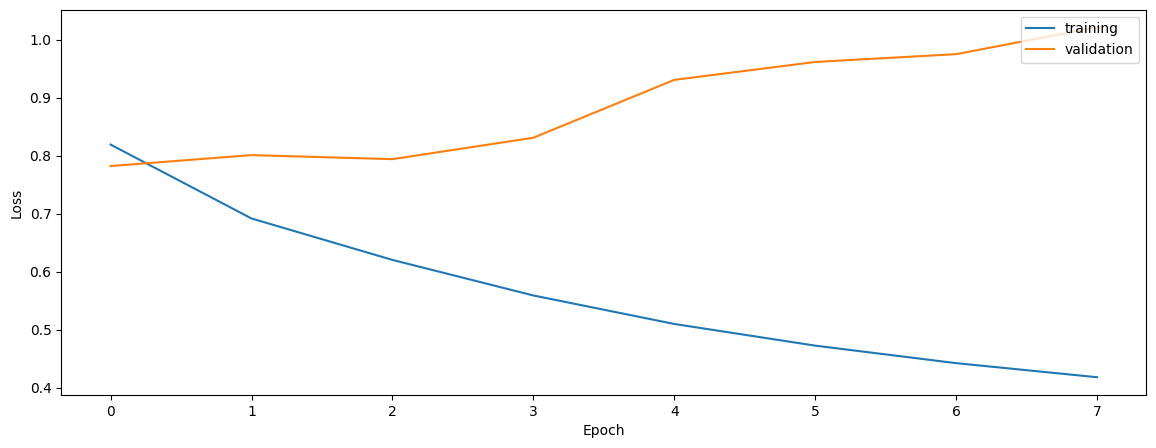

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7408556846063853
0.7328923312547705
0.7403055375833327


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7408556846063853
0.7328923312547705
0.7403055375833327


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7364981040346879
0.7407405086797774
0.7366340523543428


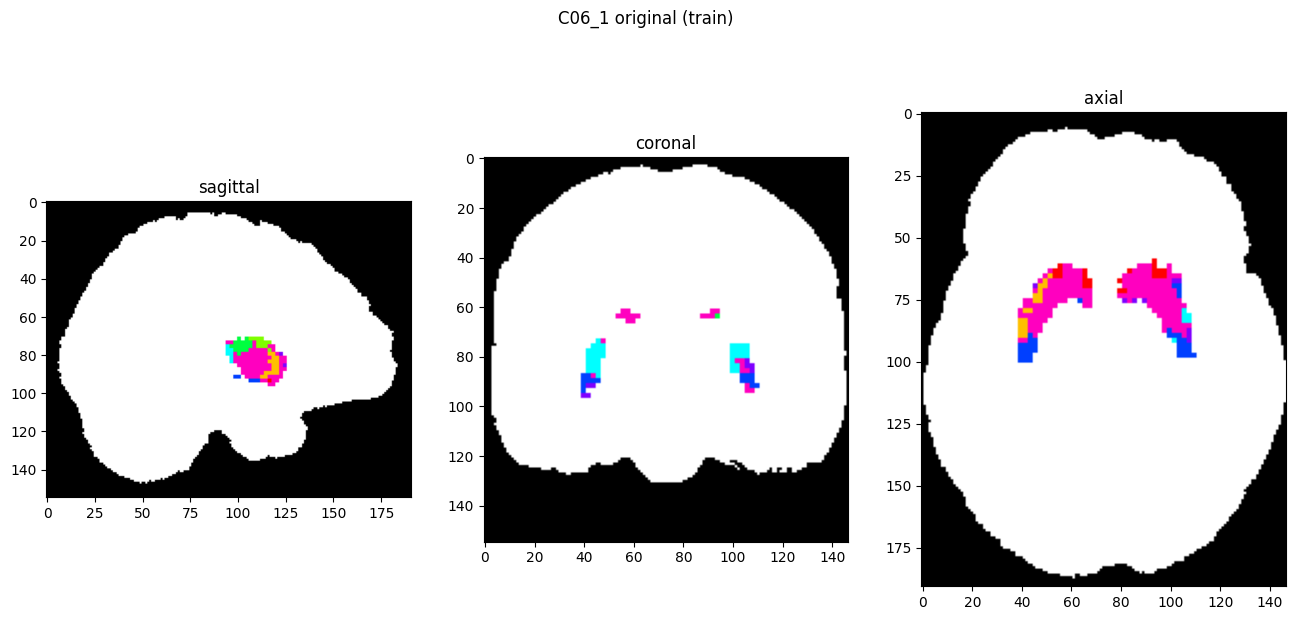

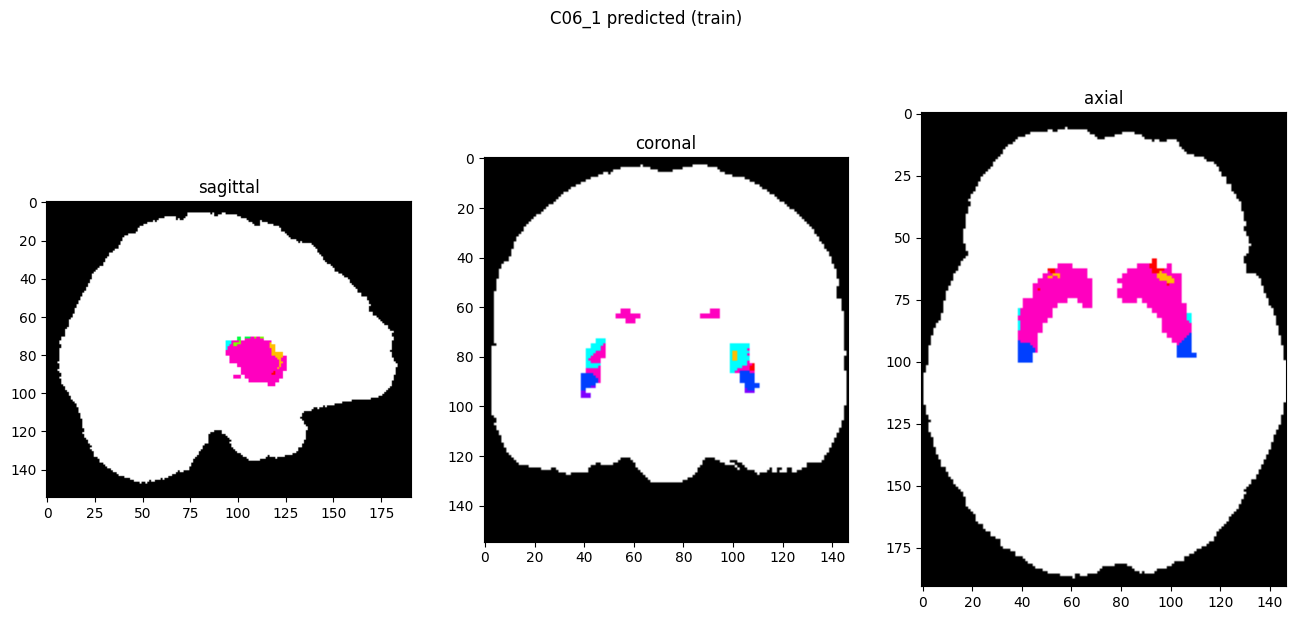

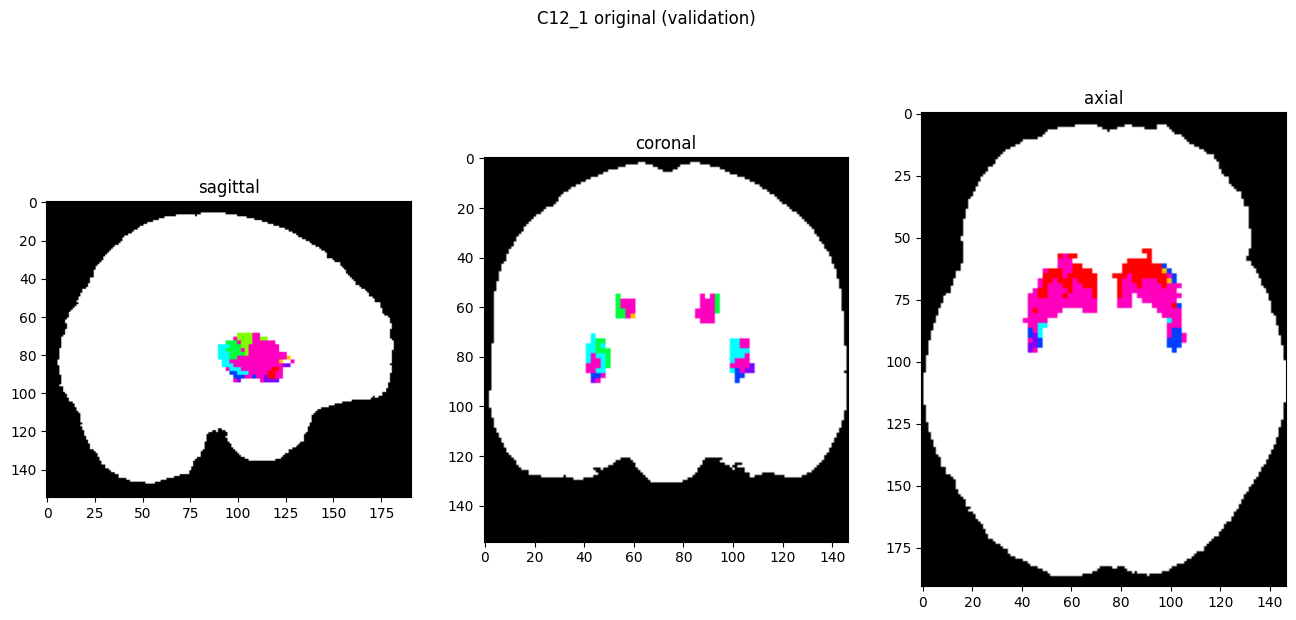

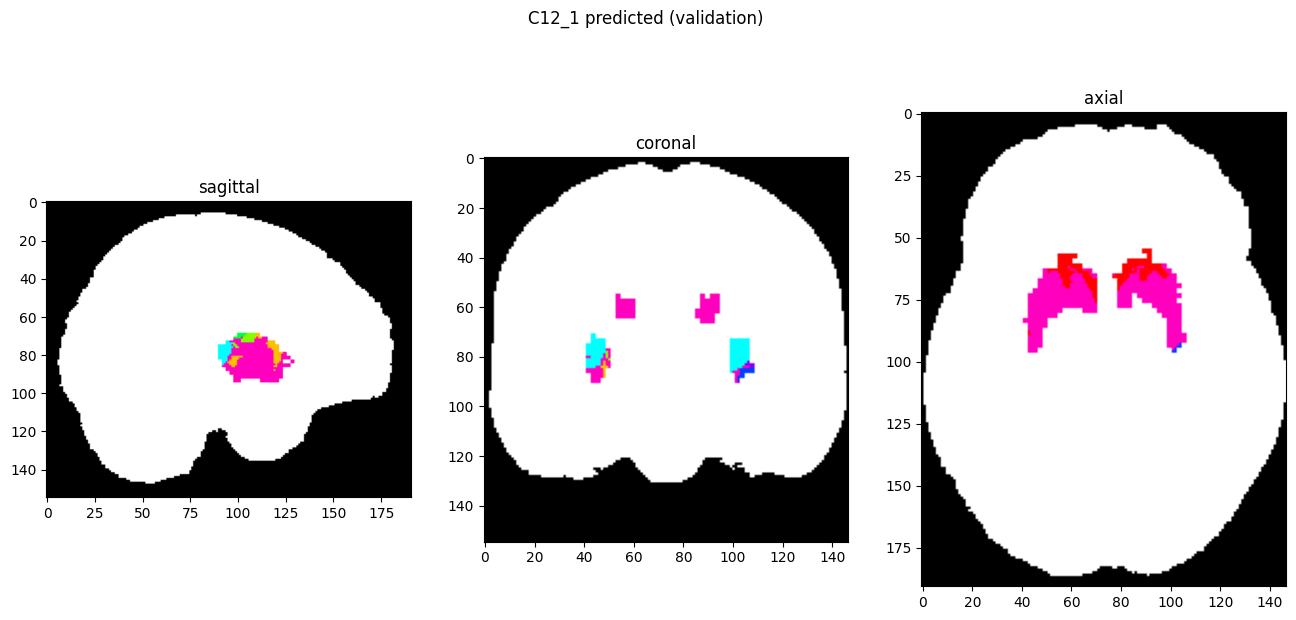

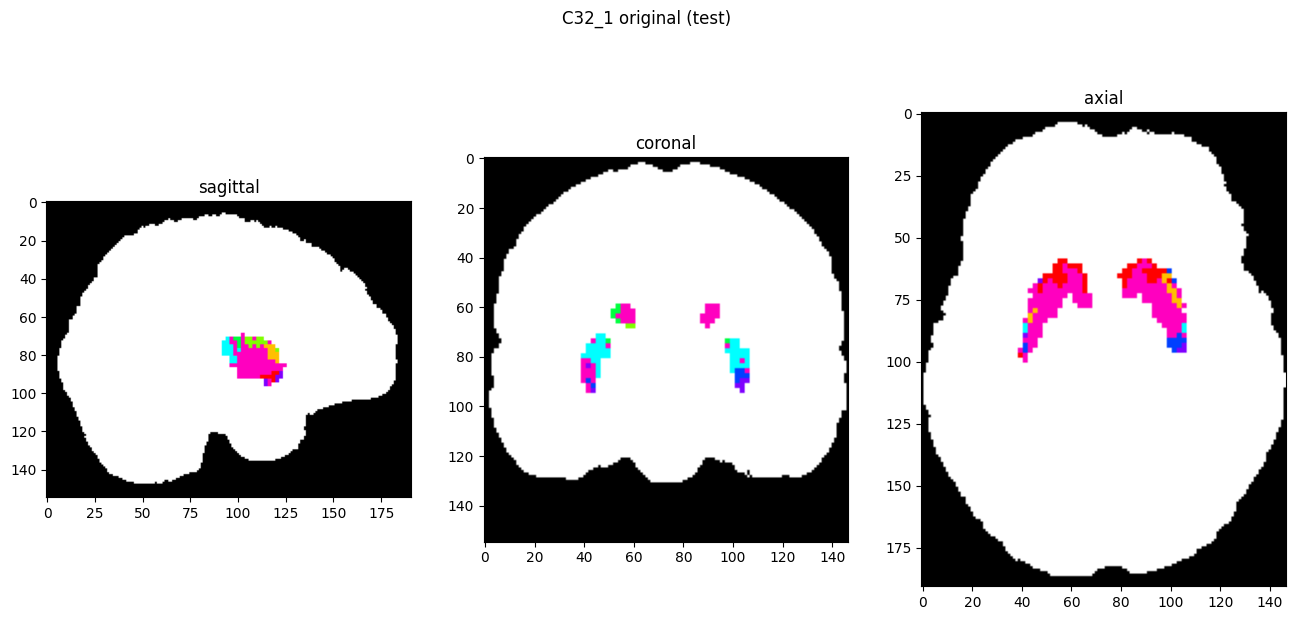

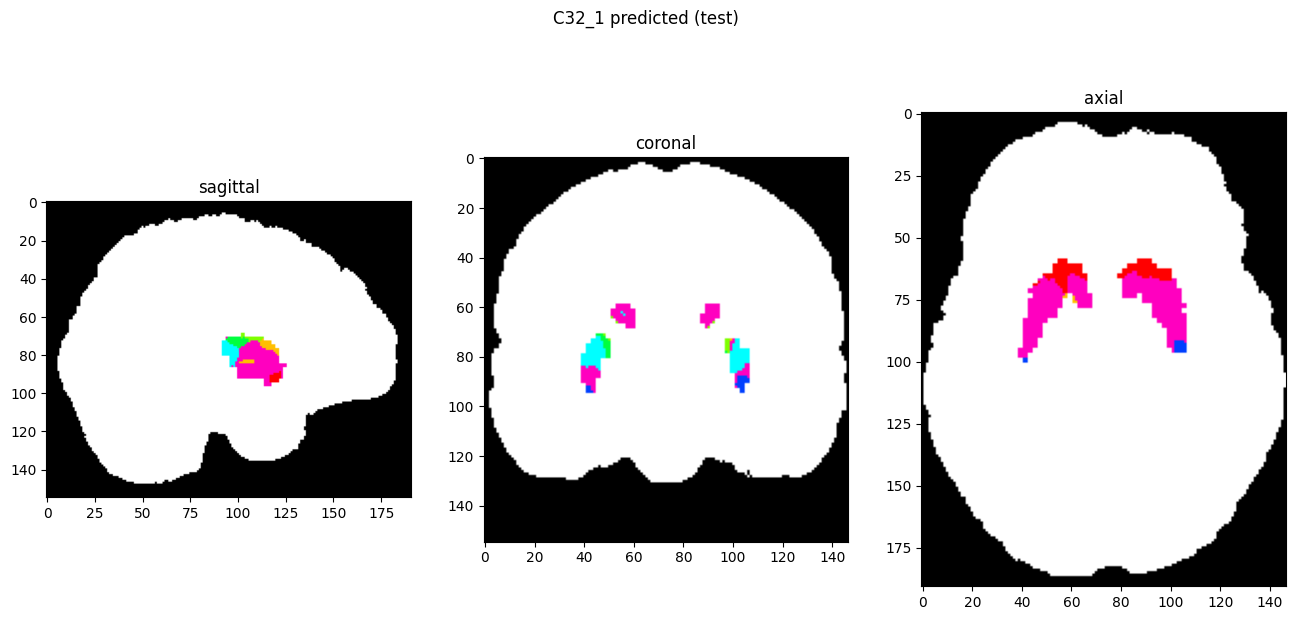

In [10]:
showResults(model, gen, threshold=0)